# Modelling Optimization

Purpose:
* improve the FB Prophet model performance as much as possible by:
    * Tunning Hyper Params
    * Cross Validation
    * adjusting log / indexing of monetary features
* Check against baseline results 
* Make Predictions with model

Time permitting:
* tune ARIMA model and check against prophet tuned model and baseline models.

In [50]:
# data cleaning 
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np

# visualizations
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
# modelling - prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import itertools
# modelling - other
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# import statsmodels.API as sm
import warnings; 
warnings.simplefilter('ignore')
#surpress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

In [51]:
# import model data log
data_log = pd.read_csv('data/model_data_log.csv')

# import model data in dollars (not log)
model_data_grouped = pd.read_csv('data/model_data_grouped.csv')
# model_data_grouped

In [52]:
# Function to get the variable name of a DataFrame
def get_variable_name(dataframe, namespace):
    ''' for documentation, when want to refer to the name of the dataframe, not the dataframe itself
    '''
    for name, obj in namespace.items():
        if obj is dataframe:
            return name
    return None

## Baseline Model 1: Prophet
(from other notebook)

In [53]:
def df_year_filter(df_name, start_year, end_year):
    ''' filters data based on period year for modelling
    '''
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    result = df_name.loc[(df_name['ds'].dt.year >= start_year) & (df_name['ds'].dt.year <= end_year)].reset_index(drop=True)
    return result

In [54]:
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_data = df_year_filter(data_log, start_year=1988, end_year=2017)
# train_data
test_data = df_year_filter(data_log, start_year=2018, end_year=2019)
# test_data

In [55]:
# initialise model, no custom params
m=Prophet()
# fit train data to model
m.fit(train_data)

10:46:52 - cmdstanpy - INFO - Chain [1] start processing
10:46:52 - cmdstanpy - INFO - Chain [1] done processing


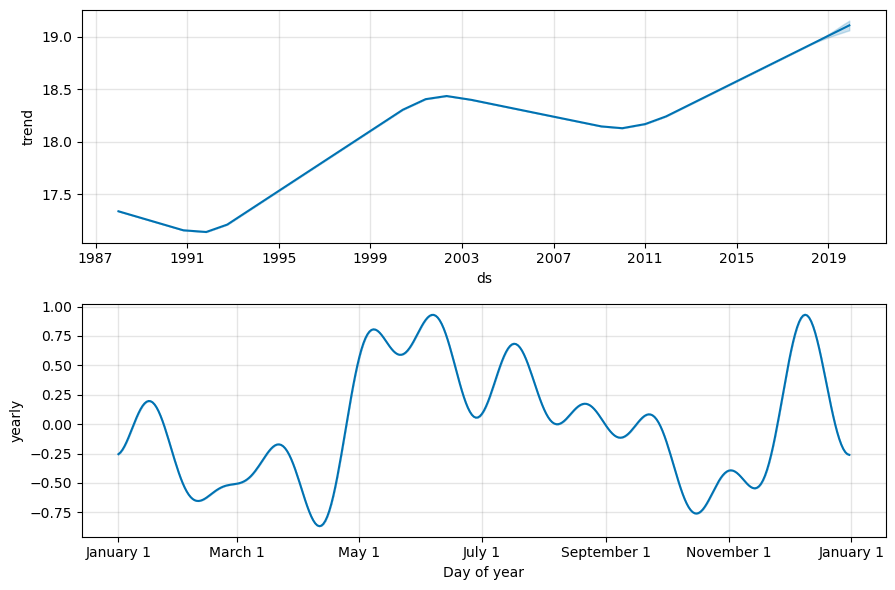

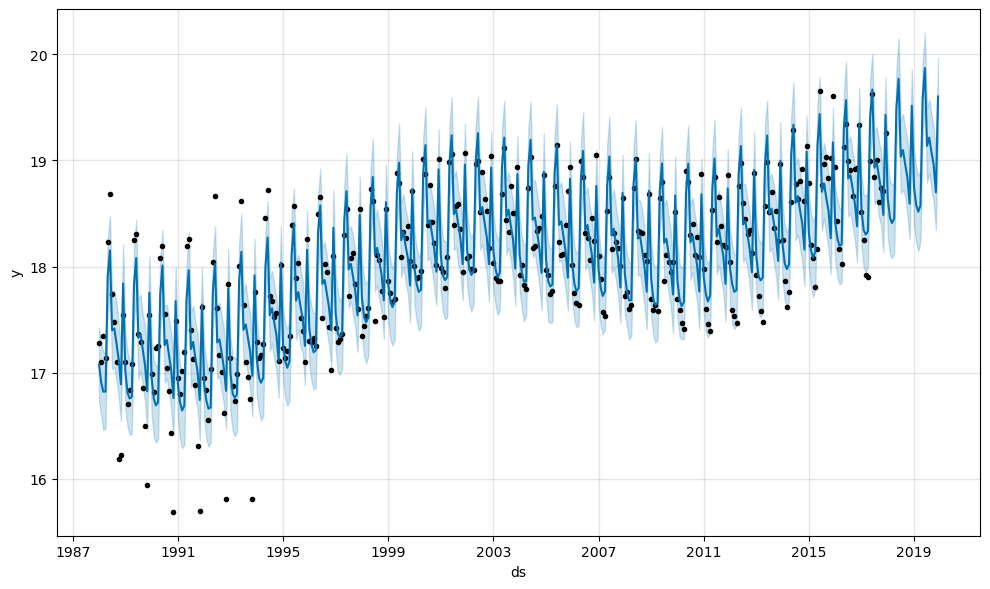

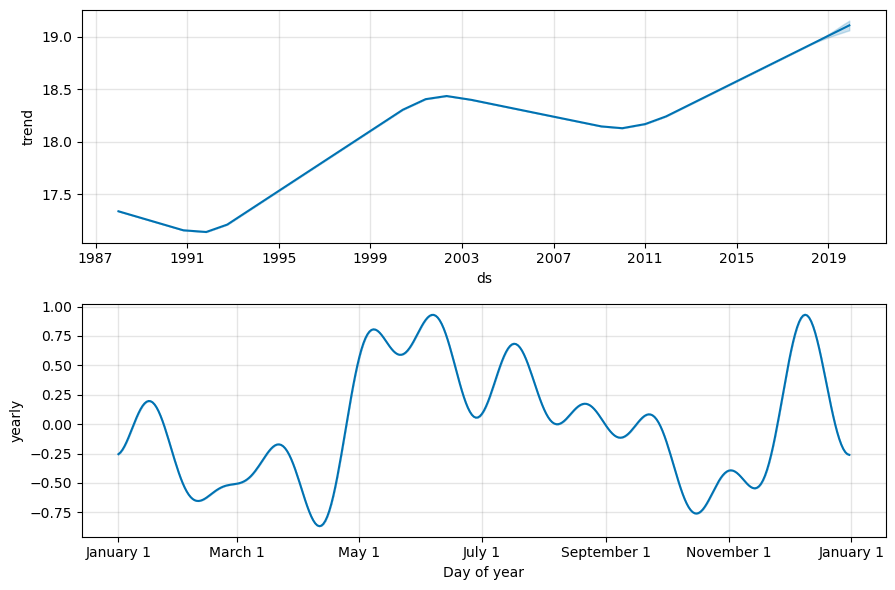

In [56]:
# predict 2018, 2019
future = m.make_future_dataframe(periods = 24, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [57]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

,ds,yhat,yhat_lower,yhat_upper
0,1988-01-01,17.08,16.71,17.44
1,1988-02-01,16.91,16.52,17.25
2,1988-03-01,16.82,16.47,17.17
3,1988-04-01,16.82,16.45,17.15
4,1988-05-01,17.91,17.55,18.27
...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59
380,2019-09-01,19.08,18.74,19.44
381,2019-10-01,18.96,18.60,19.32
382,2019-11-01,18.70,18.34,19.03


In [58]:
# get actual values for each period, between 1988 and 2017, values in LOG 
actuals = df_year_filter(data_log, 1988, 2019)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

,ds,y-actual
0,1988-01-01,17.28
1,1988-02-01,17.11
2,1988-03-01,17.34
3,1988-04-01,17.13
4,1988-05-01,18.23
...,...,...
379,2019-08-01,19.06
380,2019-09-01,18.96
381,2019-10-01,18.92
382,2019-11-01,18.72


In [59]:
# join actual values and predicted values into one DF
model_eval = predictions.merge(actuals, on='ds', how = 'inner')
model_eval = model_eval.rename(columns={'yhat': 'y-predicted'})
model_eval

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,17.08,16.71,17.44,17.28
1,1988-02-01,16.91,16.52,17.25,17.11
2,1988-03-01,16.82,16.47,17.17,17.34
3,1988-04-01,16.82,16.45,17.15,17.13
4,1988-05-01,17.91,17.55,18.27,18.23
...,...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59,19.06
380,2019-09-01,19.08,18.74,19.44,18.96
381,2019-10-01,18.96,18.60,19.32,18.92
382,2019-11-01,18.70,18.34,19.03,18.72


### Evaluate Model Performance

In [60]:
# return vals to original, take exponent
model_eval_exp = model_eval.copy()
model_eval_exp

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,17.08,16.71,17.44,17.28
1,1988-02-01,16.91,16.52,17.25,17.11
2,1988-03-01,16.82,16.47,17.17,17.34
3,1988-04-01,16.82,16.45,17.15,17.13
4,1988-05-01,17.91,17.55,18.27,18.23
...,...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59,19.06
380,2019-09-01,19.08,18.74,19.44,18.96
381,2019-10-01,18.96,18.60,19.32,18.92
382,2019-11-01,18.70,18.34,19.03,18.72


In [61]:
# return values to original non - log $
model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']])

In [62]:
model_eval_exp

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,"26,125,427.81","18,122,301.04","37,514,864.30","32,094,345.55"
1,1988-02-01,"22,072,594.23","15,007,229.31","30,996,862.58","26,852,319.99"
2,1988-03-01,"20,225,349.91","14,239,253.12","28,519,999.21","34,003,540.09"
3,1988-04-01,"20,240,672.14","13,880,806.17","27,932,227.87","27,637,080.92"
4,1988-05-01,"59,779,802.07","41,981,426.33","86,047,504.06","82,665,791.27"
...,...,...,...,...,...
379,2019-08-01,"221,450,826.28","158,353,361.62","323,408,219.81","190,136,068.39"
380,2019-09-01,"192,477,647.44","137,900,295.66","276,057,917.50","172,289,856.95"
381,2019-10-01,"171,613,607.06","120,101,274.77","245,236,680.80","165,147,457.37"
382,2019-11-01,"132,153,630.87","92,161,906.32","184,634,348.20","135,296,729.64"


In [73]:
#split results for test and train to get metrics for each. 
model_eval_exp_train = df_year_filter(model_eval_exp, 1988, 2017)
model_eval_exp_test = df_year_filter(model_eval_exp, 2018, 2019)


In [76]:
## Baseline Model Documentation:

baseline_rmse = mean_squared_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'], squared = False)
baseline_rmse_test = mean_squared_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'], squared = False)
baseline_rmse_train =  mean_squared_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'], squared = False)

baseline_mse = mean_squared_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'], squared = True)
baseline_mse_test = mean_squared_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'], squared = True)
baseline_mse_train =  mean_squared_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'], squared = True)

# print(f'baseline rmse for 1988 to 2019 {baseline_rmse} \n baseline mse for 1988 to 2019 {baseline_mse}')

mape_val = mean_absolute_percentage_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'])
mape_val_test =mean_absolute_percentage_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'])
mape_val_train = mean_absolute_percentage_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'])

# print(f'mape for 1988 to 2019 {mape_val}')
baseline_results_dict = {'RMSE':[baseline_rmse,baseline_rmse_test,baseline_rmse_train], 'MSE':[baseline_mse,baseline_mse_test,baseline_mse_train], 
'MAPE':[mape_val,mape_val_test,mape_val_train]}
baseline_results = pd.DataFrame(data=baseline_results_dict, index = ['1988 to 2019', 'test: 1988-2017', 'train:2018-2019'])
baseline_results

                                        


,RMSE,MSE,MAPE
1988 to 2019,"26,113,149.25","681,896,563,522,653.88",0.20
test: 1988-2017,"51,807,034.99","2,683,968,874,187,328.50",0.21
train:2018-2019,"23,418,477.24","548,425,076,145,008.88",0.20


In [77]:
baseline_results_dict

{'RMSE': [26113149.24559376, 51807034.987415835, 23418477.23796338],
 'MSE': [681896563522653.9, 2683968874187328.5, 548425076145008.9],
 'MAPE': [0.2025618686067732, 0.20829687078155723, 0.20217953512845424]}

#### Visualise Actuals vs Prediction

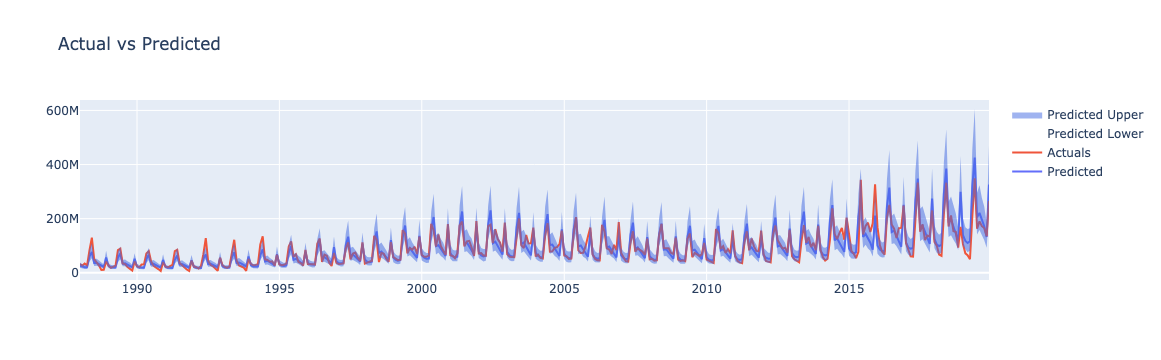

In [63]:
## plot predicted values against actuals, for test range (2018 and 2019 only)
fig = go.Figure()
x_vals1 = df_year_filter(model_eval_exp, 1988, 2019)['ds']


# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')

fig.add_trace(go.Scatter(x=x_vals1, y=model_eval_exp['yhat_upper'],
    fill=None,
    mode='lines',
    line_color='royalblue',line_width=0, name='Predicted Lower'
    ))
fig.add_trace(go.Scatter(
    x=x_vals1, y=model_eval_exp['yhat_lower'],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='royalblue', line_width=0, name='Predicted Upper'))

fig.show()

In [15]:
df_compare = model_eval_exp

## Model 2: Prophet Tuned with CV

In [43]:
# us data - not adjusted for inflation
us_data = pd.read_csv('data/data_clean.csv')
us_data = us_data[us_data['Country'].str.contains('United States')].reset_index(drop=True)

# sum sales by period 
us_data = us_data[['Period', 'Value']]
us_data = us_data.groupby('Period').sum().reset_index()
us_data = us_data.rename(columns= {'Period': 'ds', 'Value':'y'})
us_data

,ds,y
0,1988-01-01,14515954
1,1988-02-01,12230446
2,1988-03-01,15530879
3,1988-04-01,12658205
4,1988-05-01,38072540
...,...,...
424,2023-05-01,192319380
425,2023-06-01,321985092
426,2023-07-01,176271374
427,2023-08-01,150469147


### Get Best Params

??? How to use same test train split for comparison?
Train = 1988 to 2017
Test = 2018, 2019

Attempt:
* Use full dataset to get the best params. 
* Re run model with best params, for test, and train seperately, to get seperate scores for easier comparisons

In [44]:
documentation = {}
documentation['description'] = 'Tuned Prophet Model, with CV, using non-indexed values'

In [45]:
# Prophet suggested ranges

changepoint_range = [0.001, 0.101,0.201,0.301,0.401,0.5]

# print('changepoint_range:',changepoint_range)

seasonality_range=[0.01, 1.01, 3.01, 5.0, 7.01, 10]
# print('seasonality_range: ', seasonality_range)

# holidays_range =  np.arange(0.01, 10, 0.5) 
holidays_range=  [0.01, 1.01, 3.01, 5.0, 7.01, 10]
# print('holidays_range: ', holidays_range)

seasonanility_mode = ['additive', 'multiplicative']
yearly_seasonality = [True, False] 

In [46]:

param_grid = {  
    'changepoint_prior_scale': changepoint_range,
    'seasonality_prior_scale': seasonality_range,
    'seasonality_mode':seasonanility_mode, 
    'yearly_seasonality':  yearly_seasonality  
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# all_params
documentation['params_options']= param_grid
documentation

{'description': 'Tuned Prophet Model, with CV, using non-indexed values',
 'params_options': {'changepoint_prior_scale': [0.001,
   0.101,
   0.201,
   0.301,
   0.401,
   0.5],
  'seasonality_prior_scale': [0.01, 1.01, 3.01, 5.0, 7.01, 10],
  'seasonality_mode': ['additive', 'multiplicative'],
  'yearly_seasonality': [True, False]}}

QUESTION: 
* run model for entire data or just training range set given CV?
* default code df_cv value at index 0 meaning? 
* for each loop df_p returns RMSE's for many time horizons how to get one value ?
    * reconclie df_p, vs df_cv meaning
    * take average of all RMSE's in the loop (over different horizons)

In [47]:
# # Use cross-validationa to evaluate all parameters
## takes ~~3 minutes to run

## variables 
cv_cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01']) # manually set dates for new prediction
cv_initial = '10593 days' # number of days from 1988 to 2017
cv_period = '365 days'
cv_horizon = '365 days'
cv_parallel = 'processes'

## Lists to store metrics for each param combo
rmses = []  # Store the RMSEs for each params here
mapes = []# Store the MAPES for each params here
rmses_avg = [] # to compare, the avg rmse for all horizons
mapes_avg = [] # to compare, the avg MAPE for all horizons

# for each unique param combo, run a prophet model 
for params in all_params:
    print(params)
    m = Prophet(**params).fit(us_data)  
    # initial/train from 1988 to 2017 
    # then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
    df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon, parallel=cv_parallel, cutoffs=cv_cutoffs)
    print(df_cv)
    # get metrics for overall predictions made using CV, not just on one horizon
    rmse_val = np.sqrt(mean_squared_error(df_cv['y'],df_cv['yhat']))
    mape_val = mean_absolute_percentage_error(df_cv['y'],df_cv['yhat'])
    df_p = performance_metrics(df_cv, rolling_window=1)
    # print(df_p)
    rmses.append(rmse_val)
    mapes.append(mape_val)
    rmses_avg.append(df_p['rmse'].mean())
    mapes_avg.append(df_p['mape'].mean())

documentation[".fit()"] =  get_variable_name(us_data, locals())
documentation['cv_param_cutoffs'] = cv_cutoffs
documentation['cv_param_initial'] = cv_initial
documentation['cv_param_period'] = cv_period
documentation['cv_param_horizon'] = cv_horizon
documentation['cv_param_parallel'] = cv_parallel

# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation["model_prediction_date:"] =  dt_string


10:42:59 - cmdstanpy - INFO - Chain [1] start processing
10:42:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


10:43:00 - cmdstanpy - INFO - Chain [1] start processing
10:43:00 - cmdstanpy - INFO - Chain [1] start processing
10:43:00 - cmdstanpy - INFO - Chain [1] done processing
10:43:00 - cmdstanpy - INFO - Chain [1] done processing
10:43:00 - cmdstanpy - INFO - Chain [1] start processing
10:43:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  83,218,833.83  53,774,709.52 113,669,250.26   80965152   
1  2018-03-01  79,957,769.80  49,954,101.03 109,521,981.78   55383560   
2  2018-04-01  79,288,796.14  49,794,271.90 107,092,864.56   51622955   
3  2018-05-01 124,702,374.24  92,990,715.64 154,346,631.04  176968819   
4  2018-06-01 148,658,592.44 120,504,845.48 181,763,295.89  274311951   
5  2018-07-01 100,850,746.71  68,541,350.41 130,699,783.12  141734086   
6  2018-08-01 105,781,731.64  74,551,700.68 135,556,222.42  175208071   
7  2018-09-01 100,605,736.23  71,350,735.77 128,202,807.60  126732400   
8  2018-10-01 100,111,722.78  68,702,217.18 129,701,528.85  125340703   
9  2018-11-01  96,309,393.36  66,541,997.58 127,183,397.72   76371568   
10 2018-12-01 136,698,071.21 106,994,066.56 167,291,615.91  139650313   
11 2019-01-01  92,440,116.82  62,461,947.75 124,123,234.71   87750515   
12 2019-02-01  87,225,023.90  56,000,136.69 118,266

10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 59,934,939.57 151,466,636.56   80965152   
1  2018-03-01 104,680,595.24 57,707,830.77 154,299,743.75   55383560   
2  2018-04-01 104,919,487.83 55,959,324.41 146,577,574.37   51622955   
3  2018-05-01 105,150,674.21 63,610,231.50 151,474,382.34  176968819   
4  2018-06-01 105,389,566.81 64,288,427.13 149,226,648.13  274311951   
5  2018-07-01 105,620,753.19 59,627,897.65 152,092,822.82  141734086   
6  2018-08-01 105,859,645.78 62,560,793.48 153,252,821.30  175208071   
7  2018-09-01 106,098,538.37 60,493,661.25 149,615,708.47  126732400   
8  2018-10-01 106,329,724.75 58,078,863.23 152,493,280.53  125340703   
9  2018-11-01 106,568,617.35 63,488,952.97 155,157,982.66   76371568   
10 2018-12-01 106,799,803.73 63,889,295.91 148,803,999.79  139650313   
11 2019-01-01 107,038,696.32 62,999,591.50 147,986,434.60   87750515   
12 2019-02-01 108,613,053.39 58,865,769.93 158,158,079.07   5976

10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 101,990,538.29 62,134,330.03 143,302,488.81   80965152   
1  2018-03-01 100,749,418.04 57,099,350.61 142,062,688.02   55383560   
2  2018-04-01 100,073,754.96 59,580,759.66 141,504,416.08   51622955   
3  2018-05-01 109,520,303.94 66,051,364.95 151,341,254.37  176968819   
4  2018-06-01 115,167,831.69 75,843,720.63 156,664,760.31  274311951   
5  2018-07-01 104,501,041.50 63,524,915.29 148,231,238.94  141734086   
6  2018-08-01 105,899,444.63 63,680,306.28 147,667,349.02  175208071   
7  2018-09-01 105,008,053.04 64,351,690.69 147,132,584.92  126732400   
8  2018-10-01 105,801,440.87 63,740,329.57 148,344,265.06  125340703   
9  2018-11-01 105,603,297.33 62,136,726.14 147,594,381.15   76371568   
10 2018-12-01 115,536,621.49 74,896,883.63 156,122,358.22  139650313   
11 2019-01-01 105,832,429.87 61,934,450.20 150,160,235.07   87750515   
12 2019-02-01 107,298,438.97 65,455,725.94 150,808,998.09   5976

10:43:02 - cmdstanpy - INFO - Chain [1] start processing
10:43:02 - cmdstanpy - INFO - Chain [1] start processing
10:43:02 - cmdstanpy - INFO - Chain [1] done processing
10:43:02 - cmdstanpy - INFO - Chain [1] done processing
10:43:02 - cmdstanpy - INFO - Chain [1] start processing
10:43:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,074,026.73 150,515,016.46   80965152   
1  2018-03-01 104,680,595.24 59,270,264.40 151,612,974.86   55383560   
2  2018-04-01 104,919,487.83 60,241,178.89 149,743,266.56   51622955   
3  2018-05-01 105,150,674.21 58,486,811.90 151,655,339.49  176968819   
4  2018-06-01 105,389,566.81 57,678,390.43 148,522,937.31  274311951   
5  2018-07-01 105,620,753.19 59,605,908.26 148,834,252.61  141734086   
6  2018-08-01 105,859,645.78 63,031,979.76 152,355,548.27  175208071   
7  2018-09-01 106,098,538.37 62,232,856.66 155,124,168.65  126732400   
8  2018-10-01 106,329,724.75 60,226,361.48 147,733,687.47  125340703   
9  2018-11-01 106,568,617.35 63,851,177.20 150,357,623.55   76371568   
10 2018-12-01 106,799,803.73 60,750,842.00 151,050,142.95  139650313   
11 2019-01-01 107,038,696.32 61,239,468.82 155,617,919.30   87750515   
12 2019-02-01 108,613,053.39 58,389,753.23 156,340,078.35   5976

10:43:02 - cmdstanpy - INFO - Chain [1] start processing
10:43:02 - cmdstanpy - INFO - Chain [1] start processing
10:43:02 - cmdstanpy - INFO - Chain [1] done processing
10:43:02 - cmdstanpy - INFO - Chain [1] done processing
10:43:02 - cmdstanpy - INFO - Chain [1] start processing
10:43:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,565,076.65  36,167,999.48 112,922,783.14   80965152   
1  2018-03-01  73,157,818.48  36,407,542.97 110,789,733.22   55383560   
2  2018-04-01  75,373,313.04  38,487,383.68 113,663,552.25   51622955   
3  2018-05-01 123,130,515.56  80,730,606.31 160,624,111.78  176968819   
4  2018-06-01 150,207,749.83 114,199,242.64 189,289,847.22  274311951   
5  2018-07-01 102,916,220.62  62,565,957.97 142,510,768.99  141734086   
6  2018-08-01 107,152,187.45  68,347,989.14 143,850,604.68  175208071   
7  2018-09-01 100,570,781.90  59,621,873.15 140,308,607.92  126732400   
8  2018-10-01  98,051,216.38  56,484,759.58 137,289,656.69  125340703   
9  2018-11-01  92,750,209.20  54,538,174.03 131,742,256.78   76371568   
10 2018-12-01 131,792,188.99  95,153,051.83 171,575,798.85  139650313   
11 2019-01-01  84,564,857.07  47,094,091.92 122,879,473.62   87750515   
12 2019-02-01  80,050,104.07  30,377,526.48 127,405

10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing
10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 57,514,070.99 151,828,182.14   80965152   
1  2018-03-01 104,680,595.24 59,907,219.95 147,483,536.74   55383560   
2  2018-04-01 104,919,487.83 60,852,878.47 149,970,551.48   51622955   
3  2018-05-01 105,150,674.21 58,719,575.78 149,396,913.31  176968819   
4  2018-06-01 105,389,566.81 59,411,763.14 149,071,872.57  274311951   
5  2018-07-01 105,620,753.19 59,706,399.99 149,607,141.64  141734086   
6  2018-08-01 105,859,645.78 60,595,545.59 154,858,813.75  175208071   
7  2018-09-01 106,098,538.37 62,710,214.88 149,634,775.47  126732400   
8  2018-10-01 106,329,724.75 61,987,293.92 151,304,578.06  125340703   
9  2018-11-01 106,568,617.35 59,266,424.71 150,970,867.23   76371568   
10 2018-12-01 106,799,803.73 62,674,793.74 152,712,660.22  139650313   
11 2019-01-01 107,038,696.32 60,546,262.68 152,743,487.41   87750515   
12 2019-02-01 108,613,053.39 58,478,621.85 156,998,245.14   5976

10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing
10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,993,624.49 58,687,253.20 142,978,471.71   80965152   
1  2018-03-01  99,379,975.23 59,736,611.74 139,579,703.87   55383560   
2  2018-04-01  98,472,152.87 56,888,127.84 136,799,178.32   51622955   
3  2018-05-01 110,278,705.72 71,853,608.68 151,921,958.69  176968819   
4  2018-06-01 117,313,047.30 76,191,301.25 157,236,971.91  274311951   
5  2018-07-01 103,854,876.57 60,877,541.63 142,483,330.28  141734086   
6  2018-08-01 105,549,994.32 67,763,218.02 146,099,282.04  175208071   
7  2018-09-01 104,367,208.49 61,476,210.31 143,113,353.75  126732400   
8  2018-10-01 105,304,293.79 62,382,949.97 143,911,817.06  125340703   
9  2018-11-01 104,994,472.61 62,330,887.02 150,554,942.88   76371568   
10 2018-12-01 117,412,746.41 74,998,843.08 158,057,163.37  139650313   
11 2019-01-01 105,162,058.66 68,489,263.85 146,832,334.98   87750515   
12 2019-02-01 105,475,052.98 61,080,523.39 147,008,845.63   5976

10:43:04 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing
10:43:04 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,616,167.07 148,757,825.53   80965152   
1  2018-03-01 104,680,595.24 59,120,400.39 153,115,770.48   55383560   
2  2018-04-01 104,919,487.83 63,304,720.36 150,522,606.97   51622955   
3  2018-05-01 105,150,674.21 61,693,681.07 152,679,520.17  176968819   
4  2018-06-01 105,389,566.81 60,197,095.11 150,409,769.46  274311951   
5  2018-07-01 105,620,753.19 58,536,932.44 152,556,482.53  141734086   
6  2018-08-01 105,859,645.78 59,771,678.22 150,053,692.52  175208071   
7  2018-09-01 106,098,538.37 60,657,594.14 151,116,556.67  126732400   
8  2018-10-01 106,329,724.75 61,061,392.05 149,769,377.83  125340703   
9  2018-11-01 106,568,617.35 60,063,939.86 155,044,682.55   76371568   
10 2018-12-01 106,799,803.73 60,911,959.24 151,906,575.57  139650313   
11 2019-01-01 107,038,696.32 63,273,542.44 154,836,479.46   87750515   
12 2019-02-01 108,613,053.39 59,145,133.81 157,147,828.69   5976

10:43:04 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing
10:43:04 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing
10:43:04 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,608,641.50  34,030,501.35 112,838,287.47   80965152   
1  2018-03-01  72,919,728.36  35,274,152.99 110,236,685.89   55383560   
2  2018-04-01  74,886,032.17  35,532,846.75 116,228,585.01   51622955   
3  2018-05-01 123,700,337.60  83,840,938.47 159,770,411.82  176968819   
4  2018-06-01 151,209,517.10 109,937,852.97 187,691,771.64  274311951   
5  2018-07-01 102,538,036.32  64,150,310.21 140,507,230.45  141734086   
6  2018-08-01 106,949,430.01  67,598,471.48 143,914,151.57  175208071   
7  2018-09-01 100,319,476.96  59,036,037.89 137,836,075.15  126732400   
8  2018-10-01  97,938,983.27  57,454,711.01 137,313,861.95  125340703   
9  2018-11-01  92,665,496.05  55,358,663.28 129,772,279.81   76371568   
10 2018-12-01 132,940,874.07  93,654,328.06 171,931,122.23  139650313   
11 2019-01-01  84,674,716.45  43,364,449.37 119,979,973.04   87750515   
12 2019-02-01  80,055,847.65  34,959,853.35 132,285

10:43:05 - cmdstanpy - INFO - Chain [1] start processing
10:43:05 - cmdstanpy - INFO - Chain [1] start processing
10:43:05 - cmdstanpy - INFO - Chain [1] done processing
10:43:05 - cmdstanpy - INFO - Chain [1] done processing
10:43:05 - cmdstanpy - INFO - Chain [1] start processing
10:43:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 57,402,292.94 149,484,248.18   80965152   
1  2018-03-01 104,680,595.24 59,022,274.91 152,874,253.40   55383560   
2  2018-04-01 104,919,487.83 57,091,058.05 149,419,090.82   51622955   
3  2018-05-01 105,150,674.21 58,438,471.70 154,137,947.08  176968819   
4  2018-06-01 105,389,566.81 57,087,286.01 150,418,855.00  274311951   
5  2018-07-01 105,620,753.19 61,615,168.41 153,819,682.59  141734086   
6  2018-08-01 105,859,645.78 61,978,440.19 152,733,593.63  175208071   
7  2018-09-01 106,098,538.37 59,196,066.05 152,233,977.60  126732400   
8  2018-10-01 106,329,724.75 61,399,853.37 150,452,880.95  125340703   
9  2018-11-01 106,568,617.35 61,615,472.16 154,743,072.38   76371568   
10 2018-12-01 106,799,803.73 62,661,045.74 153,380,636.91  139650313   
11 2019-01-01 107,038,696.32 63,044,167.73 151,836,626.80   87750515   
12 2019-02-01 108,613,053.39 60,178,826.41 159,577,209.31   5976

10:43:05 - cmdstanpy - INFO - Chain [1] start processing
10:43:05 - cmdstanpy - INFO - Chain [1] start processing
10:43:05 - cmdstanpy - INFO - Chain [1] done processing
10:43:05 - cmdstanpy - INFO - Chain [1] done processing
10:43:05 - cmdstanpy - INFO - Chain [1] start processing
10:43:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,995,868.79 63,545,656.61 139,731,871.81   80965152   
1  2018-03-01  99,382,456.71 57,905,424.05 137,334,967.94   55383560   
2  2018-04-01  98,474,782.44 55,553,955.65 137,753,144.13   51622955   
3  2018-05-01 110,279,783.56 69,418,799.96 152,547,664.71  176968819   
4  2018-06-01 117,313,200.95 75,884,944.54 156,456,323.80  274311951   
5  2018-07-01 103,856,871.91 63,205,040.65 145,275,641.84  141734086   
6  2018-08-01 105,551,798.66 64,452,337.82 145,813,233.27  175208071   
7  2018-09-01 104,369,194.30 63,535,908.54 143,927,793.75  126732400   
8  2018-10-01 105,306,189.53 64,557,023.13 146,870,221.60  125340703   
9  2018-11-01 104,996,453.79 66,514,382.93 145,766,333.17   76371568   
10 2018-12-01 117,413,115.43 76,183,373.15 158,353,797.85  139650313   
11 2019-01-01 105,164,119.26 65,970,155.85 145,533,549.06   87750515   
12 2019-02-01 105,477,538.23 61,502,651.37 148,757,250.89   5976

10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing
10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,394,378.96 149,305,581.80   80965152   
1  2018-03-01 104,680,595.24 61,893,685.93 147,882,391.13   55383560   
2  2018-04-01 104,919,487.83 60,452,090.28 148,138,949.20   51622955   
3  2018-05-01 105,150,674.21 59,216,931.22 150,076,225.14  176968819   
4  2018-06-01 105,389,566.81 60,261,613.87 150,305,241.46  274311951   
5  2018-07-01 105,620,753.19 61,416,653.08 147,857,720.54  141734086   
6  2018-08-01 105,859,645.78 59,773,890.64 148,935,965.47  175208071   
7  2018-09-01 106,098,538.37 60,779,335.31 151,464,824.66  126732400   
8  2018-10-01 106,329,724.75 59,169,039.31 151,490,351.15  125340703   
9  2018-11-01 106,568,617.35 61,612,300.20 148,084,309.87   76371568   
10 2018-12-01 106,799,803.73 62,419,631.98 147,358,462.80  139650313   
11 2019-01-01 107,038,696.32 62,105,273.09 152,085,492.99   87750515   
12 2019-02-01 108,613,053.39 63,047,272.54 154,986,200.85   5976

10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing
10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,582,517.44  37,309,824.16 111,876,774.89   80965152   
1  2018-03-01  73,307,911.59  36,618,499.11 113,420,521.59   55383560   
2  2018-04-01  75,558,987.65  36,375,099.78 114,916,337.30   51622955   
3  2018-05-01 122,930,174.39  84,549,778.67 162,046,500.06  176968819   
4  2018-06-01 149,875,791.42 111,842,708.60 188,105,409.83  274311951   
5  2018-07-01 103,000,791.93  67,316,682.32 141,277,251.85  141734086   
6  2018-08-01 107,169,409.64  68,020,337.77 145,869,847.11  175208071   
7  2018-09-01 100,611,929.44  64,126,415.18 139,629,770.96  126732400   
8  2018-10-01  98,074,366.80  60,806,318.22 137,136,725.77  125340703   
9  2018-11-01  92,823,869.45  53,526,014.67 132,684,684.20   76371568   
10 2018-12-01 131,515,671.85  89,950,842.47 169,916,506.31  139650313   
11 2019-01-01  84,559,807.86  46,630,009.46 125,649,093.67   87750515   
12 2019-02-01  75,533,210.30  25,556,329.77 123,297

10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 55,718,838.45 152,902,265.71   80965152   
1  2018-03-01 104,680,595.24 60,091,621.22 149,195,321.69   55383560   
2  2018-04-01 104,919,487.83 59,936,484.09 152,949,611.79   51622955   
3  2018-05-01 105,150,674.21 58,776,133.08 150,010,261.44  176968819   
4  2018-06-01 105,389,566.81 60,003,484.89 154,909,440.27  274311951   
5  2018-07-01 105,620,753.19 61,954,454.12 149,788,808.03  141734086   
6  2018-08-01 105,859,645.78 62,466,369.41 149,236,064.16  175208071   
7  2018-09-01 106,098,538.37 57,877,256.47 149,935,302.38  126732400   
8  2018-10-01 106,329,724.75 62,929,596.95 147,311,085.65  125340703   
9  2018-11-01 106,568,617.35 62,768,607.37 150,779,692.39   76371568   
10 2018-12-01 106,799,803.73 61,742,662.53 153,855,382.58  139650313   
11 2019-01-01 107,038,696.32 61,916,881.81 152,772,084.70   87750515   
12 2019-02-01 108,613,053.39 61,456,376.93 157,217,431.45   5976

10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,655.19 60,855,307.79 143,087,091.70   80965152   
1  2018-03-01  99,384,465.00 58,823,838.37 141,489,727.10   55383560   
2  2018-04-01  98,476,951.10 55,780,708.75 138,382,867.37   51622955   
3  2018-05-01 110,280,375.41 70,687,437.03 148,371,116.12  176968819   
4  2018-06-01 117,312,876.15 78,647,473.59 157,707,800.15  274311951   
5  2018-07-01 103,858,380.98 64,836,750.32 147,115,320.12  141734086   
6  2018-08-01 105,553,117.30 65,947,505.78 145,088,617.26  175208071   
7  2018-09-01 104,370,692.28 60,147,473.94 143,604,926.91  126732400   
8  2018-10-01 105,307,607.47 64,431,573.39 147,973,105.97  125340703   
9  2018-11-01 104,997,957.38 66,492,041.58 147,560,979.04   76371568   
10 2018-12-01 117,413,002.67 78,854,483.83 157,596,271.04  139650313   
11 2019-01-01 105,165,696.98 61,580,971.15 146,716,042.51   87750515   
12 2019-02-01 105,470,842.28 60,629,002.58 149,990,988.17   5976

10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,993,958.01 150,018,002.33   80965152   
1  2018-03-01 104,680,595.24 57,979,691.23 148,235,689.73   55383560   
2  2018-04-01 104,919,487.83 61,410,867.27 147,372,839.28   51622955   
3  2018-05-01 105,150,674.21 58,161,841.92 151,138,256.64  176968819   
4  2018-06-01 105,389,566.81 59,086,264.83 147,331,030.79  274311951   
5  2018-07-01 105,620,753.19 57,959,159.46 149,266,336.32  141734086   
6  2018-08-01 105,859,645.78 60,560,436.71 153,179,975.41  175208071   
7  2018-09-01 106,098,538.37 60,073,251.94 154,381,050.80  126732400   
8  2018-10-01 106,329,724.75 61,113,182.97 154,310,565.71  125340703   
9  2018-11-01 106,568,617.35 62,816,267.56 150,386,765.62   76371568   
10 2018-12-01 106,799,803.73 61,671,610.75 151,772,026.70  139650313   
11 2019-01-01 107,038,696.32 59,654,545.88 154,763,817.55   87750515   
12 2019-02-01 108,613,053.39 60,896,684.30 158,333,873.09   5976

10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,571,209.94  34,261,073.54 115,332,692.85   80965152   
1  2018-03-01  73,237,543.16  33,325,874.93 111,149,073.52   55383560   
2  2018-04-01  75,449,266.27  36,884,953.05 114,254,856.10   51622955   
3  2018-05-01 123,019,107.97  84,772,214.86 161,805,161.19  176968819   
4  2018-06-01 150,040,735.29 108,672,244.85 192,094,028.25  274311951   
5  2018-07-01 102,919,023.75  64,330,893.51 140,889,000.71  141734086   
6  2018-08-01 107,121,471.90  69,374,641.85 146,969,900.81  175208071   
7  2018-09-01 100,554,357.67  60,602,915.49 141,037,725.86  126732400   
8  2018-10-01  98,038,535.90  58,194,758.58 135,432,809.87  125340703   
9  2018-11-01  92,784,128.82  55,340,897.28 133,586,754.66   76371568   
10 2018-12-01 131,692,986.96  90,152,626.70 172,067,973.96  139650313   
11 2019-01-01  84,559,316.48  45,097,720.61 122,202,576.10   87750515   
12 2019-02-01  80,057,130.94  32,352,243.30 132,027

10:43:09 - cmdstanpy - INFO - Chain [1] start processing
10:43:09 - cmdstanpy - INFO - Chain [1] start processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing
10:43:09 - cmdstanpy - INFO - Chain [1] start processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,860,776.53 147,595,128.48   80965152   
1  2018-03-01 104,680,595.24 59,283,036.45 148,680,698.95   55383560   
2  2018-04-01 104,919,487.83 59,330,262.73 150,994,525.43   51622955   
3  2018-05-01 105,150,674.21 59,638,848.86 148,895,542.67  176968819   
4  2018-06-01 105,389,566.81 59,651,639.50 150,648,425.57  274311951   
5  2018-07-01 105,620,753.19 60,642,036.25 151,394,221.79  141734086   
6  2018-08-01 105,859,645.78 61,505,281.83 150,776,531.85  175208071   
7  2018-09-01 106,098,538.37 61,647,320.43 151,339,930.08  126732400   
8  2018-10-01 106,329,724.75 59,391,378.68 151,731,860.81  125340703   
9  2018-11-01 106,568,617.35 58,870,395.30 151,569,018.04   76371568   
10 2018-12-01 106,799,803.73 63,444,835.17 152,619,709.48  139650313   
11 2019-01-01 107,038,696.32 62,535,879.36 152,017,091.46   87750515   
12 2019-02-01 108,613,053.39 61,351,721.23 155,383,304.14   5976

10:43:09 - cmdstanpy - INFO - Chain [1] start processing
10:43:09 - cmdstanpy - INFO - Chain [1] start processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing
10:43:09 - cmdstanpy - INFO - Chain [1] start processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,252.95 63,113,177.84 141,379,684.29   80965152   
1  2018-03-01  99,384,120.09 58,983,172.14 138,688,790.10   55383560   
2  2018-04-01  98,476,630.17 54,739,076.33 137,641,253.26   51622955   
3  2018-05-01 110,279,691.84 70,020,101.25 153,372,632.55  176968819   
4  2018-06-01 117,311,939.67 78,067,605.57 161,136,318.64  274311951   
5  2018-07-01 103,857,876.50 62,927,583.41 146,674,646.97  141734086   
6  2018-08-01 105,552,581.86 64,981,648.53 142,984,350.61  175208071   
7  2018-09-01 104,370,201.80 64,711,905.35 148,158,465.86  126732400   
8  2018-10-01 105,307,090.07 67,739,380.98 146,271,963.45  125340703   
9  2018-11-01 104,997,475.35 66,690,227.20 145,090,983.52   76371568   
10 2018-12-01 117,412,103.01 78,595,097.76 161,299,262.46  139650313   
11 2019-01-01 105,165,195.51 63,324,819.89 145,627,070.60   87750515   
12 2019-02-01 105,473,521.50 61,069,730.69 148,504,911.91   5976

10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 56,728,018.28 154,937,969.26   80965152   
1  2018-03-01 104,680,595.24 56,599,498.19 152,564,627.74   55383560   
2  2018-04-01 104,919,487.83 59,070,479.77 149,804,037.09   51622955   
3  2018-05-01 105,150,674.21 62,143,091.14 152,738,398.79  176968819   
4  2018-06-01 105,389,566.81 60,996,653.32 149,794,474.60  274311951   
5  2018-07-01 105,620,753.19 62,467,930.62 148,890,386.26  141734086   
6  2018-08-01 105,859,645.78 57,537,551.98 150,367,731.03  175208071   
7  2018-09-01 106,098,538.37 59,802,838.21 153,878,782.55  126732400   
8  2018-10-01 106,329,724.75 62,597,498.73 151,978,041.29  125340703   
9  2018-11-01 106,568,617.35 62,040,955.05 154,598,948.08   76371568   
10 2018-12-01 106,799,803.73 60,313,495.64 151,405,898.68  139650313   
11 2019-01-01 107,038,696.32 61,950,997.23 150,930,826.70   87750515   
12 2019-02-01 108,613,053.39 60,580,498.35 157,340,930.58   5976

10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  73,577,201.79  34,852,056.01 114,255,816.05   80965152   
1  2018-03-01  73,251,768.11  34,050,028.73 112,276,243.07   55383560   
2  2018-04-01  75,467,594.96  39,462,984.98 112,519,214.94   51622955   
3  2018-05-01 123,017,139.41  83,604,401.13 160,851,387.06  176968819   
4  2018-06-01 150,032,512.42 110,011,375.52 187,542,704.53  274311951   
5  2018-07-01 102,935,277.06  62,898,635.07 140,005,932.66  141734086   
6  2018-08-01 107,133,791.99  64,456,535.62 143,329,858.12  175208071   
7  2018-09-01 100,567,269.33  61,918,320.74 138,899,637.72  126732400   
8  2018-10-01  98,049,142.02  58,551,437.16 136,150,553.26  125340703   
9  2018-11-01  92,796,125.02  57,213,025.25 135,191,107.93   76371568   
10 2018-12-01 131,683,733.27  91,123,947.41 172,081,310.28  139650313   
11 2019-01-01  84,565,316.19  47,746,867.08 124,770,433.03   87750515   
12 2019-02-01  80,057,270.23  25,871,572.53 126,426

10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 58,057,570.93 150,647,626.65   80965152   
1  2018-03-01 104,680,595.24 56,417,860.89 153,513,486.76   55383560   
2  2018-04-01 104,919,487.83 57,929,249.73 150,296,237.89   51622955   
3  2018-05-01 105,150,674.21 58,715,558.57 151,611,478.58  176968819   
4  2018-06-01 105,389,566.81 59,233,335.56 149,710,757.19  274311951   
5  2018-07-01 105,620,753.19 60,181,239.38 149,592,900.13  141734086   
6  2018-08-01 105,859,645.78 59,894,406.33 150,571,256.37  175208071   
7  2018-09-01 106,098,538.37 58,226,330.57 152,724,236.30  126732400   
8  2018-10-01 106,329,724.75 62,809,385.00 151,766,676.72  125340703   
9  2018-11-01 106,568,617.35 65,521,901.31 155,762,996.30   76371568   
10 2018-12-01 106,799,803.73 63,203,163.96 158,170,523.03  139650313   
11 2019-01-01 107,038,696.32 60,251,375.94 151,986,937.99   87750515   
12 2019-02-01 108,613,053.39 57,671,160.74 155,692,987.42   5976

10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 100,997,320.25 57,102,715.21 144,286,626.95   80965152   
1  2018-03-01  99,384,114.86 55,235,395.06 139,931,485.78   55383560   
2  2018-04-01  98,476,540.33 56,048,605.72 139,237,381.66   51622955   
3  2018-05-01 110,280,271.18 70,213,921.62 151,366,975.53  176968819   
4  2018-06-01 117,312,930.70 75,847,194.28 159,312,686.92  274311951   
5  2018-07-01 103,858,097.68 61,697,458.84 146,088,149.92  141734086   
6  2018-08-01 105,552,859.17 63,502,755.94 145,538,402.61  175208071   
7  2018-09-01 104,370,431.54 64,502,326.80 145,218,067.75  126732400   
8  2018-10-01 105,307,338.94 65,814,031.62 150,433,974.95  125340703   
9  2018-11-01 104,997,680.59 65,023,018.21 152,190,534.95   76371568   
10 2018-12-01 117,413,030.91 77,182,283.44 158,834,919.74  139650313   
11 2019-01-01 105,165,420.75 61,975,332.32 147,796,907.24   87750515   
12 2019-02-01 105,475,130.01 65,291,019.74 150,208,954.72   5976

10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing
10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 104,464,821.29 57,595,344.60 147,368,013.67   80965152   
1  2018-03-01 104,680,595.24 57,054,247.75 148,551,517.88   55383560   
2  2018-04-01 104,919,487.83 59,395,186.28 153,998,723.10   51622955   
3  2018-05-01 105,150,674.21 58,837,163.71 149,666,518.17  176968819   
4  2018-06-01 105,389,566.81 59,877,512.20 150,834,983.10  274311951   
5  2018-07-01 105,620,753.19 60,107,524.27 154,759,681.83  141734086   
6  2018-08-01 105,859,645.78 58,832,123.35 150,250,954.75  175208071   
7  2018-09-01 106,098,538.37 62,251,660.33 154,560,575.12  126732400   
8  2018-10-01 106,329,724.75 62,485,411.19 151,498,471.15  125340703   
9  2018-11-01 106,568,617.35 61,338,495.28 151,173,913.33   76371568   
10 2018-12-01 106,799,803.73 60,117,944.84 150,951,697.11  139650313   
11 2019-01-01 107,038,696.32 62,948,027.54 156,134,832.39   87750515   
12 2019-02-01 108,613,053.39 60,786,096.44 156,444,527.08   5976

10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing
10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,750,229.58  92,782,101.16 141,004,618.21   80965152   
1  2018-03-01 113,573,571.98  89,138,379.75 137,328,939.40   55383560   
2  2018-04-01 113,638,510.12  90,951,811.29 136,337,601.83   51622955   
3  2018-05-01 161,435,148.98 137,554,053.20 183,967,563.41  176968819   
4  2018-06-01 186,721,609.51 162,353,596.65 210,360,007.06  274311951   
5  2018-07-01 137,831,154.40 115,509,701.09 161,409,670.77  141734086   
6  2018-08-01 143,594,463.00 117,378,094.46 165,938,222.37  175208071   
7  2018-09-01 138,739,060.62 115,085,913.74 163,760,970.97  126732400   
8  2018-10-01 138,636,956.48 116,013,263.31 162,096,252.85  125340703   
9  2018-11-01 134,927,408.20 109,487,597.00 158,898,906.42   76371568   
10 2018-12-01 177,098,426.15 155,134,111.79 199,963,855.92  139650313   
11 2019-01-01 132,318,537.21 108,444,619.06 155,569,745.81   87750515   
12 2019-02-01 120,450,544.77  93,794,419.47 146,243

10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing
10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,445,904.04 166,461,413.70   80965152   
1  2018-03-01 128,072,158.84 90,334,530.84 167,142,407.40   55383560   
2  2018-04-01 128,733,186.48 88,007,818.18 170,838,278.92   51622955   
3  2018-05-01 129,372,890.65 86,419,218.35 171,009,340.34  176968819   
4  2018-06-01 130,033,918.30 90,443,511.61 170,357,638.90  274311951   
5  2018-07-01 130,673,622.47 88,397,836.76 171,141,244.26  141734086   
6  2018-08-01 131,334,650.11 88,485,332.20 169,576,193.05  175208071   
7  2018-09-01 131,995,677.75 92,129,878.65 171,867,477.10  126732400   
8  2018-10-01 132,635,381.92 92,309,161.13 172,236,598.26  125340703   
9  2018-11-01 133,296,409.57 97,168,681.05 174,609,053.60   76371568   
10 2018-12-01 133,936,113.74 94,258,247.71 175,229,082.91  139650313   
11 2019-01-01 134,597,141.38 91,934,743.04 177,448,056.92   87750515   
12 2019-02-01 133,546,449.14 89,266,922.73 177,241,041.46   5976

10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing
10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,991,688.75  92,712,927.90 163,296,587.87   80965152   
1  2018-03-01 125,697,959.70  85,754,307.16 160,778,495.89   55383560   
2  2018-04-01 124,591,362.32  90,012,016.93 162,491,177.74   51622955   
3  2018-05-01 143,394,766.03 107,329,921.71 181,018,313.86  176968819   
4  2018-06-01 155,925,863.88 119,274,123.60 191,495,478.46  274311951   
5  2018-07-01 134,672,830.22  98,867,732.09 169,663,448.16  141734086   
6  2018-08-01 137,719,754.01 104,157,158.76 173,904,518.03  175208071   
7  2018-09-01 136,015,558.64 102,551,138.50 174,640,941.16  126732400   
8  2018-10-01 137,880,942.38 103,538,079.73 174,430,134.99  125340703   
9  2018-11-01 137,664,007.99  99,861,155.06 171,283,147.57   76371568   
10 2018-12-01 158,064,638.04 120,861,576.36 195,055,970.51  139650313   
11 2019-01-01 138,111,407.38 101,425,268.83 172,421,885.60   87750515   
12 2019-02-01 131,797,241.15  96,940,146.92 169,177

10:43:14 - cmdstanpy - INFO - Chain [1] start processing
10:43:14 - cmdstanpy - INFO - Chain [1] start processing
10:43:14 - cmdstanpy - INFO - Chain [1] done processing
10:43:14 - cmdstanpy - INFO - Chain [1] done processing
10:43:14 - cmdstanpy - INFO - Chain [1] start processing
10:43:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 88,742,335.07 167,572,909.49   80965152   
1  2018-03-01 128,072,158.84 86,295,971.34 164,629,848.44   55383560   
2  2018-04-01 128,733,186.48 86,026,375.04 169,876,436.48   51622955   
3  2018-05-01 129,372,890.65 85,436,470.71 172,785,783.85  176968819   
4  2018-06-01 130,033,918.30 91,671,806.03 171,718,061.11  274311951   
5  2018-07-01 130,673,622.47 89,532,463.13 173,476,502.42  141734086   
6  2018-08-01 131,334,650.11 90,883,220.25 175,255,278.43  175208071   
7  2018-09-01 131,995,677.75 89,500,691.52 173,118,417.46  126732400   
8  2018-10-01 132,635,381.92 91,527,074.94 174,215,157.31  125340703   
9  2018-11-01 133,296,409.57 90,467,365.61 176,224,099.94   76371568   
10 2018-12-01 133,936,113.74 97,786,608.97 175,980,217.98  139650313   
11 2019-01-01 134,597,141.38 94,646,271.29 173,582,590.49   87750515   
12 2019-02-01 133,546,449.14 94,609,661.78 175,657,269.55   5976

10:43:14 - cmdstanpy - INFO - Chain [1] start processing
10:43:14 - cmdstanpy - INFO - Chain [1] start processing
10:43:14 - cmdstanpy - INFO - Chain [1] done processing
10:43:14 - cmdstanpy - INFO - Chain [1] done processing
10:43:15 - cmdstanpy - INFO - Chain [1] start processing
10:43:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,942,258.31  89,718,428.87 135,871,638.94   80965152   
1  2018-03-01 110,027,776.42  87,825,734.78 133,680,872.58   55383560   
2  2018-04-01 111,313,155.74  89,533,450.97 135,018,666.75   51622955   
3  2018-05-01 163,718,026.60 139,725,431.59 189,191,353.87  176968819   
4  2018-06-01 195,727,926.95 173,124,050.71 219,062,486.45  274311951   
5  2018-07-01 139,636,783.23 115,162,288.36 163,187,306.50  141734086   
6  2018-08-01 146,532,685.42 124,862,963.64 170,314,417.07  175208071   
7  2018-09-01 141,083,382.53 115,074,503.46 163,299,572.47  126732400   
8  2018-10-01 138,471,206.86 113,980,255.57 162,133,113.53  125340703   
9  2018-11-01 132,874,230.00 110,055,537.97 156,055,275.05   76371568   
10 2018-12-01 181,289,056.36 157,058,088.40 205,391,292.95  139650313   
11 2019-01-01 130,844,356.77 105,808,366.00 155,713,536.10   87750515   
12 2019-02-01 116,612,917.39  90,937,045.10 140,811

10:43:15 - cmdstanpy - INFO - Chain [1] start processing
10:43:15 - cmdstanpy - INFO - Chain [1] start processing
10:43:15 - cmdstanpy - INFO - Chain [1] done processing
10:43:15 - cmdstanpy - INFO - Chain [1] done processing
10:43:15 - cmdstanpy - INFO - Chain [1] start processing
10:43:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,030,529.81 169,319,188.00   80965152   
1  2018-03-01 128,072,158.84 89,725,730.49 169,177,334.41   55383560   
2  2018-04-01 128,733,186.48 90,223,031.74 168,515,000.79   51622955   
3  2018-05-01 129,372,890.65 85,060,220.95 168,914,908.80  176968819   
4  2018-06-01 130,033,918.30 87,626,692.72 171,908,304.60  274311951   
5  2018-07-01 130,673,622.47 92,725,968.03 169,238,618.20  141734086   
6  2018-08-01 131,334,650.11 90,384,533.92 173,084,196.98  175208071   
7  2018-09-01 131,995,677.75 91,243,813.39 173,854,579.73  126732400   
8  2018-10-01 132,635,381.92 91,406,363.71 171,207,810.48  125340703   
9  2018-11-01 133,296,409.57 92,984,992.44 176,032,930.51   76371568   
10 2018-12-01 133,936,113.74 94,608,534.27 174,026,214.87  139650313   
11 2019-01-01 134,597,141.38 94,068,573.70 176,157,514.70   87750515   
12 2019-02-01 133,546,449.14 92,959,215.70 177,903,527.61   5976

10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1] done processing
10:43:16 - cmdstanpy - INFO - Chain [1] done processing
10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,638,246.63  63,068,382.96  97,210,650.09   80965152   
1  2018-03-01  67,530,822.99  50,374,306.02  84,564,232.19   55383560   
2  2018-04-01  66,953,650.72  48,792,627.91  83,673,359.38   51622955   
3  2018-05-01 181,576,312.70 164,504,494.54 198,433,767.74  176968819   
4  2018-06-01 277,208,809.82 260,723,422.86 295,835,243.81  274311951   
5  2018-07-01 139,551,595.33 122,109,683.72 158,396,560.32  141734086   
6  2018-08-01 155,882,620.59 138,397,517.61 173,233,166.78  175208071   
7  2018-09-01 141,689,521.84 124,481,014.47 159,354,422.57  126732400   
8  2018-10-01 137,308,526.55 119,855,925.12 154,615,456.62  125340703   
9  2018-11-01 125,956,766.07 107,849,920.34 143,037,351.62   76371568   
10 2018-12-01 242,018,419.06 223,569,553.08 258,050,942.80  139650313   
11 2019-01-01 112,545,832.11  96,318,470.28 129,286,623.78   87750515   
12 2019-02-01  81,677,205.87  61,600,433.97 101,296

10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1] done processing
10:43:16 - cmdstanpy - INFO - Chain [1] done processing
10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 87,772,867.03 168,065,736.96   80965152   
1  2018-03-01 128,072,158.84 86,682,614.86 168,904,867.41   55383560   
2  2018-04-01 128,733,186.48 87,437,755.13 170,097,825.32   51622955   
3  2018-05-01 129,372,890.65 88,869,710.22 167,352,702.03  176968819   
4  2018-06-01 130,033,918.30 88,656,563.29 168,517,370.36  274311951   
5  2018-07-01 130,673,622.47 93,099,045.05 170,470,877.73  141734086   
6  2018-08-01 131,334,650.11 89,541,968.33 172,327,814.71  175208071   
7  2018-09-01 131,995,677.75 92,053,632.29 171,880,477.48  126732400   
8  2018-10-01 132,635,381.92 89,762,563.41 175,923,850.62  125340703   
9  2018-11-01 133,296,409.57 92,620,329.69 173,250,344.56   76371568   
10 2018-12-01 133,936,113.74 94,494,733.71 175,948,500.48  139650313   
11 2019-01-01 134,597,141.38 94,192,098.11 176,146,430.61   87750515   
12 2019-02-01 133,546,449.14 91,807,433.84 176,415,007.65   5976

10:43:17 - cmdstanpy - INFO - Chain [1] start processing
10:43:17 - cmdstanpy - INFO - Chain [1] start processing
10:43:17 - cmdstanpy - INFO - Chain [1] done processing
10:43:17 - cmdstanpy - INFO - Chain [1] done processing
10:43:17 - cmdstanpy - INFO - Chain [1] start processing
10:43:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,672,898.34  90,078,185.50 138,118,166.02   80965152   
1  2018-03-01 109,768,097.06  87,720,435.07 133,418,733.47   55383560   
2  2018-04-01 111,060,718.11  88,152,930.86 133,747,609.02   51622955   
3  2018-05-01 163,387,000.01 140,951,495.32 188,668,489.14  176968819   
4  2018-06-01 195,505,392.84 171,956,243.99 218,635,386.09  274311951   
5  2018-07-01 139,358,343.98 116,570,863.77 162,214,213.57  141734086   
6  2018-08-01 146,286,673.35 125,235,780.14 168,866,633.76  175208071   
7  2018-09-01 140,858,809.24 118,452,143.90 165,037,519.52  126732400   
8  2018-10-01 138,178,419.69 116,518,782.73 161,338,157.62  125340703   
9  2018-11-01 132,552,057.63 108,733,903.24 155,989,003.60   76371568   
10 2018-12-01 181,020,069.73 157,938,826.48 203,768,370.27  139650313   
11 2019-01-01 130,600,472.66 105,727,679.55 154,947,259.37   87750515   
12 2019-02-01 116,649,726.70  91,199,059.46 142,602

10:43:17 - cmdstanpy - INFO - Chain [1] start processing
10:43:17 - cmdstanpy - INFO - Chain [1] start processing
10:43:17 - cmdstanpy - INFO - Chain [1] done processing
10:43:17 - cmdstanpy - INFO - Chain [1] done processing
10:43:17 - cmdstanpy - INFO - Chain [1] start processing
10:43:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 84,838,138.66 169,171,229.21   80965152   
1  2018-03-01 128,072,158.84 86,189,060.99 166,482,653.88   55383560   
2  2018-04-01 128,733,186.48 87,649,497.88 168,430,982.52   51622955   
3  2018-05-01 129,372,890.65 92,148,320.41 170,022,194.90  176968819   
4  2018-06-01 130,033,918.30 87,512,182.83 173,858,330.28  274311951   
5  2018-07-01 130,673,622.47 90,971,129.82 169,651,609.46  141734086   
6  2018-08-01 131,334,650.11 93,517,454.56 173,522,403.63  175208071   
7  2018-09-01 131,995,677.75 88,373,015.21 172,399,104.96  126732400   
8  2018-10-01 132,635,381.92 95,282,536.45 175,242,765.47  125340703   
9  2018-11-01 133,296,409.57 96,009,146.09 174,050,504.78   76371568   
10 2018-12-01 133,936,113.74 95,321,278.48 174,734,346.61  139650313   
11 2019-01-01 134,597,141.38 93,533,410.27 174,908,101.81   87750515   
12 2019-02-01 133,546,449.14 91,470,335.97 178,941,310.82   5976

10:43:18 - cmdstanpy - INFO - Chain [1] start processing
10:43:18 - cmdstanpy - INFO - Chain [1] start processing
10:43:18 - cmdstanpy - INFO - Chain [1] done processing
10:43:18 - cmdstanpy - INFO - Chain [1] done processing
10:43:18 - cmdstanpy - INFO - Chain [1] start processing
10:43:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,929,246.87  62,019,663.47  98,836,928.77   80965152   
1  2018-03-01  67,832,079.53  51,220,374.07  85,344,542.41   55383560   
2  2018-04-01  67,228,222.44  50,332,763.06  85,658,803.01   51622955   
3  2018-05-01 181,969,931.71 163,817,111.51 200,336,130.63  176968819   
4  2018-06-01 278,022,372.69 261,218,785.99 295,099,882.82  274311951   
5  2018-07-01 139,983,595.30 121,944,090.49 158,165,302.99  141734086   
6  2018-08-01 156,357,450.12 139,303,323.93 174,650,635.01  175208071   
7  2018-09-01 142,129,521.18 124,511,275.84 159,049,730.86  126732400   
8  2018-10-01 137,731,151.34 121,027,721.77 155,162,037.66  125340703   
9  2018-11-01 126,335,297.82 108,596,476.72 144,081,422.76   76371568   
10 2018-12-01 242,668,254.00 224,329,748.25 259,538,414.00  139650313   
11 2019-01-01 112,854,661.91  95,924,916.74 129,566,814.01   87750515   
12 2019-02-01  81,600,543.19  62,530,652.55  99,911

10:43:18 - cmdstanpy - INFO - Chain [1] start processing
10:43:18 - cmdstanpy - INFO - Chain [1] start processing
10:43:18 - cmdstanpy - INFO - Chain [1] done processing
10:43:18 - cmdstanpy - INFO - Chain [1] done processing
10:43:18 - cmdstanpy - INFO - Chain [1] start processing
10:43:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 88,625,730.27 169,935,600.69   80965152   
1  2018-03-01 128,072,158.84 91,953,425.20 170,293,695.68   55383560   
2  2018-04-01 128,733,186.48 87,749,632.53 171,115,061.03   51622955   
3  2018-05-01 129,372,890.65 87,648,478.24 171,326,664.36  176968819   
4  2018-06-01 130,033,918.30 91,598,310.90 168,874,364.57  274311951   
5  2018-07-01 130,673,622.47 90,404,998.75 172,015,050.21  141734086   
6  2018-08-01 131,334,650.11 91,279,988.73 172,723,078.29  175208071   
7  2018-09-01 131,995,677.75 91,725,785.88 172,037,655.36  126732400   
8  2018-10-01 132,635,381.92 92,475,522.51 173,941,041.57  125340703   
9  2018-11-01 133,296,409.57 92,596,564.33 173,477,384.39   76371568   
10 2018-12-01 133,936,113.74 89,143,575.39 176,857,161.58  139650313   
11 2019-01-01 134,597,141.38 92,849,683.49 174,738,272.29   87750515   
12 2019-02-01 133,546,449.14 90,790,616.25 175,506,240.23   5976

10:43:19 - cmdstanpy - INFO - Chain [1] start processing
10:43:19 - cmdstanpy - INFO - Chain [1] start processing
10:43:19 - cmdstanpy - INFO - Chain [1] done processing
10:43:19 - cmdstanpy - INFO - Chain [1] done processing
10:43:19 - cmdstanpy - INFO - Chain [1] start processing
10:43:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,400,598.92  86,781,201.98 135,299,324.56   80965152   
1  2018-03-01 109,477,536.11  86,396,623.36 132,135,619.32   55383560   
2  2018-04-01 110,753,365.61  86,711,260.42 134,234,059.29   51622955   
3  2018-05-01 163,188,625.09 140,669,938.66 185,805,590.69  176968819   
4  2018-06-01 195,142,133.10 172,570,202.83 217,133,292.82  274311951   
5  2018-07-01 139,058,866.71 115,301,621.41 163,790,564.66  141734086   
6  2018-08-01 145,942,675.21 122,200,820.08 169,262,114.57  175208071   
7  2018-09-01 140,479,154.84 117,436,250.51 163,662,979.71  126732400   
8  2018-10-01 137,874,521.45 114,696,668.42 161,687,267.27  125340703   
9  2018-11-01 132,278,807.71 108,886,760.76 155,443,111.29   76371568   
10 2018-12-01 180,657,598.12 157,798,882.98 205,018,599.02  139650313   
11 2019-01-01 130,212,340.93 106,338,551.30 152,047,425.56   87750515   
12 2019-02-01 116,572,019.29  90,176,372.63 142,145

10:43:19 - cmdstanpy - INFO - Chain [1] start processing
10:43:19 - cmdstanpy - INFO - Chain [1] start processing
10:43:19 - cmdstanpy - INFO - Chain [1] done processing
10:43:19 - cmdstanpy - INFO - Chain [1] done processing
10:43:19 - cmdstanpy - INFO - Chain [1] start processing
10:43:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 89,408,017.72 169,426,214.31   80965152   
1  2018-03-01 128,072,158.84 84,302,550.75 165,685,799.64   55383560   
2  2018-04-01 128,733,186.48 86,253,542.83 169,456,561.41   51622955   
3  2018-05-01 129,372,890.65 89,208,294.85 168,393,973.88  176968819   
4  2018-06-01 130,033,918.30 89,194,757.01 171,561,765.80  274311951   
5  2018-07-01 130,673,622.47 86,802,041.27 169,369,281.60  141734086   
6  2018-08-01 131,334,650.11 93,691,748.10 171,505,108.78  175208071   
7  2018-09-01 131,995,677.75 87,265,942.77 174,458,684.72  126732400   
8  2018-10-01 132,635,381.92 93,562,410.61 173,614,790.83  125340703   
9  2018-11-01 133,296,409.57 94,523,893.67 175,997,482.25   76371568   
10 2018-12-01 133,936,113.74 92,738,814.08 172,256,010.25  139650313   
11 2019-01-01 134,597,141.38 93,103,190.53 178,992,005.02   87750515   
12 2019-02-01 133,546,449.14 90,912,771.27 175,905,679.69   5976

10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,885,314.63  63,347,377.46  96,919,691.20   80965152   
1  2018-03-01  67,778,741.54  49,547,800.18  86,276,868.12   55383560   
2  2018-04-01  67,167,535.71  50,090,855.92  84,732,214.67   51622955   
3  2018-05-01 182,135,392.22 165,073,724.30 199,644,042.44  176968819   
4  2018-06-01 277,769,131.25 259,452,253.00 296,334,724.56  274311951   
5  2018-07-01 139,928,887.27 122,349,413.25 157,035,834.69  141734086   
6  2018-08-01 156,288,847.00 138,947,427.06 173,454,963.64  175208071   
7  2018-09-01 142,039,723.79 123,934,024.74 158,942,596.43  126732400   
8  2018-10-01 137,794,932.37 120,613,949.10 155,584,201.07  125340703   
9  2018-11-01 126,424,170.61 109,235,853.15 143,530,578.18   76371568   
10 2018-12-01 242,698,305.60 225,467,443.69 260,478,482.38  139650313   
11 2019-01-01 112,743,618.90  94,932,185.49 130,970,216.17   87750515   
12 2019-02-01  81,577,621.05  63,431,185.15 100,024

10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  88,675,227.65 167,356,744.85   80965152   
1  2018-03-01 128,072,158.84  88,826,022.86 165,572,879.13   55383560   
2  2018-04-01 128,733,186.48  87,753,485.24 171,759,551.03   51622955   
3  2018-05-01 129,372,890.65  88,361,681.61 168,795,481.38  176968819   
4  2018-06-01 130,033,918.30  89,420,457.78 172,362,770.39  274311951   
5  2018-07-01 130,673,622.47  92,413,287.51 173,661,517.94  141734086   
6  2018-08-01 131,334,650.11  92,538,618.66 169,017,944.99  175208071   
7  2018-09-01 131,995,677.75  93,119,838.93 171,098,427.74  126732400   
8  2018-10-01 132,635,381.92  91,777,214.54 174,572,928.80  125340703   
9  2018-11-01 133,296,409.57  93,510,043.57 175,206,520.13   76371568   
10 2018-12-01 133,936,113.74  94,939,125.23 174,101,860.30  139650313   
11 2019-01-01 134,597,141.38  97,459,750.85 175,852,620.03   87750515   
12 2019-02-01 133,546,449.14  89,946,241.34 174,425

10:43:21 - cmdstanpy - INFO - Chain [1] start processing
10:43:21 - cmdstanpy - INFO - Chain [1] start processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing
10:43:21 - cmdstanpy - INFO - Chain [1] start processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,532,167.49  90,496,405.97 136,442,982.78   80965152   
1  2018-03-01 109,612,282.82  85,843,154.97 132,120,797.08   55383560   
2  2018-04-01 110,880,470.04  89,207,049.61 131,988,975.81   51622955   
3  2018-05-01 163,310,657.97 139,852,649.10 187,308,822.48  176968819   
4  2018-06-01 195,286,366.97 171,616,345.67 219,010,114.40  274311951   
5  2018-07-01 139,189,488.24 116,315,991.73 162,884,192.32  141734086   
6  2018-08-01 146,089,924.51 121,422,008.33 168,817,720.14  175208071   
7  2018-09-01 140,638,690.75 117,477,195.55 162,791,673.09  126732400   
8  2018-10-01 138,020,803.34 114,426,377.83 161,445,435.25  125340703   
9  2018-11-01 132,403,761.29 109,268,295.51 156,313,805.04   76371568   
10 2018-12-01 180,798,500.76 157,944,446.24 202,861,716.17  139650313   
11 2019-01-01 130,366,832.36 106,794,496.71 154,134,601.64   87750515   
12 2019-02-01 116,259,937.37  92,003,547.08 140,373

10:43:21 - cmdstanpy - INFO - Chain [1] start processing
10:43:21 - cmdstanpy - INFO - Chain [1] start processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing
10:43:21 - cmdstanpy - INFO - Chain [1] start processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61  84,903,459.26 169,240,535.85   80965152   
1  2018-03-01 128,072,158.84  88,249,595.30 166,363,031.60   55383560   
2  2018-04-01 128,733,186.48  90,424,113.55 167,454,297.61   51622955   
3  2018-05-01 129,372,890.65  85,287,680.72 169,220,687.88  176968819   
4  2018-06-01 130,033,918.30  88,167,338.65 170,315,966.54  274311951   
5  2018-07-01 130,673,622.47  92,716,246.39 168,153,319.71  141734086   
6  2018-08-01 131,334,650.11  86,748,113.80 172,134,897.21  175208071   
7  2018-09-01 131,995,677.75  92,311,191.90 173,544,451.09  126732400   
8  2018-10-01 132,635,381.92  90,616,217.34 174,089,277.51  125340703   
9  2018-11-01 133,296,409.57  95,257,223.51 176,687,593.82   76371568   
10 2018-12-01 133,936,113.74  93,529,212.47 175,158,350.19  139650313   
11 2019-01-01 134,597,141.38  95,479,356.54 175,144,461.96   87750515   
12 2019-02-01 133,546,449.14  91,635,438.38 178,083

10:43:22 - cmdstanpy - INFO - Chain [1] start processing
10:43:22 - cmdstanpy - INFO - Chain [1] start processing
10:43:22 - cmdstanpy - INFO - Chain [1] done processing
10:43:22 - cmdstanpy - INFO - Chain [1] done processing
10:43:22 - cmdstanpy - INFO - Chain [1] start processing
10:43:22 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,905,314.23  61,476,873.61  97,802,099.05   80965152   
1  2018-03-01  67,826,870.43  50,924,568.46  85,993,415.55   55383560   
2  2018-04-01  67,242,547.82  49,887,758.46  85,022,932.06   51622955   
3  2018-05-01 181,898,270.59 164,141,194.37 198,198,408.38  176968819   
4  2018-06-01 278,315,325.60 261,207,226.98 295,647,818.39  274311951   
5  2018-07-01 139,914,573.05 121,608,403.97 155,717,161.59  141734086   
6  2018-08-01 156,372,483.93 138,878,915.98 173,630,440.59  175208071   
7  2018-09-01 142,239,512.69 124,689,641.58 159,908,000.55  126732400   
8  2018-10-01 137,620,841.10 121,450,888.23 155,290,838.20  125340703   
9  2018-11-01 126,234,087.40 109,053,221.71 143,206,949.94   76371568   
10 2018-12-01 242,926,684.34 225,504,261.60 260,692,889.90  139650313   
11 2019-01-01 112,889,851.37  95,908,608.90 130,929,906.19   87750515   
12 2019-02-01  81,495,482.30  62,779,827.90  98,943

10:43:22 - cmdstanpy - INFO - Chain [1] start processing
10:43:22 - cmdstanpy - INFO - Chain [1] start processing
10:43:22 - cmdstanpy - INFO - Chain [1] done processing
10:43:22 - cmdstanpy - INFO - Chain [1] done processing
10:43:22 - cmdstanpy - INFO - Chain [1] start processing
10:43:22 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 89,148,092.95 170,781,921.94   80965152   
1  2018-03-01 128,072,158.84 89,882,884.23 166,308,418.90   55383560   
2  2018-04-01 128,733,186.48 86,679,740.69 172,679,185.48   51622955   
3  2018-05-01 129,372,890.65 88,296,492.26 171,502,744.97  176968819   
4  2018-06-01 130,033,918.30 88,603,737.71 168,299,777.38  274311951   
5  2018-07-01 130,673,622.47 90,031,717.63 171,358,988.51  141734086   
6  2018-08-01 131,334,650.11 90,877,474.54 172,168,770.53  175208071   
7  2018-09-01 131,995,677.75 93,346,392.29 174,155,699.87  126732400   
8  2018-10-01 132,635,381.92 91,858,887.84 170,083,643.56  125340703   
9  2018-11-01 133,296,409.57 92,506,144.00 172,188,947.34   76371568   
10 2018-12-01 133,936,113.74 95,851,733.33 173,891,550.47  139650313   
11 2019-01-01 134,597,141.38 93,954,703.09 175,562,300.27   87750515   
12 2019-02-01 133,546,449.14 91,274,585.41 175,582,025.77   5976

10:43:23 - cmdstanpy - INFO - Chain [1] start processing
10:43:23 - cmdstanpy - INFO - Chain [1] start processing
10:43:23 - cmdstanpy - INFO - Chain [1] done processing
10:43:23 - cmdstanpy - INFO - Chain [1] done processing
10:43:23 - cmdstanpy - INFO - Chain [1] start processing
10:43:23 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 112,679,943.78  89,559,542.81 136,423,287.62   80965152   
1  2018-03-01 109,803,227.75  86,608,338.51 132,594,635.73   55383560   
2  2018-04-01 111,095,051.46  87,413,643.74 134,161,075.09   51622955   
3  2018-05-01 163,397,300.02 139,965,339.73 186,098,807.46  176968819   
4  2018-06-01 195,513,845.12 171,141,594.19 217,143,388.39  274311951   
5  2018-07-01 139,377,657.01 117,002,473.72 163,005,556.50  141734086   
6  2018-08-01 146,308,378.31 123,210,589.08 167,421,855.08  175208071   
7  2018-09-01 140,883,288.23 117,476,375.40 165,475,647.27  126732400   
8  2018-10-01 138,190,898.99 116,875,252.51 160,642,894.37  125340703   
9  2018-11-01 132,561,413.69 108,020,696.23 156,177,465.14   76371568   
10 2018-12-01 181,018,933.87 156,690,808.39 204,129,495.93  139650313   
11 2019-01-01 130,615,650.53 108,236,572.92 153,054,565.54   87750515   
12 2019-02-01 116,387,065.98  90,805,668.27 140,711

10:43:23 - cmdstanpy - INFO - Chain [1] start processing
10:43:23 - cmdstanpy - INFO - Chain [1] start processing
10:43:23 - cmdstanpy - INFO - Chain [1] done processing
10:43:23 - cmdstanpy - INFO - Chain [1] done processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 86,110,788.02 167,803,945.00   80965152   
1  2018-03-01 128,072,158.84 87,574,843.12 169,356,714.57   55383560   
2  2018-04-01 128,733,186.48 91,492,461.23 167,892,708.38   51622955   
3  2018-05-01 129,372,890.65 89,115,266.64 172,294,797.84  176968819   
4  2018-06-01 130,033,918.30 91,981,655.52 169,872,106.04  274311951   
5  2018-07-01 130,673,622.47 92,096,026.94 169,624,981.92  141734086   
6  2018-08-01 131,334,650.11 91,806,832.05 172,755,025.34  175208071   
7  2018-09-01 131,995,677.75 91,033,353.85 172,681,956.44  126732400   
8  2018-10-01 132,635,381.92 90,811,210.27 168,669,473.73  125340703   
9  2018-11-01 133,296,409.57 92,051,189.63 174,860,067.18   76371568   
10 2018-12-01 133,936,113.74 94,797,104.93 177,168,783.39  139650313   
11 2019-01-01 134,597,141.38 91,415,032.62 178,022,437.58   87750515   
12 2019-02-01 133,546,449.14 94,509,852.04 177,029,260.94   5976

10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] done processing
10:43:24 - cmdstanpy - INFO - Chain [1] done processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,051,579.04  62,655,381.36  97,547,172.72   80965152   
1  2018-03-01  67,937,176.64  49,614,773.04  85,063,756.13   55383560   
2  2018-04-01  67,277,884.32  49,475,885.05  85,798,440.78   51622955   
3  2018-05-01 181,504,321.24 163,748,052.19 198,933,877.50  176968819   
4  2018-06-01 278,907,193.04 262,735,790.13 296,861,945.31  274311951   
5  2018-07-01 139,898,207.10 124,170,814.60 157,943,291.11  141734086   
6  2018-08-01 156,504,148.03 140,425,704.02 175,803,766.14  175208071   
7  2018-09-01 142,526,080.10 124,114,044.88 159,238,729.20  126732400   
8  2018-10-01 137,630,478.25 118,452,236.57 155,459,766.53  125340703   
9  2018-11-01 126,197,690.66 109,639,765.53 143,110,492.42   76371568   
10 2018-12-01 243,296,710.69 225,171,068.72 260,397,430.40  139650313   
11 2019-01-01 113,165,977.08  95,893,396.11 130,302,289.79   87750515   
12 2019-02-01  81,579,649.71  62,196,063.31  99,943

10:43:25 - cmdstanpy - INFO - Chain [1] start processing
10:43:25 - cmdstanpy - INFO - Chain [1] start processing
10:43:25 - cmdstanpy - INFO - Chain [1] done processing
10:43:25 - cmdstanpy - INFO - Chain [1] done processing
10:43:25 - cmdstanpy - INFO - Chain [1] start processing
10:43:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper          y  \
0  2018-02-01 127,475,101.61 85,948,809.26 167,884,816.81   80965152   
1  2018-03-01 128,072,158.84 88,044,895.34 168,604,696.66   55383560   
2  2018-04-01 128,733,186.48 86,806,932.05 168,475,970.45   51622955   
3  2018-05-01 129,372,890.65 87,055,643.13 168,886,364.80  176968819   
4  2018-06-01 130,033,918.30 89,459,713.07 169,881,166.58  274311951   
5  2018-07-01 130,673,622.47 92,744,577.11 170,110,258.28  141734086   
6  2018-08-01 131,334,650.11 90,989,758.39 171,014,230.64  175208071   
7  2018-09-01 131,995,677.75 89,400,545.31 171,755,060.54  126732400   
8  2018-10-01 132,635,381.92 93,241,715.17 171,800,947.86  125340703   
9  2018-11-01 133,296,409.57 93,242,913.44 174,190,035.44   76371568   
10 2018-12-01 133,936,113.74 95,358,352.99 172,466,722.31  139650313   
11 2019-01-01 134,597,141.38 95,009,108.11 174,910,095.58   87750515   
12 2019-02-01 133,546,449.14 88,659,296.80 175,514,726.00   5976

10:43:25 - cmdstanpy - INFO - Chain [1] start processing
10:43:25 - cmdstanpy - INFO - Chain [1] start processing
10:43:25 - cmdstanpy - INFO - Chain [1] done processing
10:43:25 - cmdstanpy - INFO - Chain [1] done processing
10:43:25 - cmdstanpy - INFO - Chain [1] start processing
10:43:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 119,543,482.43  95,490,655.89 143,058,152.00   80965152   
1  2018-03-01 116,423,751.65  92,985,118.98 138,793,228.73   55383560   
2  2018-04-01 116,581,274.87  93,346,407.01 139,049,731.85   51622955   
3  2018-05-01 164,596,198.54 140,801,358.34 189,270,943.79  176968819   
4  2018-06-01 190,042,361.04 166,382,650.40 212,951,189.10  274311951   
5  2018-07-01 141,091,176.61 116,398,645.62 164,687,538.57  141734086   
6  2018-08-01 146,942,570.33 123,011,800.98 170,447,563.31  175208071   
7  2018-09-01 142,138,265.26 117,955,538.62 166,013,390.80  126732400   
8  2018-10-01 142,092,492.39 117,135,669.21 163,944,596.74  125340703   
9  2018-11-01 138,433,010.31 114,969,959.16 161,834,367.12   76371568   
10 2018-12-01 180,782,846.67 156,993,456.75 203,484,594.57  139650313   
11 2019-01-01 135,854,604.97 112,039,387.26 157,485,970.62   87750515   
12 2019-02-01 121,947,599.71  99,322,378.72 147,844

10:43:26 - cmdstanpy - INFO - Chain [1] start processing
10:43:26 - cmdstanpy - INFO - Chain [1] start processing
10:43:26 - cmdstanpy - INFO - Chain [1] done processing
10:43:26 - cmdstanpy - INFO - Chain [1] done processing
10:43:26 - cmdstanpy - INFO - Chain [1] start processing
10:43:26 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,022,191.42 175,004,448.67   80965152   
1  2018-03-01 136,627,935.78  96,153,944.99 174,558,762.84   55383560   
2  2018-04-01 137,488,690.13  97,774,718.70 176,002,151.94   51622955   
3  2018-05-01 138,321,678.22  97,616,819.48 176,066,149.82  176968819   
4  2018-06-01 139,182,432.57  99,386,145.88 176,540,104.14  274311951   
5  2018-07-01 140,015,420.65 102,087,433.08 180,233,555.20  141734086   
6  2018-08-01 140,876,175.00 100,407,458.29 180,366,452.89  175208071   
7  2018-09-01 141,736,929.36 103,496,512.29 182,879,727.94  126732400   
8  2018-10-01 142,569,917.44 108,560,001.54 182,060,636.76  125340703   
9  2018-11-01 143,430,671.79 102,933,315.75 183,939,189.52   76371568   
10 2018-12-01 144,263,659.87 104,170,288.16 183,689,422.83  139650313   
11 2019-01-01 145,124,414.22 106,176,760.51 183,985,795.03   87750515   
12 2019-02-01 139,507,457.78  98,287,653.29 180,432

10:43:26 - cmdstanpy - INFO - Chain [1] start processing
10:43:26 - cmdstanpy - INFO - Chain [1] start processing
10:43:26 - cmdstanpy - INFO - Chain [1] done processing
10:43:26 - cmdstanpy - INFO - Chain [1] done processing
10:43:26 - cmdstanpy - INFO - Chain [1] start processing
10:43:26 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 133,276,049.93  98,052,765.56 164,665,418.11   80965152   
1  2018-03-01 130,796,112.95  95,724,165.36 165,275,072.15   55383560   
2  2018-04-01 129,638,432.06  94,176,633.46 163,814,812.76   51622955   
3  2018-05-01 150,292,130.35 112,953,318.01 184,537,673.01  176968819   
4  2018-06-01 164,191,368.75 128,836,762.74 199,925,733.55  274311951   
5  2018-07-01 140,877,092.31 105,874,111.88 175,507,079.92  141734086   
6  2018-08-01 144,292,062.15 108,456,039.10 178,789,005.96  175208071   
7  2018-09-01 142,501,474.25 109,437,046.81 177,599,865.09  126732400   
8  2018-10-01 144,603,870.11 111,449,127.14 178,426,983.82  125340703   
9  2018-11-01 144,435,626.03 108,288,656.46 181,077,561.61   76371568   
10 2018-12-01 166,982,653.96 130,655,541.26 200,395,532.27  139650313   
11 2019-01-01 144,920,310.34 108,997,034.07 177,797,593.39   87750515   
12 2019-02-01 137,805,900.34 102,450,771.65 175,131

10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:27 - cmdstanpy - INFO - Chain [1] done processing
10:43:27 - cmdstanpy - INFO - Chain [1] done processing
10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:27 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  94,538,500.78 173,751,473.47   80965152   
1  2018-03-01 136,627,935.78  97,430,795.62 174,240,354.96   55383560   
2  2018-04-01 137,488,690.13  95,432,705.61 174,843,877.53   51622955   
3  2018-05-01 138,321,678.22  99,747,294.65 175,622,194.17  176968819   
4  2018-06-01 139,182,432.57 101,193,390.69 179,066,337.53  274311951   
5  2018-07-01 140,015,420.65 101,642,789.49 178,981,675.54  141734086   
6  2018-08-01 140,876,175.00 101,795,857.42 179,721,336.84  175208071   
7  2018-09-01 141,736,929.36 103,120,770.87 182,490,860.70  126732400   
8  2018-10-01 142,569,917.44 103,572,167.38 181,965,071.09  125340703   
9  2018-11-01 143,430,671.79 102,183,141.42 182,617,691.15   76371568   
10 2018-12-01 144,263,659.87 104,268,651.81 186,993,339.83  139650313   
11 2019-01-01 145,124,414.22 105,618,726.95 182,148,855.55   87750515   
12 2019-02-01 139,507,457.78  99,400,046.03 181,520

10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:27 - cmdstanpy - INFO - Chain [1] done processing
10:43:27 - cmdstanpy - INFO - Chain [1] done processing
10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:27 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,346,448.12  93,622,895.10 137,497,248.96   80965152   
1  2018-03-01 112,490,601.54  88,858,676.20 134,092,962.14   55383560   
2  2018-04-01 113,856,489.88  91,054,869.17 138,080,771.43   51622955   
3  2018-05-01 166,178,967.56 141,264,192.46 189,009,582.01  176968819   
4  2018-06-01 198,446,444.85 173,882,163.37 220,787,409.45  274311951   
5  2018-07-01 142,323,782.05 118,134,237.97 165,449,545.05  141734086   
6  2018-08-01 149,342,472.58 125,985,590.50 172,317,026.18  175208071   
7  2018-09-01 143,995,317.08 121,447,898.55 166,735,960.36  126732400   
8  2018-10-01 141,351,045.34 118,291,954.12 162,131,299.72  125340703   
9  2018-11-01 135,788,084.06 112,153,118.03 158,160,190.08   76371568   
10 2018-12-01 184,377,677.60 161,329,718.79 207,677,379.10  139650313   
11 2019-01-01 133,895,756.44 109,824,812.97 155,729,114.91   87750515   
12 2019-02-01 117,570,330.70  91,234,769.27 141,671

10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  98,761,965.75 173,655,726.33   80965152   
1  2018-03-01 136,627,935.78  99,246,527.14 178,491,150.92   55383560   
2  2018-04-01 137,488,690.13  98,483,707.91 178,298,988.83   51622955   
3  2018-05-01 138,321,678.22  98,412,236.59 177,172,897.96  176968819   
4  2018-06-01 139,182,432.57  98,621,459.76 179,034,127.08  274311951   
5  2018-07-01 140,015,420.65 102,254,108.13 179,625,945.91  141734086   
6  2018-08-01 140,876,175.00 103,499,869.17 178,750,253.05  175208071   
7  2018-09-01 141,736,929.36 101,203,705.02 181,990,992.94  126732400   
8  2018-10-01 142,569,917.44 102,969,571.46 180,469,070.58  125340703   
9  2018-11-01 143,430,671.79 104,940,573.38 182,654,823.35   76371568   
10 2018-12-01 144,263,659.87 103,610,302.30 183,921,305.99  139650313   
11 2019-01-01 145,124,414.22 106,386,686.94 183,826,410.57   87750515   
12 2019-02-01 139,507,457.78  98,787,023.80 179,834

10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,278,941.05  62,936,074.38  96,468,240.64   80965152   
1  2018-03-01  68,056,794.59  52,287,428.18  85,806,670.90   55383560   
2  2018-04-01  67,762,741.34  50,441,064.45  85,198,984.38   51622955   
3  2018-05-01 182,232,987.41 164,215,689.89 200,464,817.70  176968819   
4  2018-06-01 280,188,943.33 263,145,279.18 297,964,815.01  274311951   
5  2018-07-01 140,580,137.43 121,896,163.22 157,734,135.84  141734086   
6  2018-08-01 157,268,284.04 141,157,223.33 174,964,088.72  175208071   
7  2018-09-01 143,324,625.91 124,661,225.06 160,864,280.44  126732400   
8  2018-10-01 138,286,855.44 120,660,364.43 155,203,058.06  125340703   
9  2018-11-01 126,988,618.50 109,624,064.49 143,370,407.30   76371568   
10 2018-12-01 244,221,962.58 225,524,996.32 261,697,309.61  139650313   
11 2019-01-01 113,795,393.17  98,091,743.83 132,500,743.93   87750515   
12 2019-02-01  82,777,835.59  64,440,326.81 103,408

10:43:29 - cmdstanpy - INFO - Chain [1] start processing
10:43:29 - cmdstanpy - INFO - Chain [1] start processing
10:43:29 - cmdstanpy - INFO - Chain [1] done processing
10:43:29 - cmdstanpy - INFO - Chain [1] done processing
10:43:29 - cmdstanpy - INFO - Chain [1] start processing
10:43:29 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  95,001,458.49 173,888,188.74   80965152   
1  2018-03-01 136,627,935.78  97,558,094.11 178,159,315.32   55383560   
2  2018-04-01 137,488,690.13  96,095,021.33 175,709,496.40   51622955   
3  2018-05-01 138,321,678.22  99,579,699.13 173,712,793.71  176968819   
4  2018-06-01 139,182,432.57 100,320,927.45 179,079,184.37  274311951   
5  2018-07-01 140,015,420.65  98,119,226.01 177,741,802.83  141734086   
6  2018-08-01 140,876,175.00  98,888,840.76 178,236,531.84  175208071   
7  2018-09-01 141,736,929.36 101,242,277.00 178,645,230.42  126732400   
8  2018-10-01 142,569,917.44 101,966,621.48 181,108,640.31  125340703   
9  2018-11-01 143,430,671.79 104,113,126.93 182,568,590.23   76371568   
10 2018-12-01 144,263,659.87 107,469,224.73 184,312,209.61  139650313   
11 2019-01-01 145,124,414.22 105,564,540.40 184,813,749.98   87750515   
12 2019-02-01 139,507,457.78  96,160,707.84 183,655

10:43:29 - cmdstanpy - INFO - Chain [1] start processing
10:43:29 - cmdstanpy - INFO - Chain [1] start processing
10:43:29 - cmdstanpy - INFO - Chain [1] done processing
10:43:29 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] start processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,338,620.89  92,579,486.86 136,963,950.10   80965152   
1  2018-03-01 112,467,392.49  87,919,130.57 136,523,991.98   55383560   
2  2018-04-01 113,792,624.56  89,960,909.21 137,101,601.68   51622955   
3  2018-05-01 166,361,215.77 142,789,816.00 186,808,529.25  176968819   
4  2018-06-01 198,301,415.91 173,972,608.79 221,376,473.62  274311951   
5  2018-07-01 142,318,430.63 116,991,960.23 164,052,344.76  141734086   
6  2018-08-01 149,250,128.06 126,455,999.06 172,317,807.84  175208071   
7  2018-09-01 143,837,180.37 121,014,619.63 164,371,713.98  126732400   
8  2018-10-01 141,377,846.84 117,394,447.38 163,755,686.85  125340703   
9  2018-11-01 135,883,681.62 112,864,577.02 159,619,857.84   76371568   
10 2018-12-01 184,282,596.84 161,207,110.73 206,250,882.39  139650313   
11 2019-01-01 133,752,208.34 108,963,538.81 157,235,934.79   87750515   
12 2019-02-01 117,581,838.52  91,875,572.79 139,180

10:43:30 - cmdstanpy - INFO - Chain [1] start processing
10:43:30 - cmdstanpy - INFO - Chain [1] start processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] start processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  98,883,739.49 177,011,934.96   80965152   
1  2018-03-01 136,627,935.78  97,508,230.69 179,099,307.18   55383560   
2  2018-04-01 137,488,690.13  98,462,082.39 178,104,099.93   51622955   
3  2018-05-01 138,321,678.22  97,230,018.16 178,395,928.64  176968819   
4  2018-06-01 139,182,432.57  94,263,580.75 179,097,047.78  274311951   
5  2018-07-01 140,015,420.65 101,052,578.41 178,929,033.47  141734086   
6  2018-08-01 140,876,175.00  99,861,589.28 181,042,281.88  175208071   
7  2018-09-01 141,736,929.36 102,835,129.97 180,053,427.89  126732400   
8  2018-10-01 142,569,917.44 101,987,827.36 180,693,862.07  125340703   
9  2018-11-01 143,430,671.79 103,162,720.21 184,683,720.81   76371568   
10 2018-12-01 144,263,659.87 107,893,948.82 182,826,910.82  139650313   
11 2019-01-01 145,124,414.22 105,615,672.84 187,339,842.04   87750515   
12 2019-02-01 139,507,457.78  95,333,483.19 181,077

10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,277,529.23  63,182,210.28  96,123,312.76   80965152   
1  2018-03-01  68,063,251.77  51,746,836.84  86,796,733.74   55383560   
2  2018-04-01  67,782,244.03  50,568,960.12  83,864,137.52   51622955   
3  2018-05-01 181,926,175.72 164,519,833.18 198,832,695.67  176968819   
4  2018-06-01 280,845,484.59 263,906,756.77 297,800,803.09  274311951   
5  2018-07-01 140,519,304.44 122,336,351.35 158,341,248.73  141734086   
6  2018-08-01 157,386,131.03 139,540,214.37 173,836,371.28  175208071   
7  2018-09-01 143,608,230.45 125,817,953.63 159,985,000.86  126732400   
8  2018-10-01 138,066,266.19 120,097,234.32 154,905,227.80  125340703   
9  2018-11-01 126,756,739.36 109,229,193.87 143,558,239.03   76371568   
10 2018-12-01 244,489,417.10 225,804,081.12 259,597,934.57  139650313   
11 2019-01-01 114,005,372.65  96,603,647.75 131,753,735.00   87750515   
12 2019-02-01  82,558,450.58  63,670,116.31 101,043

10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  96,417,735.12 173,514,358.70   80965152   
1  2018-03-01 136,627,935.78  96,264,701.88 175,866,195.26   55383560   
2  2018-04-01 137,488,690.13  98,310,706.90 176,969,105.09   51622955   
3  2018-05-01 138,321,678.22  97,652,125.61 178,665,732.93  176968819   
4  2018-06-01 139,182,432.57 102,777,527.72 177,004,887.87  274311951   
5  2018-07-01 140,015,420.65  99,653,815.13 180,871,377.43  141734086   
6  2018-08-01 140,876,175.00 100,315,744.57 181,835,963.90  175208071   
7  2018-09-01 141,736,929.36 101,592,629.24 181,098,832.24  126732400   
8  2018-10-01 142,569,917.44 104,924,774.35 180,729,135.51  125340703   
9  2018-11-01 143,430,671.79 104,153,635.02 185,952,667.55   76371568   
10 2018-12-01 144,263,659.87 104,882,668.47 181,544,226.41  139650313   
11 2019-01-01 145,124,414.22 106,644,840.58 186,485,827.83   87750515   
12 2019-02-01 139,507,457.78 101,958,831.91 180,125

10:43:32 - cmdstanpy - INFO - Chain [1] start processing
10:43:32 - cmdstanpy - INFO - Chain [1] start processing
10:43:32 - cmdstanpy - INFO - Chain [1] done processing
10:43:32 - cmdstanpy - INFO - Chain [1] done processing
10:43:32 - cmdstanpy - INFO - Chain [1] start processing
10:43:32 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,176,035.54  92,603,661.34 138,217,852.87   80965152   
1  2018-03-01 112,312,709.87  91,140,516.91 136,653,704.93   55383560   
2  2018-04-01 113,640,574.11  90,296,589.79 136,780,541.85   51622955   
3  2018-05-01 166,084,620.02 143,906,420.44 189,495,616.37  176968819   
4  2018-06-01 198,176,985.10 177,237,518.59 223,826,067.96  274311951   
5  2018-07-01 142,117,936.94 119,727,747.71 165,483,721.52  141734086   
6  2018-08-01 149,090,563.42 127,338,064.94 172,282,440.11  175208071   
7  2018-09-01 143,708,182.40 120,156,001.96 166,753,708.03  126732400   
8  2018-10-01 141,163,612.35 120,041,926.37 163,801,353.49  125340703   
9  2018-11-01 135,627,516.41 114,041,521.35 159,626,300.82   76371568   
10 2018-12-01 184,110,062.83 161,385,910.58 206,904,007.16  139650313   
11 2019-01-01 133,604,429.36 109,712,962.67 157,547,900.56   87750515   
12 2019-02-01 117,375,599.00  92,106,100.24 142,722

10:43:32 - cmdstanpy - INFO - Chain [1] start processing
10:43:32 - cmdstanpy - INFO - Chain [1] start processing
10:43:32 - cmdstanpy - INFO - Chain [1] done processing
10:43:32 - cmdstanpy - INFO - Chain [1] done processing
10:43:32 - cmdstanpy - INFO - Chain [1] start processing
10:43:32 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  95,961,602.70 176,472,245.85   80965152   
1  2018-03-01 136,627,935.78  96,147,077.47 176,439,922.94   55383560   
2  2018-04-01 137,488,690.13  98,513,479.46 179,698,461.31   51622955   
3  2018-05-01 138,321,678.22  97,634,376.61 178,724,803.09  176968819   
4  2018-06-01 139,182,432.57 100,385,607.08 181,275,436.71  274311951   
5  2018-07-01 140,015,420.65  99,388,003.99 179,351,742.62  141734086   
6  2018-08-01 140,876,175.00 103,177,313.22 179,639,658.59  175208071   
7  2018-09-01 141,736,929.36 100,214,371.14 182,055,112.41  126732400   
8  2018-10-01 142,569,917.44 103,143,669.91 182,251,908.08  125340703   
9  2018-11-01 143,430,671.79 110,928,585.69 184,806,437.37   76371568   
10 2018-12-01 144,263,659.87 104,411,425.51 182,763,911.28  139650313   
11 2019-01-01 145,124,414.22 109,210,444.67 186,457,293.36   87750515   
12 2019-02-01 139,507,457.78  94,676,152.38 182,806

10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing
10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,337,882.78  63,076,889.81  96,468,981.38   80965152   
1  2018-03-01  68,111,812.38  51,161,763.71  84,535,494.20   55383560   
2  2018-04-01  67,834,489.85  50,901,034.63  85,395,092.50   51622955   
3  2018-05-01 182,523,051.69 165,446,737.49 200,383,509.43  176968819   
4  2018-06-01 280,580,784.32 262,083,376.09 298,152,350.23  274311951   
5  2018-07-01 140,752,849.65 122,686,131.40 155,944,887.09  141734086   
6  2018-08-01 157,487,760.43 140,226,741.38 174,883,315.66  175208071   
7  2018-09-01 143,555,654.94 125,372,044.96 160,329,533.98  126732400   
8  2018-10-01 138,403,316.84 121,643,092.38 156,201,066.69  125340703   
9  2018-11-01 127,079,314.57 108,470,225.57 145,663,388.16   76371568   
10 2018-12-01 244,582,320.54 226,416,563.43 262,881,108.86  139650313   
11 2019-01-01 113,925,475.52  96,757,994.74 131,576,293.48   87750515   
12 2019-02-01  82,782,606.49  64,350,010.02 100,845

10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing
10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  97,938,230.48 177,343,071.08   80965152   
1  2018-03-01 136,627,935.78  98,342,644.69 176,967,650.40   55383560   
2  2018-04-01 137,488,690.13  99,528,109.39 175,062,604.22   51622955   
3  2018-05-01 138,321,678.22  98,343,556.31 177,275,729.51  176968819   
4  2018-06-01 139,182,432.57  99,753,175.49 179,151,841.57  274311951   
5  2018-07-01 140,015,420.65 100,962,533.72 177,986,054.28  141734086   
6  2018-08-01 140,876,175.00 103,124,194.36 179,387,322.09  175208071   
7  2018-09-01 141,736,929.36 103,150,344.54 179,827,379.67  126732400   
8  2018-10-01 142,569,917.44 105,089,184.13 183,614,661.90  125340703   
9  2018-11-01 143,430,671.79 105,251,604.99 183,316,089.87   76371568   
10 2018-12-01 144,263,659.87 105,800,383.30 188,033,322.72  139650313   
11 2019-01-01 145,124,414.22 106,045,437.60 185,342,766.84   87750515   
12 2019-02-01 139,507,457.78  95,916,300.37 180,892

10:43:34 - cmdstanpy - INFO - Chain [1] start processing
10:43:34 - cmdstanpy - INFO - Chain [1] start processing
10:43:34 - cmdstanpy - INFO - Chain [1] done processing
10:43:34 - cmdstanpy - INFO - Chain [1] done processing
10:43:34 - cmdstanpy - INFO - Chain [1] start processing
10:43:34 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,268,037.15  90,630,800.20 138,671,712.91   80965152   
1  2018-03-01 112,408,494.30  89,732,539.72 136,916,163.43   55383560   
2  2018-04-01 113,741,278.24  90,414,824.20 136,677,802.13   51622955   
3  2018-05-01 166,183,684.05 142,770,691.69 189,337,682.27  176968819   
4  2018-06-01 198,282,898.32 174,445,756.47 218,880,410.25  274311951   
5  2018-07-01 142,222,837.14 119,853,216.63 164,066,050.29  141734086   
6  2018-08-01 149,196,363.90 124,414,462.57 171,926,518.76  175208071   
7  2018-09-01 143,815,256.78 119,577,362.25 168,103,881.68  126732400   
8  2018-10-01 141,271,394.12 116,733,405.64 163,378,486.64  125340703   
9  2018-11-01 135,740,634.78 111,696,791.97 159,687,983.60   76371568   
10 2018-12-01 184,231,246.97 160,575,860.33 206,052,520.35  139650313   
11 2019-01-01 133,725,037.24 110,404,916.21 156,531,361.40   87750515   
12 2019-02-01 117,624,433.58  93,453,677.11 142,692

10:43:34 - cmdstanpy - INFO - Chain [1] start processing
10:43:34 - cmdstanpy - INFO - Chain [1] start processing
10:43:34 - cmdstanpy - INFO - Chain [1] done processing
10:43:34 - cmdstanpy - INFO - Chain [1] done processing
10:43:35 - cmdstanpy - INFO - Chain [1] start processing
10:43:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24 101,523,778.16 175,921,705.35   80965152   
1  2018-03-01 136,627,935.78  98,957,376.62 175,364,036.40   55383560   
2  2018-04-01 137,488,690.13  99,782,433.21 176,068,156.17   51622955   
3  2018-05-01 138,321,678.22  99,554,115.71 175,102,856.34  176968819   
4  2018-06-01 139,182,432.57 101,241,862.00 178,024,072.48  274311951   
5  2018-07-01 140,015,420.65  99,108,624.23 181,008,703.12  141734086   
6  2018-08-01 140,876,175.00 100,397,098.35 181,462,293.86  175208071   
7  2018-09-01 141,736,929.36 100,078,024.29 182,773,170.36  126732400   
8  2018-10-01 142,569,917.44 102,245,874.94 182,058,954.49  125340703   
9  2018-11-01 143,430,671.79 103,325,661.68 184,353,016.00   76371568   
10 2018-12-01 144,263,659.87 105,505,853.93 183,270,426.25  139650313   
11 2019-01-01 145,124,414.22 105,990,149.32 183,711,720.18   87750515   
12 2019-02-01 139,507,457.78  98,288,593.12 183,225

10:43:35 - cmdstanpy - INFO - Chain [1] start processing
10:43:35 - cmdstanpy - INFO - Chain [1] start processing
10:43:35 - cmdstanpy - INFO - Chain [1] done processing
10:43:35 - cmdstanpy - INFO - Chain [1] done processing
10:43:35 - cmdstanpy - INFO - Chain [1] start processing
10:43:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,403,233.02  62,987,282.76  98,240,409.81   80965152   
1  2018-03-01  68,186,046.36  51,134,477.02  84,713,613.51   55383560   
2  2018-04-01  67,911,664.93  50,727,919.44  84,288,772.85   51622955   
3  2018-05-01 182,072,072.47 164,723,114.84 198,004,789.13  176968819   
4  2018-06-01 281,393,878.84 264,455,715.18 298,048,199.11  274311951   
5  2018-07-01 140,712,938.94 123,171,322.32 157,384,618.96  141734086   
6  2018-08-01 157,677,136.63 140,904,601.76 175,848,593.74  175208071   
7  2018-09-01 143,979,474.87 125,557,635.05 161,364,709.53  126732400   
8  2018-10-01 138,143,992.41 121,389,719.51 155,160,763.13  125340703   
9  2018-11-01 126,730,302.43 107,623,484.99 144,100,900.29   76371568   
10 2018-12-01 245,060,281.77 228,655,106.86 263,238,033.52  139650313   
11 2019-01-01 114,268,252.03  96,790,250.21 131,228,578.93   87750515   
12 2019-02-01  82,578,705.32  64,458,624.03 101,692

10:43:36 - cmdstanpy - INFO - Chain [1] start processing
10:43:36 - cmdstanpy - INFO - Chain [1] start processing
10:43:36 - cmdstanpy - INFO - Chain [1] done processing
10:43:36 - cmdstanpy - INFO - Chain [1] done processing
10:43:36 - cmdstanpy - INFO - Chain [1] start processing
10:43:36 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  98,202,271.21 175,877,576.41   80965152   
1  2018-03-01 136,627,935.78 100,165,017.59 178,685,340.95   55383560   
2  2018-04-01 137,488,690.13  99,001,124.69 175,057,590.96   51622955   
3  2018-05-01 138,321,678.22  97,009,533.71 180,047,436.40  176968819   
4  2018-06-01 139,182,432.57  99,220,985.63 178,667,004.96  274311951   
5  2018-07-01 140,015,420.65 101,757,396.74 180,418,872.71  141734086   
6  2018-08-01 140,876,175.00 100,461,046.37 179,662,301.85  175208071   
7  2018-09-01 141,736,929.36 101,628,079.90 181,809,379.53  126732400   
8  2018-10-01 142,569,917.44  99,934,373.97 181,315,956.23  125340703   
9  2018-11-01 143,430,671.79 103,738,885.93 184,543,134.47   76371568   
10 2018-12-01 144,263,659.87 103,724,620.54 184,320,251.84  139650313   
11 2019-01-01 145,124,414.22 100,542,348.59 184,662,938.32   87750515   
12 2019-02-01 139,507,457.78  95,343,933.42 180,019

10:43:36 - cmdstanpy - INFO - Chain [1] start processing
10:43:36 - cmdstanpy - INFO - Chain [1] start processing
10:43:36 - cmdstanpy - INFO - Chain [1] done processing
10:43:36 - cmdstanpy - INFO - Chain [1] done processing
10:43:36 - cmdstanpy - INFO - Chain [1] start processing
10:43:36 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 115,309,899.99  92,947,327.83 138,637,315.94   80965152   
1  2018-03-01 112,447,276.57  88,851,303.28 135,786,316.62   55383560   
2  2018-04-01 113,772,545.12  89,712,441.30 138,370,336.13   51622955   
3  2018-05-01 166,225,007.79 142,593,220.69 189,040,283.31  176968819   
4  2018-06-01 198,302,611.25 175,170,401.40 220,965,309.35  274311951   
5  2018-07-01 142,249,810.62 120,584,848.64 165,703,433.01  141734086   
6  2018-08-01 149,220,323.87 126,024,088.24 172,035,187.57  175208071   
7  2018-09-01 143,838,065.71 120,059,195.75 165,990,846.86  126732400   
8  2018-10-01 141,305,827.26 118,567,789.98 165,076,157.04  125340703   
9  2018-11-01 135,781,181.19 113,005,892.12 161,428,216.34   76371568   
10 2018-12-01 184,261,541.79 161,765,631.57 207,990,173.38  139650313   
11 2019-01-01 133,739,170.79 109,714,468.65 155,199,272.79   87750515   
12 2019-02-01 117,712,843.31  94,177,452.88 141,771

10:43:37 - cmdstanpy - INFO - Chain [1] start processing
10:43:37 - cmdstanpy - INFO - Chain [1] start processing
10:43:37 - cmdstanpy - INFO - Chain [1] done processing
10:43:37 - cmdstanpy - INFO - Chain [1] done processing
10:43:37 - cmdstanpy - INFO - Chain [1] start processing
10:43:37 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  95,366,943.18 173,779,050.50   80965152   
1  2018-03-01 136,627,935.78  97,207,125.60 177,442,631.83   55383560   
2  2018-04-01 137,488,690.13  99,296,744.58 178,721,300.75   51622955   
3  2018-05-01 138,321,678.22  99,130,282.24 178,202,513.52  176968819   
4  2018-06-01 139,182,432.57 100,082,377.87 179,128,289.49  274311951   
5  2018-07-01 140,015,420.65 100,290,757.64 180,481,942.72  141734086   
6  2018-08-01 140,876,175.00 102,868,397.91 180,540,713.55  175208071   
7  2018-09-01 141,736,929.36  99,657,657.76 180,415,241.93  126732400   
8  2018-10-01 142,569,917.44 101,536,854.18 184,038,884.83  125340703   
9  2018-11-01 143,430,671.79 101,271,584.25 181,225,368.40   76371568   
10 2018-12-01 144,263,659.87 103,427,345.00 180,655,013.37  139650313   
11 2019-01-01 145,124,414.22 105,855,863.04 185,511,903.03   87750515   
12 2019-02-01 139,507,457.78 101,728,179.70 185,483

10:43:37 - cmdstanpy - INFO - Chain [1] start processing
10:43:37 - cmdstanpy - INFO - Chain [1] start processing
10:43:37 - cmdstanpy - INFO - Chain [1] done processing
10:43:37 - cmdstanpy - INFO - Chain [1] done processing
10:43:37 - cmdstanpy - INFO - Chain [1] start processing
10:43:37 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,308,597.70  62,490,971.12  95,967,886.10   80965152   
1  2018-03-01  68,080,139.92  51,690,562.27  84,647,563.51   55383560   
2  2018-04-01  67,808,935.92  51,927,091.29  85,895,532.70   51622955   
3  2018-05-01 182,032,302.61 165,310,897.00 198,812,134.43  176968819   
4  2018-06-01 280,722,967.21 262,649,932.99 296,691,986.95  274311951   
5  2018-07-01 140,580,743.42 123,130,016.86 158,335,429.07  141734086   
6  2018-08-01 157,383,917.91 140,264,703.95 173,959,717.44  175208071   
7  2018-09-01 143,558,977.06 126,324,038.24 160,783,993.92  126732400   
8  2018-10-01 138,142,710.75 120,952,473.76 155,720,161.10  125340703   
9  2018-11-01 126,782,926.82 109,974,782.91 143,807,855.22   76371568   
10 2018-12-01 244,499,347.51 227,213,275.21 264,596,370.98  139650313   
11 2019-01-01 113,960,085.11  97,092,521.00 132,199,636.58   87750515   
12 2019-02-01  82,725,872.74  63,683,779.98 101,763

10:43:38 - cmdstanpy - INFO - Chain [1] start processing
10:43:38 - cmdstanpy - INFO - Chain [1] start processing
10:43:38 - cmdstanpy - INFO - Chain [1] done processing
10:43:38 - cmdstanpy - INFO - Chain [1] done processing
10:43:38 - cmdstanpy - INFO - Chain [1] start processing
10:43:38 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,850,480.24  94,926,314.90 177,235,601.93   80965152   
1  2018-03-01 136,627,935.78  98,354,648.87 179,163,670.07   55383560   
2  2018-04-01 137,488,690.13  95,779,473.30 178,910,873.65   51622955   
3  2018-05-01 138,321,678.22  95,825,936.88 177,955,660.82  176968819   
4  2018-06-01 139,182,432.57 102,439,148.28 180,716,776.23  274311951   
5  2018-07-01 140,015,420.65 101,259,294.53 179,217,447.73  141734086   
6  2018-08-01 140,876,175.00 100,510,884.19 179,473,799.47  175208071   
7  2018-09-01 141,736,929.36 101,846,730.02 181,807,526.51  126732400   
8  2018-10-01 142,569,917.44 101,901,365.02 181,469,995.85  125340703   
9  2018-11-01 143,430,671.79 102,441,451.99 182,556,825.83   76371568   
10 2018-12-01 144,263,659.87 101,565,547.31 184,026,912.35  139650313   
11 2019-01-01 145,124,414.22 104,350,965.93 183,964,353.89   87750515   
12 2019-02-01 139,507,457.78  94,490,168.06 184,298

10:43:38 - cmdstanpy - INFO - Chain [1] start processing
10:43:38 - cmdstanpy - INFO - Chain [1] start processing
10:43:38 - cmdstanpy - INFO - Chain [1] done processing
10:43:38 - cmdstanpy - INFO - Chain [1] done processing
10:43:38 - cmdstanpy - INFO - Chain [1] start processing
10:43:38 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 120,525,766.75  97,722,456.46 144,334,709.07   80965152   
1  2018-03-01 117,430,193.32  93,802,923.82 141,910,367.18   55383560   
2  2018-04-01 117,618,891.84  93,806,127.87 143,028,422.69   51622955   
3  2018-05-01 165,716,271.30 143,178,482.55 188,458,030.59  176968819   
4  2018-06-01 191,223,708.09 168,072,492.34 214,918,974.57  274311951   
5  2018-07-01 142,245,957.51 119,052,196.52 164,888,808.12  141734086   
6  2018-08-01 148,131,152.82 124,615,627.21 170,373,387.76  175208071   
7  2018-09-01 143,343,977.56 120,486,343.55 165,077,824.99  126732400   
8  2018-10-01 143,319,111.32 119,439,425.49 166,529,154.70  125340703   
9  2018-11-01 139,677,375.51 116,506,226.77 165,397,953.25   76371568   
10 2018-12-01 182,096,232.14 158,331,846.42 205,529,320.28  139650313   
11 2019-01-01 137,100,094.02 114,396,514.56 159,620,879.22   87750515   
12 2019-02-01 122,672,916.85  97,996,133.46 147,733

10:43:39 - cmdstanpy - INFO - Chain [1] start processing
10:43:39 - cmdstanpy - INFO - Chain [1] start processing
10:43:39 - cmdstanpy - INFO - Chain [1] done processing
10:43:39 - cmdstanpy - INFO - Chain [1] done processing
10:43:39 - cmdstanpy - INFO - Chain [1] start processing
10:43:39 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  96,569,508.77 177,302,838.02   80965152   
1  2018-03-01 138,596,707.36  97,867,916.33 175,140,219.50   55383560   
2  2018-04-01 139,503,476.06 101,507,477.08 180,166,959.15   51622955   
3  2018-05-01 140,380,994.15  99,776,768.40 179,790,719.02  176968819   
4  2018-06-01 141,287,762.85 101,708,130.16 183,424,613.55  274311951   
5  2018-07-01 142,165,280.95 101,614,850.43 181,084,060.01  141734086   
6  2018-08-01 143,072,049.64 104,269,133.10 181,252,168.87  175208071   
7  2018-09-01 143,978,818.34 104,761,838.47 188,739,977.92  126732400   
8  2018-10-01 144,856,336.43 102,452,408.74 185,150,804.65  125340703   
9  2018-11-01 145,763,105.13 108,258,246.98 185,170,784.68   76371568   
10 2018-12-01 146,640,623.22 105,978,182.72 185,664,622.15  139650313   
11 2019-01-01 147,547,391.92 108,855,692.58 187,616,724.25   87750515   
12 2019-02-01 141,658,654.33 100,074,297.84 183,014

10:43:39 - cmdstanpy - INFO - Chain [1] start processing
10:43:39 - cmdstanpy - INFO - Chain [1] start processing
10:43:39 - cmdstanpy - INFO - Chain [1] done processing
10:43:39 - cmdstanpy - INFO - Chain [1] done processing
10:43:39 - cmdstanpy - INFO - Chain [1] start processing
10:43:39 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 135,274,542.41 101,051,011.91 169,482,820.11   80965152   
1  2018-03-01 132,747,176.25  97,311,822.24 167,548,538.12   55383560   
2  2018-04-01 131,585,988.53  96,372,018.08 167,488,969.40   51622955   
3  2018-05-01 152,779,826.78 118,346,763.57 187,154,492.29  176968819   
4  2018-06-01 167,130,409.05 133,066,053.63 202,826,310.92  274311951   
5  2018-07-01 143,212,375.23 112,614,808.15 179,037,052.44  141734086   
6  2018-08-01 146,745,598.02 113,392,473.64 181,365,552.87  175208071   
7  2018-09-01 144,931,498.10 110,763,297.75 176,150,205.88  126732400   
8  2018-10-01 147,124,425.93 113,156,427.91 181,021,537.29  125340703   
9  2018-11-01 146,988,428.56 109,944,830.79 180,034,780.98   76371568   
10 2018-12-01 170,194,439.32 135,693,624.96 206,410,301.70  139650313   
11 2019-01-01 147,476,548.77 112,191,865.16 182,215,345.77   87750515   
12 2019-02-01 139,067,698.65 102,715,428.43 173,122

10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] done processing
10:43:40 - cmdstanpy - INFO - Chain [1] done processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  95,663,309.73 175,562,084.34   80965152   
1  2018-03-01 138,596,707.36  97,314,374.50 175,401,369.96   55383560   
2  2018-04-01 139,503,476.06  98,165,609.05 178,961,423.23   51622955   
3  2018-05-01 140,380,994.15 103,043,051.11 183,091,162.70  176968819   
4  2018-06-01 141,287,762.85 100,364,025.53 182,761,867.31  274311951   
5  2018-07-01 142,165,280.95 104,101,690.71 184,193,386.58  141734086   
6  2018-08-01 143,072,049.64 102,202,961.72 182,124,379.16  175208071   
7  2018-09-01 143,978,818.34 104,500,581.04 183,931,130.80  126732400   
8  2018-10-01 144,856,336.43 106,681,822.45 185,368,399.97  125340703   
9  2018-11-01 145,763,105.13 105,381,347.42 186,476,058.10   76371568   
10 2018-12-01 146,640,623.22 107,929,246.69 186,577,595.19  139650313   
11 2019-01-01 147,547,391.92 108,104,615.03 188,871,243.32   87750515   
12 2019-02-01 141,658,654.33  98,074,079.97 181,444

10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] start processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,185,351.35  93,564,197.44 138,048,948.65   80965152   
1  2018-03-01 113,341,435.57  88,713,911.37 134,383,906.85   55383560   
2  2018-04-01 114,694,203.20  91,395,947.83 137,231,440.85   51622955   
3  2018-05-01 167,166,727.88 144,395,824.38 191,726,672.36  176968819   
4  2018-06-01 199,276,736.24 177,381,468.34 221,271,874.47  274311951   
5  2018-07-01 143,244,858.72 119,179,189.44 165,946,453.47  141734086   
6  2018-08-01 150,243,389.94 128,338,294.69 175,122,813.32  175208071   
7  2018-09-01 144,883,524.96 122,434,542.17 167,778,529.34  126732400   
8  2018-10-01 142,378,879.83 121,030,234.71 166,279,965.23  125340703   
9  2018-11-01 136,879,603.84 114,884,209.68 160,356,644.48   76371568   
10 2018-12-01 185,385,997.99 160,100,392.08 208,459,582.54  139650313   
11 2019-01-01 134,835,056.84 110,670,747.33 158,262,213.62   87750515   
12 2019-02-01 118,326,287.90  93,483,095.44 142,321

10:43:41 - cmdstanpy - INFO - Chain [1] start processing
10:43:41 - cmdstanpy - INFO - Chain [1] start processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] start processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  96,641,704.82 177,900,317.99   80965152   
1  2018-03-01 138,596,707.36  98,152,736.24 178,165,607.86   55383560   
2  2018-04-01 139,503,476.06 103,298,250.88 179,150,396.13   51622955   
3  2018-05-01 140,380,994.15 100,774,019.18 180,811,218.00  176968819   
4  2018-06-01 141,287,762.85 101,019,578.89 181,913,445.10  274311951   
5  2018-07-01 142,165,280.95 100,389,582.34 182,098,967.78  141734086   
6  2018-08-01 143,072,049.64 105,251,895.62 182,508,897.66  175208071   
7  2018-09-01 143,978,818.34 103,356,467.57 183,656,286.02  126732400   
8  2018-10-01 144,856,336.43 104,850,205.97 183,920,648.94  125340703   
9  2018-11-01 145,763,105.13 106,955,081.83 184,604,233.60   76371568   
10 2018-12-01 146,640,623.22 106,377,044.29 185,793,503.72  139650313   
11 2019-01-01 147,547,391.92 106,229,024.87 184,772,069.42   87750515   
12 2019-02-01 141,658,654.33 101,279,799.01 181,990

10:43:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:42 - cmdstanpy - INFO - Chain [1] done processing
10:43:42 - cmdstanpy - INFO - Chain [1] done processing
10:43:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:42 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,449,919.67  63,143,516.24  97,219,321.58   80965152   
1  2018-03-01  68,273,063.75  49,339,064.54  85,021,334.93   55383560   
2  2018-04-01  68,012,765.65  51,522,447.51  85,057,054.71   51622955   
3  2018-05-01 182,336,639.19 166,262,895.78 199,502,098.93  176968819   
4  2018-06-01 281,282,425.38 264,057,163.17 298,623,674.23  274311951   
5  2018-07-01 140,904,923.62 123,678,819.95 157,436,755.55  141734086   
6  2018-08-01 157,667,019.15 140,942,895.12 175,723,668.84  175208071   
7  2018-09-01 143,730,050.08 126,138,671.02 160,650,919.97  126732400   
8  2018-10-01 138,521,822.18 121,820,439.01 155,423,471.91  125340703   
9  2018-11-01 127,228,417.32 110,840,747.65 144,323,693.20   76371568   
10 2018-12-01 244,817,102.40 227,560,199.23 262,894,966.00  139650313   
11 2019-01-01 114,107,816.93  97,366,088.88 131,876,761.96   87750515   
12 2019-02-01  83,104,611.52  65,074,930.36 101,310

10:43:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:42 - cmdstanpy - INFO - Chain [1] done processing
10:43:42 - cmdstanpy - INFO - Chain [1] done processing
10:43:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:42 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  95,675,933.84 176,410,296.55   80965152   
1  2018-03-01 138,596,707.36 100,821,173.04 178,148,645.06   55383560   
2  2018-04-01 139,503,476.06  98,079,718.70 177,683,721.77   51622955   
3  2018-05-01 140,380,994.15 102,178,593.69 182,620,158.81  176968819   
4  2018-06-01 141,287,762.85 102,602,227.85 183,835,941.21  274311951   
5  2018-07-01 142,165,280.95 104,482,886.26 180,524,189.63  141734086   
6  2018-08-01 143,072,049.64 102,643,263.41 183,639,654.09  175208071   
7  2018-09-01 143,978,818.34 102,656,936.78 181,102,255.98  126732400   
8  2018-10-01 144,856,336.43 104,497,054.03 184,741,581.17  125340703   
9  2018-11-01 145,763,105.13 105,645,328.39 187,062,987.19   76371568   
10 2018-12-01 146,640,623.22 102,703,027.87 186,093,367.41  139650313   
11 2019-01-01 147,547,391.92 107,626,182.90 182,836,377.62   87750515   
12 2019-02-01 141,658,654.33  97,011,666.98 183,027

10:43:43 - cmdstanpy - INFO - Chain [1] start processing
10:43:43 - cmdstanpy - INFO - Chain [1] start processing
10:43:43 - cmdstanpy - INFO - Chain [1] done processing
10:43:43 - cmdstanpy - INFO - Chain [1] done processing
10:43:43 - cmdstanpy - INFO - Chain [1] start processing
10:43:43 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,212,281.96  92,351,596.36 138,518,856.67   80965152   
1  2018-03-01 113,356,132.53  89,946,208.48 135,282,278.08   55383560   
2  2018-04-01 114,728,433.44  92,671,793.02 136,304,229.05   51622955   
3  2018-05-01 167,166,207.77 145,066,499.03 189,256,190.74  176968819   
4  2018-06-01 199,320,662.49 175,706,246.49 220,897,025.84  274311951   
5  2018-07-01 143,278,181.29 121,064,335.32 166,309,221.98  141734086   
6  2018-08-01 150,281,215.60 126,022,558.19 173,992,201.14  175208071   
7  2018-09-01 144,925,503.66 122,103,457.72 166,981,931.06  126732400   
8  2018-10-01 142,390,576.76 123,268,222.41 166,881,354.53  125340703   
9  2018-11-01 136,887,800.02 113,368,567.48 158,942,214.73   76371568   
10 2018-12-01 185,417,720.13 161,855,718.57 209,507,832.15  139650313   
11 2019-01-01 134,883,362.21 111,196,008.94 156,048,535.51   87750515   
12 2019-02-01 118,428,049.48  95,403,438.33 141,416

10:43:43 - cmdstanpy - INFO - Chain [1] start processing
10:43:43 - cmdstanpy - INFO - Chain [1] start processing
10:43:43 - cmdstanpy - INFO - Chain [1] done processing
10:43:43 - cmdstanpy - INFO - Chain [1] done processing
10:43:43 - cmdstanpy - INFO - Chain [1] start processing
10:43:43 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,601,864.78 177,362,051.33   80965152   
1  2018-03-01 138,596,707.36  96,706,458.74 179,238,786.15   55383560   
2  2018-04-01 139,503,476.06 100,101,566.48 179,620,648.33   51622955   
3  2018-05-01 140,380,994.15 100,666,825.54 179,268,459.37  176968819   
4  2018-06-01 141,287,762.85 102,994,113.54 181,954,714.19  274311951   
5  2018-07-01 142,165,280.95 101,747,157.18 183,140,962.04  141734086   
6  2018-08-01 143,072,049.64 102,296,195.04 183,636,213.40  175208071   
7  2018-09-01 143,978,818.34 102,516,927.58 184,441,949.01  126732400   
8  2018-10-01 144,856,336.43 105,300,437.32 186,868,368.78  125340703   
9  2018-11-01 145,763,105.13 107,496,757.92 182,372,364.41   76371568   
10 2018-12-01 146,640,623.22 107,674,332.82 188,076,202.09  139650313   
11 2019-01-01 147,547,391.92 112,428,691.84 184,449,490.33   87750515   
12 2019-02-01 141,658,654.33  99,339,076.74 179,397

10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1] done processing
10:43:44 - cmdstanpy - INFO - Chain [1] done processing
10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,596,144.33  63,267,523.19  97,806,292.67   80965152   
1  2018-03-01  68,386,983.97  51,031,303.24  85,552,547.33   55383560   
2  2018-04-01  68,059,933.70  50,092,597.79  85,458,113.72   51622955   
3  2018-05-01 181,673,321.11 164,496,325.12 200,097,545.94  176968819   
4  2018-06-01 282,395,021.46 265,594,484.51 300,037,360.47  274311951   
5  2018-07-01 140,888,808.30 123,628,422.50 158,813,856.49  141734086   
6  2018-08-01 157,799,320.87 139,359,684.41 175,144,151.50  175208071   
7  2018-09-01 144,076,844.12 126,746,708.54 160,283,188.37  126732400   
8  2018-10-01 138,351,054.68 121,099,149.40 155,348,068.64  125340703   
9  2018-11-01 126,994,345.06 110,703,217.35 144,652,271.00   76371568   
10 2018-12-01 245,370,954.23 227,765,692.41 261,765,557.14  139650313   
11 2019-01-01 114,467,735.86  98,280,299.30 132,001,260.62   87750515   
12 2019-02-01  82,919,080.34  64,360,826.32 100,874

10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1] done processing
10:43:44 - cmdstanpy - INFO - Chain [1] done processing
10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  99,035,784.08 180,362,603.92   80965152   
1  2018-03-01 138,596,707.36  98,622,139.44 179,192,250.21   55383560   
2  2018-04-01 139,503,476.06  98,836,821.31 181,819,027.10   51622955   
3  2018-05-01 140,380,994.15 101,120,110.31 178,927,003.88  176968819   
4  2018-06-01 141,287,762.85 105,611,706.41 180,400,209.79  274311951   
5  2018-07-01 142,165,280.95 102,697,705.79 181,692,639.68  141734086   
6  2018-08-01 143,072,049.64 103,875,751.66 181,664,426.71  175208071   
7  2018-09-01 143,978,818.34 108,019,389.85 181,588,647.63  126732400   
8  2018-10-01 144,856,336.43 103,292,585.06 183,053,348.05  125340703   
9  2018-11-01 145,763,105.13 107,064,573.35 185,599,717.24   76371568   
10 2018-12-01 146,640,623.22 107,920,366.97 189,040,827.26  139650313   
11 2019-01-01 147,547,391.92 108,400,459.39 186,556,742.18   87750515   
12 2019-02-01 141,658,654.33 101,363,594.91 182,306

10:43:45 - cmdstanpy - INFO - Chain [1] start processing
10:43:45 - cmdstanpy - INFO - Chain [1] start processing
10:43:45 - cmdstanpy - INFO - Chain [1] done processing
10:43:45 - cmdstanpy - INFO - Chain [1] done processing
10:43:45 - cmdstanpy - INFO - Chain [1] start processing
10:43:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,079,588.92  91,866,708.92 138,643,593.92   80965152   
1  2018-03-01 113,231,667.70  89,807,410.15 134,198,792.04   55383560   
2  2018-04-01 114,587,375.51  90,886,225.02 138,350,480.43   51622955   
3  2018-05-01 167,043,435.04 142,804,176.81 189,471,785.71  176968819   
4  2018-06-01 199,170,413.81 174,368,987.94 221,206,626.36  274311951   
5  2018-07-01 143,128,759.53 120,214,280.74 167,458,969.45  141734086   
6  2018-08-01 150,128,905.18 129,089,476.48 175,061,713.98  175208071   
7  2018-09-01 144,770,660.91 121,028,021.60 167,771,921.61  126732400   
8  2018-10-01 142,248,237.36 119,329,668.96 166,241,320.14  125340703   
9  2018-11-01 136,744,676.23 114,721,351.87 160,393,223.08   76371568   
10 2018-12-01 185,263,505.85 164,061,532.15 209,685,352.07  139650313   
11 2019-01-01 134,706,366.35 112,634,407.23 158,258,382.01   87750515   
12 2019-02-01 118,116,128.41  93,468,804.29 143,963

10:43:45 - cmdstanpy - INFO - Chain [1] start processing
10:43:45 - cmdstanpy - INFO - Chain [1] start processing
10:43:45 - cmdstanpy - INFO - Chain [1] done processing
10:43:45 - cmdstanpy - INFO - Chain [1] done processing
10:43:45 - cmdstanpy - INFO - Chain [1] start processing
10:43:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,209,162.76 177,095,099.36   80965152   
1  2018-03-01 138,596,707.36 100,120,180.22 180,269,730.35   55383560   
2  2018-04-01 139,503,476.06  97,817,132.69 181,476,154.07   51622955   
3  2018-05-01 140,380,994.15 102,915,383.63 184,121,505.44  176968819   
4  2018-06-01 141,287,762.85  98,808,379.72 178,060,687.43  274311951   
5  2018-07-01 142,165,280.95 104,411,678.87 180,310,196.08  141734086   
6  2018-08-01 143,072,049.64 104,282,141.66 183,239,505.41  175208071   
7  2018-09-01 143,978,818.34 105,104,810.53 183,940,979.55  126732400   
8  2018-10-01 144,856,336.43 107,479,797.11 181,900,904.12  125340703   
9  2018-11-01 145,763,105.13 109,166,132.09 183,068,734.18   76371568   
10 2018-12-01 146,640,623.22 107,018,278.80 185,320,001.57  139650313   
11 2019-01-01 147,547,391.92 107,722,974.92 188,421,107.40   87750515   
12 2019-02-01 141,658,654.33 100,807,675.91 180,260

10:43:46 - cmdstanpy - INFO - Chain [1] start processing
10:43:46 - cmdstanpy - INFO - Chain [1] start processing
10:43:46 - cmdstanpy - INFO - Chain [1] done processing
10:43:46 - cmdstanpy - INFO - Chain [1] done processing
10:43:46 - cmdstanpy - INFO - Chain [1] start processing
10:43:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,418,138.87  63,916,871.47  97,801,866.68   80965152   
1  2018-03-01  68,159,698.75  51,302,924.68  84,346,975.06   55383560   
2  2018-04-01  68,003,631.21  49,702,580.72  85,747,226.63   51622955   
3  2018-05-01 181,805,276.47 163,879,832.72 198,129,399.43  176968819   
4  2018-06-01 281,834,718.84 263,283,022.41 299,321,708.10  274311951   
5  2018-07-01 140,734,530.63 122,988,585.41 157,323,966.51  141734086   
6  2018-08-01 157,726,245.27 140,454,882.92 174,463,219.17  175208071   
7  2018-09-01 144,101,372.71 127,066,629.18 161,087,271.09  126732400   
8  2018-10-01 138,204,498.94 121,144,228.12 155,456,542.91  125340703   
9  2018-11-01 126,846,114.66 109,925,795.45 143,769,080.62   76371568   
10 2018-12-01 245,143,473.68 228,073,530.16 263,308,943.59  139650313   
11 2019-01-01 114,365,606.54  95,757,549.56 131,018,088.98   87750515   
12 2019-02-01  82,833,045.20  64,117,933.60 100,539

10:43:46 - cmdstanpy - INFO - Chain [1] start processing
10:43:46 - cmdstanpy - INFO - Chain [1] start processing
10:43:46 - cmdstanpy - INFO - Chain [1] done processing
10:43:46 - cmdstanpy - INFO - Chain [1] done processing
10:43:46 - cmdstanpy - INFO - Chain [1] start processing
10:43:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  98,773,700.43 177,666,243.57   80965152   
1  2018-03-01 138,596,707.36 100,621,324.74 177,233,250.60   55383560   
2  2018-04-01 139,503,476.06 101,541,440.27 177,146,773.58   51622955   
3  2018-05-01 140,380,994.15 101,357,350.79 182,495,788.35  176968819   
4  2018-06-01 141,287,762.85 103,498,196.47 182,970,523.06  274311951   
5  2018-07-01 142,165,280.95 102,150,172.15 183,803,160.71  141734086   
6  2018-08-01 143,072,049.64 103,406,001.32 181,092,839.41  175208071   
7  2018-09-01 143,978,818.34 107,450,904.99 184,688,569.39  126732400   
8  2018-10-01 144,856,336.43 106,274,827.25 182,220,766.83  125340703   
9  2018-11-01 145,763,105.13 105,199,878.31 187,017,620.92   76371568   
10 2018-12-01 146,640,623.22 105,324,439.78 189,039,363.91  139650313   
11 2019-01-01 147,547,391.92 108,849,060.67 189,137,703.60   87750515   
12 2019-02-01 141,658,654.33 102,843,342.76 186,271

10:43:47 - cmdstanpy - INFO - Chain [1] start processing
10:43:47 - cmdstanpy - INFO - Chain [1] start processing
10:43:47 - cmdstanpy - INFO - Chain [1] done processing
10:43:47 - cmdstanpy - INFO - Chain [1] done processing
10:43:47 - cmdstanpy - INFO - Chain [1] start processing
10:43:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,180,331.63  93,124,400.40 138,988,921.89   80965152   
1  2018-03-01 113,335,050.80  90,245,390.03 136,778,689.42   55383560   
2  2018-04-01 114,696,491.79  92,101,225.71 137,338,746.12   51622955   
3  2018-05-01 167,165,631.45 144,475,648.62 190,390,039.88  176968819   
4  2018-06-01 199,291,463.37 177,011,780.35 221,899,862.03  274311951   
5  2018-07-01 143,260,151.11 120,014,775.53 165,110,617.52  141734086   
6  2018-08-01 150,262,267.04 126,739,509.53 172,490,645.09  175208071   
7  2018-09-01 144,904,676.88 121,503,956.02 166,682,896.40  126732400   
8  2018-10-01 142,386,251.81 118,085,097.00 164,159,172.24  125340703   
9  2018-11-01 136,881,388.99 113,122,477.09 160,075,105.76   76371568   
10 2018-12-01 185,391,699.73 163,716,788.48 209,552,227.06  139650313   
11 2019-01-01 134,831,964.65 112,213,385.59 155,960,219.60   87750515   
12 2019-02-01 118,211,328.78  94,290,788.34 142,793

10:43:48 - cmdstanpy - INFO - Chain [1] start processing
10:43:48 - cmdstanpy - INFO - Chain [1] start processing
10:43:48 - cmdstanpy - INFO - Chain [1] done processing
10:43:48 - cmdstanpy - INFO - Chain [1] done processing
10:43:48 - cmdstanpy - INFO - Chain [1] start processing
10:43:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  94,446,234.86 175,054,640.48   80965152   
1  2018-03-01 138,596,707.36  98,671,513.35 180,821,686.18   55383560   
2  2018-04-01 139,503,476.06  99,595,295.07 177,136,929.91   51622955   
3  2018-05-01 140,380,994.15 100,838,019.93 181,752,150.58  176968819   
4  2018-06-01 141,287,762.85 103,029,662.50 180,397,724.90  274311951   
5  2018-07-01 142,165,280.95 101,971,944.25 177,555,144.55  141734086   
6  2018-08-01 143,072,049.64 100,483,410.39 178,367,786.61  175208071   
7  2018-09-01 143,978,818.34 105,695,502.34 181,860,875.07  126732400   
8  2018-10-01 144,856,336.43 103,112,909.39 181,996,149.99  125340703   
9  2018-11-01 145,763,105.13 104,007,570.82 186,681,218.94   76371568   
10 2018-12-01 146,640,623.22 108,919,128.55 185,865,631.86  139650313   
11 2019-01-01 147,547,391.92 107,172,649.66 185,798,250.89   87750515   
12 2019-02-01 141,658,654.33  99,317,085.56 182,503

10:43:48 - cmdstanpy - INFO - Chain [1] start processing
10:43:48 - cmdstanpy - INFO - Chain [1] start processing
10:43:48 - cmdstanpy - INFO - Chain [1] done processing
10:43:48 - cmdstanpy - INFO - Chain [1] done processing
10:43:48 - cmdstanpy - INFO - Chain [1] start processing
10:43:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,521,032.03  62,983,053.37  97,225,820.49   80965152   
1  2018-03-01  68,333,623.27  50,987,154.62  85,227,071.06   55383560   
2  2018-04-01  67,983,878.01  50,589,323.72  85,114,460.39   51622955   
3  2018-05-01 181,614,056.93 164,703,581.74 198,754,587.57  176968819   
4  2018-06-01 282,095,736.42 265,670,015.46 299,813,762.04  274311951   
5  2018-07-01 140,762,296.67 123,404,834.55 157,866,658.97  141734086   
6  2018-08-01 157,701,599.60 139,734,566.50 175,298,098.02  175208071   
7  2018-09-01 144,001,927.39 126,781,432.42 161,905,458.36  126732400   
8  2018-10-01 138,259,761.70 121,197,410.93 154,889,053.31  125340703   
9  2018-11-01 126,879,922.43 109,063,896.99 145,007,286.46   76371568   
10 2018-12-01 245,232,400.10 227,291,288.68 263,427,204.60  139650313   
11 2019-01-01 114,407,323.25  97,731,858.55 131,565,046.02   87750515   
12 2019-02-01  82,879,947.52  63,020,063.49 102,270

10:43:49 - cmdstanpy - INFO - Chain [1] start processing
10:43:49 - cmdstanpy - INFO - Chain [1] start processing
10:43:49 - cmdstanpy - INFO - Chain [1] done processing
10:43:49 - cmdstanpy - INFO - Chain [1] done processing
10:43:49 - cmdstanpy - INFO - Chain [1] start processing
10:43:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  97,576,642.49 173,995,235.95   80965152   
1  2018-03-01 138,596,707.36  97,303,174.52 178,796,865.49   55383560   
2  2018-04-01 139,503,476.06  95,318,453.26 179,503,433.44   51622955   
3  2018-05-01 140,380,994.15 101,764,711.26 179,010,244.76  176968819   
4  2018-06-01 141,287,762.85 103,521,899.82 182,054,182.18  274311951   
5  2018-07-01 142,165,280.95 101,546,418.09 182,616,169.42  141734086   
6  2018-08-01 143,072,049.64 103,641,732.88 185,452,750.51  175208071   
7  2018-09-01 143,978,818.34 105,217,917.73 184,975,806.79  126732400   
8  2018-10-01 144,856,336.43 104,040,007.40 184,935,112.25  125340703   
9  2018-11-01 145,763,105.13 104,847,085.16 186,130,420.01   76371568   
10 2018-12-01 146,640,623.22 108,485,438.12 185,254,973.68  139650313   
11 2019-01-01 147,547,391.92 106,029,386.76 185,738,059.83   87750515   
12 2019-02-01 141,658,654.33  99,238,823.10 183,932

10:43:49 - cmdstanpy - INFO - Chain [1] start processing
10:43:49 - cmdstanpy - INFO - Chain [1] start processing
10:43:49 - cmdstanpy - INFO - Chain [1] done processing
10:43:49 - cmdstanpy - INFO - Chain [1] done processing
10:43:49 - cmdstanpy - INFO - Chain [1] start processing
10:43:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,031,969.49  91,877,343.85 138,796,846.63   80965152   
1  2018-03-01 113,185,691.02  90,107,029.97 135,319,215.57   55383560   
2  2018-04-01 114,538,648.10  91,923,068.86 138,561,286.78   51622955   
3  2018-05-01 166,998,847.87 143,140,827.55 189,801,923.35  176968819   
4  2018-06-01 199,117,847.69 175,982,421.28 221,056,213.00  274311951   
5  2018-07-01 143,079,436.77 120,974,735.29 168,305,265.01  141734086   
6  2018-08-01 150,077,265.59 126,033,400.71 172,055,917.91  175208071   
7  2018-09-01 144,716,660.42 120,945,693.09 167,897,437.49  126732400   
8  2018-10-01 142,198,388.11 120,036,741.94 164,761,117.11  125340703   
9  2018-11-01 136,693,715.69 114,306,159.05 159,692,768.73   76371568   
10 2018-12-01 185,206,905.39 162,935,101.53 207,647,157.07  139650313   
11 2019-01-01 134,649,128.46 113,029,941.13 157,406,595.60   87750515   
12 2019-02-01 118,394,117.34  92,197,430.07 142,358

10:43:50 - cmdstanpy - INFO - Chain [1] start processing
10:43:50 - cmdstanpy - INFO - Chain [1] start processing
10:43:50 - cmdstanpy - INFO - Chain [1] done processing
10:43:50 - cmdstanpy - INFO - Chain [1] done processing
10:43:50 - cmdstanpy - INFO - Chain [1] start processing
10:43:50 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47 100,304,918.37 177,252,718.26   80965152   
1  2018-03-01 138,596,707.36 100,093,657.40 179,291,494.21   55383560   
2  2018-04-01 139,503,476.06 100,527,130.41 178,671,866.14   51622955   
3  2018-05-01 140,380,994.15 101,657,457.66 178,722,147.02  176968819   
4  2018-06-01 141,287,762.85 102,372,603.71 180,619,014.32  274311951   
5  2018-07-01 142,165,280.95 104,352,880.71 183,146,016.05  141734086   
6  2018-08-01 143,072,049.64 100,951,243.35 181,434,013.38  175208071   
7  2018-09-01 143,978,818.34 104,226,414.96 183,544,231.93  126732400   
8  2018-10-01 144,856,336.43 102,071,383.19 186,846,975.86  125340703   
9  2018-11-01 145,763,105.13 105,021,826.96 184,606,219.35   76371568   
10 2018-12-01 146,640,623.22 107,521,594.75 186,606,381.80  139650313   
11 2019-01-01 147,547,391.92 109,416,063.94 186,001,957.93   87750515   
12 2019-02-01 141,658,654.33  98,871,292.71 184,596

10:43:50 - cmdstanpy - INFO - Chain [1] start processing
10:43:50 - cmdstanpy - INFO - Chain [1] start processing
10:43:50 - cmdstanpy - INFO - Chain [1] done processing
10:43:50 - cmdstanpy - INFO - Chain [1] done processing
10:43:50 - cmdstanpy - INFO - Chain [1] start processing
10:43:50 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,454,774.29  62,460,551.53  97,181,138.13   80965152   
1  2018-03-01  68,182,859.84  50,964,761.61  86,266,999.14   55383560   
2  2018-04-01  68,005,860.55  50,229,019.79  85,693,064.31   51622955   
3  2018-05-01 182,260,036.99 164,059,045.31 200,107,673.99  176968819   
4  2018-06-01 281,522,494.49 265,225,233.62 299,661,402.20  274311951   
5  2018-07-01 140,882,039.22 122,185,474.40 157,220,625.46  141734086   
6  2018-08-01 157,767,917.53 140,041,484.88 174,947,502.31  175208071   
7  2018-09-01 143,995,929.12 126,489,353.63 163,015,460.55  126732400   
8  2018-10-01 138,444,313.88 121,047,788.03 154,950,333.22  125340703   
9  2018-11-01 127,126,070.81 109,155,239.00 144,816,704.28   76371568   
10 2018-12-01 245,070,756.86 228,240,909.73 262,723,628.77  139650313   
11 2019-01-01 114,265,812.85  96,897,552.71 130,018,321.44   87750515   
12 2019-02-01  82,982,766.89  63,498,610.09 101,096

10:43:51 - cmdstanpy - INFO - Chain [1] start processing
10:43:51 - cmdstanpy - INFO - Chain [1] start processing
10:43:51 - cmdstanpy - INFO - Chain [1] done processing
10:43:51 - cmdstanpy - INFO - Chain [1] done processing
10:43:51 - cmdstanpy - INFO - Chain [1] start processing
10:43:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 137,777,690.47  96,459,756.23 177,228,350.95   80965152   
1  2018-03-01 138,596,707.36  97,110,146.05 177,833,839.79   55383560   
2  2018-04-01 139,503,476.06 100,460,037.83 180,032,100.29   51622955   
3  2018-05-01 140,380,994.15 101,030,172.71 179,685,766.86  176968819   
4  2018-06-01 141,287,762.85  99,967,983.64 181,535,310.84  274311951   
5  2018-07-01 142,165,280.95 100,502,676.09 180,723,957.21  141734086   
6  2018-08-01 143,072,049.64 101,184,972.78 180,683,303.74  175208071   
7  2018-09-01 143,978,818.34 104,727,956.90 184,527,124.25  126732400   
8  2018-10-01 144,856,336.43 106,812,661.94 182,800,192.64  125340703   
9  2018-11-01 145,763,105.13 107,712,092.06 184,535,788.82   76371568   
10 2018-12-01 146,640,623.22 110,109,006.28 187,778,421.55  139650313   
11 2019-01-01 147,547,391.92 107,854,566.51 187,682,055.16   87750515   
12 2019-02-01 141,658,654.33  98,480,403.51 181,953

10:43:51 - cmdstanpy - INFO - Chain [1] start processing
10:43:51 - cmdstanpy - INFO - Chain [1] start processing
10:43:51 - cmdstanpy - INFO - Chain [1] done processing
10:43:51 - cmdstanpy - INFO - Chain [1] done processing
10:43:51 - cmdstanpy - INFO - Chain [1] start processing
10:43:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 120,911,989.08  97,661,530.28 144,376,113.89   80965152   
1  2018-03-01 117,834,433.77  95,308,108.27 141,479,273.29   55383560   
2  2018-04-01 118,027,803.52  95,079,335.35 141,713,979.50   51622955   
3  2018-05-01 166,151,052.70 142,880,514.79 190,367,026.61  176968819   
4  2018-06-01 191,679,969.17 167,940,571.49 216,014,742.65  274311951   
5  2018-07-01 142,701,087.76 118,878,240.37 167,146,136.31  141734086   
6  2018-08-01 148,599,338.93 125,810,805.15 169,886,769.20  175208071   
7  2018-09-01 143,822,780.98 120,268,702.22 165,933,443.49  126732400   
8  2018-10-01 143,809,091.99 120,162,575.50 167,381,879.12  125340703   
9  2018-11-01 140,173,552.43 116,326,384.81 163,347,783.94   76371568   
10 2018-12-01 182,611,444.10 158,769,228.00 204,897,858.57  139650313   
11 2019-01-01 137,584,289.74 113,882,971.14 161,604,727.49   87750515   
12 2019-02-01 122,646,725.26  98,685,300.83 149,236

10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 100,999,094.70 178,175,835.26   80965152   
1  2018-03-01 139,928,302.40 100,321,169.77 180,319,241.67   55383560   
2  2018-04-01 140,870,727.36 102,710,117.44 181,193,896.43   51622955   
3  2018-05-01 141,782,751.50 104,335,021.32 183,172,368.39  176968819   
4  2018-06-01 142,725,176.46 102,589,601.93 181,653,361.39  274311951   
5  2018-07-01 143,637,200.61 103,767,457.30 183,591,849.09  141734086   
6  2018-08-01 144,579,625.56 105,072,855.79 185,431,907.38  175208071   
7  2018-09-01 145,522,050.51 107,294,033.19 185,974,596.84  126732400   
8  2018-10-01 146,434,074.66 106,758,223.18 187,011,938.87  125340703   
9  2018-11-01 147,376,499.62 108,070,324.38 186,372,450.51   76371568   
10 2018-12-01 148,288,523.76 110,587,158.81 187,283,849.80  139650313   
11 2019-01-01 149,230,948.72 112,762,788.47 187,541,517.99   87750515   
12 2019-02-01 142,824,730.42  98,328,299.22 184,631

10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 136,013,494.67 102,507,772.69 168,657,845.22   80965152   
1  2018-03-01 133,469,308.50  98,182,042.42 167,951,571.55   55383560   
2  2018-04-01 132,307,237.01  95,688,522.83 166,208,718.59   51622955   
3  2018-05-01 153,684,232.16 119,062,207.72 185,998,191.20  176968819   
4  2018-06-01 168,185,960.16 134,210,638.20 202,459,906.84  274311951   
5  2018-07-01 144,065,886.52 107,665,099.03 179,541,943.39  141734086   
6  2018-08-01 147,637,641.62 113,687,553.03 180,776,530.38  175208071   
7  2018-09-01 145,818,858.59 109,878,683.74 179,055,488.35  126732400   
8  2018-10-01 148,042,531.31 116,134,488.98 183,330,110.04  125340703   
9  2018-11-01 147,917,699.40 114,270,816.66 183,272,873.72   76371568   
10 2018-12-01 171,348,267.11 139,145,781.35 206,714,955.97  139650313   
11 2019-01-01 148,408,619.06 111,254,979.38 184,544,065.86   87750515   
12 2019-02-01 139,078,459.53 101,361,014.34 173,956

10:43:53 - cmdstanpy - INFO - Chain [1] start processing
10:43:53 - cmdstanpy - INFO - Chain [1] start processing
10:43:53 - cmdstanpy - INFO - Chain [1] done processing
10:43:53 - cmdstanpy - INFO - Chain [1] done processing
10:43:53 - cmdstanpy - INFO - Chain [1] start processing
10:43:53 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 101,092,827.08 177,213,972.50   80965152   
1  2018-03-01 139,928,302.40 102,063,754.50 179,888,766.64   55383560   
2  2018-04-01 140,870,727.36  99,682,988.10 179,274,351.99   51622955   
3  2018-05-01 141,782,751.50 102,931,240.84 181,450,615.76  176968819   
4  2018-06-01 142,725,176.46 104,223,634.36 182,763,775.11  274311951   
5  2018-07-01 143,637,200.61 101,992,960.60 183,263,335.45  141734086   
6  2018-08-01 144,579,625.56 105,845,889.59 185,393,877.38  175208071   
7  2018-09-01 145,522,050.51 104,263,457.69 184,182,504.35  126732400   
8  2018-10-01 146,434,074.66 108,321,498.19 187,648,978.96  125340703   
9  2018-11-01 147,376,499.62 106,093,543.37 187,497,648.97   76371568   
10 2018-12-01 148,288,523.76 107,984,268.56 188,818,831.54  139650313   
11 2019-01-01 149,230,948.72 106,572,042.68 186,890,868.71   87750515   
12 2019-02-01 142,824,730.42 100,272,907.09 184,123

10:43:53 - cmdstanpy - INFO - Chain [1] start processing
10:43:53 - cmdstanpy - INFO - Chain [1] start processing
10:43:53 - cmdstanpy - INFO - Chain [1] done processing
10:43:53 - cmdstanpy - INFO - Chain [1] done processing
10:43:54 - cmdstanpy - INFO - Chain [1] start processing
10:43:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,423,963.11  93,274,306.80 137,120,391.57   80965152   
1  2018-03-01 113,579,007.33  90,990,950.33 136,617,482.05   55383560   
2  2018-04-01 114,935,930.49  92,378,404.23 138,485,964.93   51622955   
3  2018-05-01 167,433,991.97 144,775,749.12 190,286,360.89  176968819   
4  2018-06-01 199,516,085.66 174,730,359.04 223,466,708.37  274311951   
5  2018-07-01 143,507,204.11 120,414,330.81 165,473,043.68  141734086   
6  2018-08-01 150,506,432.90 126,449,251.75 173,748,504.69  175208071   
7  2018-09-01 145,149,421.17 122,465,152.22 167,997,380.68  126732400   
8  2018-10-01 142,667,292.23 120,834,857.07 166,202,632.96  125340703   
9  2018-11-01 137,188,548.36 115,049,006.98 161,005,804.36   76371568   
10 2018-12-01 185,690,957.26 162,200,951.22 208,173,141.03  139650313   
11 2019-01-01 135,092,220.59 112,555,666.32 158,298,464.77   87750515   
12 2019-02-01 118,676,837.65  94,152,943.56 142,327

10:43:54 - cmdstanpy - INFO - Chain [1] start processing
10:43:54 - cmdstanpy - INFO - Chain [1] start processing
10:43:54 - cmdstanpy - INFO - Chain [1] done processing
10:43:54 - cmdstanpy - INFO - Chain [1] done processing
10:43:54 - cmdstanpy - INFO - Chain [1] start processing
10:43:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  97,964,282.00 176,601,890.57   80965152   
1  2018-03-01 139,928,302.40 100,377,834.64 179,962,763.61   55383560   
2  2018-04-01 140,870,727.36 101,341,835.16 180,351,045.63   51622955   
3  2018-05-01 141,782,751.50 101,956,437.19 184,550,950.73  176968819   
4  2018-06-01 142,725,176.46 104,983,015.08 186,402,521.00  274311951   
5  2018-07-01 143,637,200.61 104,465,271.63 181,273,950.97  141734086   
6  2018-08-01 144,579,625.56 107,924,800.71 185,579,335.94  175208071   
7  2018-09-01 145,522,050.51 105,593,247.74 185,434,877.55  126732400   
8  2018-10-01 146,434,074.66 105,375,107.27 185,874,318.11  125340703   
9  2018-11-01 147,376,499.62 107,667,898.60 184,627,968.25   76371568   
10 2018-12-01 148,288,523.76 107,644,822.80 185,690,664.35  139650313   
11 2019-01-01 149,230,948.72 111,003,880.92 187,326,601.55   87750515   
12 2019-02-01 142,824,730.42 101,171,939.49 184,033

10:43:55 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing
10:43:55 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,502,636.73  64,210,504.05  97,972,668.24   80965152   
1  2018-03-01  68,263,588.43  52,099,668.32  85,092,564.62   55383560   
2  2018-04-01  68,088,952.93  50,386,034.90  84,362,595.07   51622955   
3  2018-05-01 182,804,758.32 165,808,273.85 199,552,635.11  176968819   
4  2018-06-01 281,382,807.93 264,017,552.37 299,698,402.12  274311951   
5  2018-07-01 141,143,714.51 123,720,461.65 157,834,276.66  141734086   
6  2018-08-01 157,903,747.91 141,184,886.95 174,859,030.26  175208071   
7  2018-09-01 143,940,292.90 126,075,083.75 161,078,270.13  126732400   
8  2018-10-01 138,821,928.17 120,003,099.83 155,941,962.02  125340703   
9  2018-11-01 127,578,835.46 109,743,296.49 144,697,624.56   76371568   
10 2018-12-01 245,093,098.22 227,406,078.28 262,301,800.35  139650313   
11 2019-01-01 114,206,969.20  98,488,409.11 131,101,529.92   87750515   
12 2019-02-01  83,167,143.84  64,727,066.52  99,334

10:43:55 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing
10:43:55 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,865,165.37 176,837,461.73   80965152   
1  2018-03-01 139,928,302.40 102,671,295.43 178,116,420.14   55383560   
2  2018-04-01 140,870,727.36 103,088,109.11 181,050,477.99   51622955   
3  2018-05-01 141,782,751.50  98,660,233.13 179,892,766.77  176968819   
4  2018-06-01 142,725,176.46 100,998,102.79 183,290,481.00  274311951   
5  2018-07-01 143,637,200.61 104,815,639.36 182,259,579.05  141734086   
6  2018-08-01 144,579,625.56 106,178,498.30 186,215,325.99  175208071   
7  2018-09-01 145,522,050.51 104,703,038.42 185,129,787.43  126732400   
8  2018-10-01 146,434,074.66 107,445,733.48 186,510,531.21  125340703   
9  2018-11-01 147,376,499.62 106,620,643.09 184,461,015.44   76371568   
10 2018-12-01 148,288,523.76 111,859,349.49 185,788,939.94  139650313   
11 2019-01-01 149,230,948.72 107,213,291.37 187,727,626.59   87750515   
12 2019-02-01 142,824,730.42 100,580,935.09 183,670

10:43:56 - cmdstanpy - INFO - Chain [1] start processing
10:43:56 - cmdstanpy - INFO - Chain [1] start processing
10:43:56 - cmdstanpy - INFO - Chain [1] done processing
10:43:56 - cmdstanpy - INFO - Chain [1] done processing
10:43:56 - cmdstanpy - INFO - Chain [1] start processing
10:43:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,467,203.62  92,648,017.93 140,719,486.89   80965152   
1  2018-03-01 113,627,616.82  91,921,670.68 136,538,680.68   55383560   
2  2018-04-01 114,991,963.72  93,034,406.07 137,970,414.96   51622955   
3  2018-05-01 167,464,307.38 143,921,726.15 192,099,747.49  176968819   
4  2018-06-01 199,591,948.71 176,649,824.19 221,759,549.83  274311951   
5  2018-07-01 143,565,664.65 122,077,861.03 167,371,677.18  141734086   
6  2018-08-01 150,577,387.80 126,027,476.63 175,869,916.75  175208071   
7  2018-09-01 145,229,082.75 121,291,755.54 166,900,359.01  126732400   
8  2018-10-01 142,731,099.80 120,349,853.20 166,490,557.91  125340703   
9  2018-11-01 137,248,699.14 113,515,983.49 159,780,494.43   76371568   
10 2018-12-01 185,776,500.43 161,926,960.83 208,574,194.04  139650313   
11 2019-01-01 135,170,019.30 113,109,833.28 157,919,029.51   87750515   
12 2019-02-01 118,439,108.17  94,706,653.59 143,580

10:43:56 - cmdstanpy - INFO - Chain [1] start processing
10:43:56 - cmdstanpy - INFO - Chain [1] start processing
10:43:56 - cmdstanpy - INFO - Chain [1] done processing
10:43:56 - cmdstanpy - INFO - Chain [1] done processing
10:43:56 - cmdstanpy - INFO - Chain [1] start processing
10:43:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  98,373,222.15 178,690,951.46   80965152   
1  2018-03-01 139,928,302.40 100,822,495.99 177,713,592.13   55383560   
2  2018-04-01 140,870,727.36 102,174,274.81 181,303,510.13   51622955   
3  2018-05-01 141,782,751.50 101,552,578.80 178,589,891.49  176968819   
4  2018-06-01 142,725,176.46 103,851,559.91 183,695,069.50  274311951   
5  2018-07-01 143,637,200.61 108,106,129.36 182,099,656.43  141734086   
6  2018-08-01 144,579,625.56 106,977,405.43 183,331,237.18  175208071   
7  2018-09-01 145,522,050.51 108,456,270.11 183,354,612.96  126732400   
8  2018-10-01 146,434,074.66 106,658,317.66 187,328,310.05  125340703   
9  2018-11-01 147,376,499.62 107,289,023.37 186,945,739.16   76371568   
10 2018-12-01 148,288,523.76 110,747,311.60 185,996,795.17  139650313   
11 2019-01-01 149,230,948.72 112,144,562.99 189,296,279.05   87750515   
12 2019-02-01 142,824,730.42 101,213,163.18 183,905

10:43:57 - cmdstanpy - INFO - Chain [1] start processing
10:43:57 - cmdstanpy - INFO - Chain [1] start processing
10:43:57 - cmdstanpy - INFO - Chain [1] done processing
10:43:57 - cmdstanpy - INFO - Chain [1] done processing
10:43:57 - cmdstanpy - INFO - Chain [1] start processing
10:43:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,509,427.33  62,844,286.65  98,110,714.71   80965152   
1  2018-03-01  68,254,543.92  50,387,283.22  85,871,652.88   55383560   
2  2018-04-01  68,074,633.90  51,392,935.44  84,484,012.77   51622955   
3  2018-05-01 181,897,461.52 165,737,001.25 199,509,960.06  176968819   
4  2018-06-01 282,122,222.79 265,546,657.71 300,795,750.75  274311951   
5  2018-07-01 140,882,935.76 123,008,314.09 158,086,620.16  141734086   
6  2018-08-01 157,858,239.18 140,753,218.34 174,611,005.68  175208071   
7  2018-09-01 144,197,264.08 128,157,705.81 161,685,835.85  126732400   
8  2018-10-01 138,377,639.74 119,995,821.73 154,634,790.93  125340703   
9  2018-11-01 127,046,208.04 109,265,821.59 144,403,973.62   76371568   
10 2018-12-01 245,329,915.38 228,521,813.53 263,175,045.11  139650313   
11 2019-01-01 114,460,284.60  98,026,715.26 131,699,583.40   87750515   
12 2019-02-01  83,217,546.11  64,368,287.78 102,173

10:43:57 - cmdstanpy - INFO - Chain [1] start processing
10:43:57 - cmdstanpy - INFO - Chain [1] start processing
10:43:57 - cmdstanpy - INFO - Chain [1] done processing
10:43:57 - cmdstanpy - INFO - Chain [1] done processing
10:43:57 - cmdstanpy - INFO - Chain [1] start processing
10:43:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 101,374,794.76 177,149,725.92   80965152   
1  2018-03-01 139,928,302.40 100,767,338.78 181,264,460.90   55383560   
2  2018-04-01 140,870,727.36  99,335,687.91 177,059,524.72   51622955   
3  2018-05-01 141,782,751.50 100,783,596.44 178,982,150.64  176968819   
4  2018-06-01 142,725,176.46 105,990,502.52 184,625,512.42  274311951   
5  2018-07-01 143,637,200.61 106,618,457.05 184,060,749.57  141734086   
6  2018-08-01 144,579,625.56 104,845,234.22 185,122,302.08  175208071   
7  2018-09-01 145,522,050.51 104,009,765.42 182,357,136.94  126732400   
8  2018-10-01 146,434,074.66 109,469,980.43 186,218,323.89  125340703   
9  2018-11-01 147,376,499.62 109,486,351.76 189,300,107.11   76371568   
10 2018-12-01 148,288,523.76 106,165,672.51 186,551,468.28  139650313   
11 2019-01-01 149,230,948.72 112,111,237.16 187,021,189.77   87750515   
12 2019-02-01 142,824,730.42  98,514,012.10 182,971

10:43:58 - cmdstanpy - INFO - Chain [1] start processing
10:43:58 - cmdstanpy - INFO - Chain [1] start processing
10:43:58 - cmdstanpy - INFO - Chain [1] done processing
10:43:58 - cmdstanpy - INFO - Chain [1] done processing
10:43:58 - cmdstanpy - INFO - Chain [1] start processing
10:43:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,464,542.69  93,367,769.69 139,602,102.67   80965152   
1  2018-03-01 113,615,828.69  89,587,736.89 135,688,140.14   55383560   
2  2018-04-01 114,985,381.03  91,538,961.88 138,230,851.21   51622955   
3  2018-05-01 167,460,349.97 144,793,992.91 190,210,006.48  176968819   
4  2018-06-01 199,563,393.44 175,729,734.23 223,260,861.63  274311951   
5  2018-07-01 143,548,539.47 122,231,277.59 166,178,160.95  141734086   
6  2018-08-01 150,558,497.02 126,767,234.04 174,071,164.75  175208071   
7  2018-09-01 145,210,042.21 122,704,104.55 168,463,224.60  126732400   
8  2018-10-01 142,700,084.15 117,865,789.47 166,279,415.37  125340703   
9  2018-11-01 137,223,894.46 113,652,634.49 162,039,051.67   76371568   
10 2018-12-01 185,756,474.46 161,216,285.69 207,715,676.98  139650313   
11 2019-01-01 135,146,461.67 111,137,412.81 156,339,730.44   87750515   
12 2019-02-01 118,502,853.30  92,137,710.54 144,246

10:43:58 - cmdstanpy - INFO - Chain [1] start processing
10:43:58 - cmdstanpy - INFO - Chain [1] start processing
10:43:58 - cmdstanpy - INFO - Chain [1] done processing
10:43:58 - cmdstanpy - INFO - Chain [1] done processing
10:43:59 - cmdstanpy - INFO - Chain [1] start processing
10:43:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 102,502,416.44 178,732,291.10   80965152   
1  2018-03-01 139,928,302.40 100,055,312.72 178,992,740.33   55383560   
2  2018-04-01 140,870,727.36 100,614,391.34 180,114,716.98   51622955   
3  2018-05-01 141,782,751.50 100,729,193.84 178,442,616.02  176968819   
4  2018-06-01 142,725,176.46 100,483,607.53 181,498,023.07  274311951   
5  2018-07-01 143,637,200.61 104,536,491.47 182,928,166.44  141734086   
6  2018-08-01 144,579,625.56 104,491,771.77 180,871,805.03  175208071   
7  2018-09-01 145,522,050.51 103,278,810.29 185,916,669.51  126732400   
8  2018-10-01 146,434,074.66 108,556,204.71 182,801,363.28  125340703   
9  2018-11-01 147,376,499.62 111,326,630.56 185,190,083.97   76371568   
10 2018-12-01 148,288,523.76 109,024,848.50 188,566,441.71  139650313   
11 2019-01-01 149,230,948.72 110,659,731.66 187,508,834.91   87750515   
12 2019-02-01 142,824,730.42 101,883,802.48 183,994

10:43:59 - cmdstanpy - INFO - Chain [1] start processing
10:43:59 - cmdstanpy - INFO - Chain [1] start processing
10:43:59 - cmdstanpy - INFO - Chain [1] done processing
10:43:59 - cmdstanpy - INFO - Chain [1] done processing
10:43:59 - cmdstanpy - INFO - Chain [1] start processing
10:43:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,616,044.12  60,961,843.86  97,414,625.73   80965152   
1  2018-03-01  68,375,065.63  50,779,881.94  84,685,733.97   55383560   
2  2018-04-01  68,140,528.47  52,473,532.10  84,936,466.30   51622955   
3  2018-05-01 181,954,129.26 163,778,279.63 198,269,172.11  176968819   
4  2018-06-01 282,529,792.31 266,204,690.51 300,717,725.07  274311951   
5  2018-07-01 141,026,687.61 123,290,665.79 157,876,132.86  141734086   
6  2018-08-01 158,011,195.25 142,155,595.76 175,395,792.89  175208071   
7  2018-09-01 144,331,659.59 126,708,099.45 162,687,918.59  126732400   
8  2018-10-01 138,513,317.68 121,155,683.91 155,201,364.64  125340703   
9  2018-11-01 127,166,027.84 110,902,697.52 143,526,950.36   76371568   
10 2018-12-01 245,628,463.70 228,167,011.34 262,705,180.50  139650313   
11 2019-01-01 114,595,016.17  97,394,513.87 129,945,682.81   87750515   
12 2019-02-01  83,192,042.73  62,869,366.54 100,357

10:44:00 - cmdstanpy - INFO - Chain [1] start processing
10:44:00 - cmdstanpy - INFO - Chain [1] start processing
10:44:00 - cmdstanpy - INFO - Chain [1] done processing
10:44:00 - cmdstanpy - INFO - Chain [1] done processing
10:44:00 - cmdstanpy - INFO - Chain [1] start processing
10:44:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,097,647.99 181,353,672.31   80965152   
1  2018-03-01 139,928,302.40 102,407,663.75 180,542,035.02   55383560   
2  2018-04-01 140,870,727.36 103,434,144.08 181,035,847.13   51622955   
3  2018-05-01 141,782,751.50 101,338,861.01 179,497,772.65  176968819   
4  2018-06-01 142,725,176.46 103,315,441.42 182,470,203.19  274311951   
5  2018-07-01 143,637,200.61 102,599,978.27 186,205,817.05  141734086   
6  2018-08-01 144,579,625.56 107,184,955.75 182,703,923.12  175208071   
7  2018-09-01 145,522,050.51 106,611,873.06 185,408,686.26  126732400   
8  2018-10-01 146,434,074.66 107,879,329.16 183,988,980.59  125340703   
9  2018-11-01 147,376,499.62 105,949,520.59 186,671,209.30   76371568   
10 2018-12-01 148,288,523.76 107,770,737.93 186,568,612.40  139650313   
11 2019-01-01 149,230,948.72 110,543,253.46 187,335,485.21   87750515   
12 2019-02-01 142,824,730.42 101,998,701.08 184,959

10:44:00 - cmdstanpy - INFO - Chain [1] start processing
10:44:00 - cmdstanpy - INFO - Chain [1] start processing
10:44:00 - cmdstanpy - INFO - Chain [1] done processing
10:44:00 - cmdstanpy - INFO - Chain [1] done processing
10:44:00 - cmdstanpy - INFO - Chain [1] start processing
10:44:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,470,625.51  93,573,378.42 138,572,513.53   80965152   
1  2018-03-01 113,636,769.65  90,622,505.08 137,179,637.63   55383560   
2  2018-04-01 114,994,799.43  90,632,293.68 137,710,198.37   51622955   
3  2018-05-01 167,457,164.78 144,635,089.92 189,743,426.21  176968819   
4  2018-06-01 199,599,635.56 174,030,160.77 222,450,335.07  274311951   
5  2018-07-01 143,563,722.05 120,927,854.28 167,375,378.26  141734086   
6  2018-08-01 150,574,787.88 127,327,296.18 173,749,167.42  175208071   
7  2018-09-01 145,226,677.23 121,135,260.76 168,001,622.71  126732400   
8  2018-10-01 142,727,666.22 119,898,190.52 165,125,678.33  125340703   
9  2018-11-01 137,239,030.59 115,267,604.62 159,002,484.28   76371568   
10 2018-12-01 185,766,401.85 162,206,751.66 209,560,046.96  139650313   
11 2019-01-01 135,171,486.06 112,517,243.48 157,677,771.01   87750515   
12 2019-02-01 118,618,420.58  91,509,685.64 142,386

10:44:01 - cmdstanpy - INFO - Chain [1] start processing
10:44:01 - cmdstanpy - INFO - Chain [1] start processing
10:44:01 - cmdstanpy - INFO - Chain [1] done processing
10:44:01 - cmdstanpy - INFO - Chain [1] done processing
10:44:01 - cmdstanpy - INFO - Chain [1] start processing
10:44:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 101,668,663.33 179,791,482.95   80965152   
1  2018-03-01 139,928,302.40  96,876,997.87 177,812,747.21   55383560   
2  2018-04-01 140,870,727.36 102,069,226.66 179,635,965.63   51622955   
3  2018-05-01 141,782,751.50 103,905,371.45 179,913,818.14  176968819   
4  2018-06-01 142,725,176.46 105,154,356.76 182,794,620.29  274311951   
5  2018-07-01 143,637,200.61 103,612,428.64 183,440,528.40  141734086   
6  2018-08-01 144,579,625.56 104,825,935.75 182,533,291.51  175208071   
7  2018-09-01 145,522,050.51 102,979,713.54 183,842,023.97  126732400   
8  2018-10-01 146,434,074.66 107,784,761.59 186,019,441.13  125340703   
9  2018-11-01 147,376,499.62 105,625,272.90 185,806,090.01   76371568   
10 2018-12-01 148,288,523.76 110,752,119.11 187,290,275.31  139650313   
11 2019-01-01 149,230,948.72 110,552,272.75 187,370,740.17   87750515   
12 2019-02-01 142,824,730.42 100,225,608.02 182,393

10:44:01 - cmdstanpy - INFO - Chain [1] start processing
10:44:01 - cmdstanpy - INFO - Chain [1] start processing
10:44:01 - cmdstanpy - INFO - Chain [1] done processing
10:44:01 - cmdstanpy - INFO - Chain [1] done processing
10:44:01 - cmdstanpy - INFO - Chain [1] start processing
10:44:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,618,320.78  64,120,627.69  97,523,465.23   80965152   
1  2018-03-01  68,380,208.08  52,034,859.05  85,578,455.07   55383560   
2  2018-04-01  68,135,143.63  51,408,891.72  86,612,174.39   51622955   
3  2018-05-01 181,922,186.21 163,739,369.58 198,753,958.32  176968819   
4  2018-06-01 282,593,168.85 265,218,792.54 299,695,339.41  274311951   
5  2018-07-01 141,030,454.83 122,665,579.37 158,120,142.95  141734086   
6  2018-08-01 158,013,072.54 140,469,952.18 175,089,275.85  175208071   
7  2018-09-01 144,330,247.83 127,940,188.74 159,791,876.59  126732400   
8  2018-10-01 138,503,428.43 121,659,085.67 155,852,540.33  125340703   
9  2018-11-01 127,156,617.52 108,955,444.88 144,634,624.98   76371568   
10 2018-12-01 245,655,254.32 228,448,019.98 262,758,446.80  139650313   
11 2019-01-01 114,601,917.01  96,681,816.30 132,773,586.15   87750515   
12 2019-02-01  83,106,357.31  63,972,918.48 100,300

10:44:02 - cmdstanpy - INFO - Chain [1] start processing
10:44:02 - cmdstanpy - INFO - Chain [1] start processing
10:44:02 - cmdstanpy - INFO - Chain [1] done processing
10:44:02 - cmdstanpy - INFO - Chain [1] done processing
10:44:02 - cmdstanpy - INFO - Chain [1] start processing
10:44:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 100,554,032.99 183,306,481.01   80965152   
1  2018-03-01 139,928,302.40  99,575,159.08 179,463,121.86   55383560   
2  2018-04-01 140,870,727.36 103,004,313.30 179,946,659.84   51622955   
3  2018-05-01 141,782,751.50 103,018,287.40 181,296,591.15  176968819   
4  2018-06-01 142,725,176.46 103,443,619.76 180,845,945.67  274311951   
5  2018-07-01 143,637,200.61 104,619,213.38 182,984,902.89  141734086   
6  2018-08-01 144,579,625.56 102,747,132.32 188,233,434.95  175208071   
7  2018-09-01 145,522,050.51 106,246,877.39 184,025,027.58  126732400   
8  2018-10-01 146,434,074.66 108,946,506.64 186,057,519.31  125340703   
9  2018-11-01 147,376,499.62 110,166,801.16 184,229,938.24   76371568   
10 2018-12-01 148,288,523.76 110,597,379.88 189,640,977.11  139650313   
11 2019-01-01 149,230,948.72 108,655,635.07 188,465,152.10   87750515   
12 2019-02-01 142,824,730.42 103,391,384.29 187,719

10:44:02 - cmdstanpy - INFO - Chain [1] start processing
10:44:02 - cmdstanpy - INFO - Chain [1] start processing
10:44:02 - cmdstanpy - INFO - Chain [1] done processing
10:44:02 - cmdstanpy - INFO - Chain [1] done processing
10:44:02 - cmdstanpy - INFO - Chain [1] start processing
10:44:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,546,468.62  92,580,470.84 139,273,009.70   80965152   
1  2018-03-01 113,718,661.04  90,167,793.92 137,318,651.99   55383560   
2  2018-04-01 115,068,820.69  90,570,464.55 139,332,134.43   51622955   
3  2018-05-01 167,579,778.72 145,748,729.58 190,585,736.50  176968819   
4  2018-06-01 199,677,480.50 176,591,277.61 221,975,291.51  274311951   
5  2018-07-01 143,667,832.58 119,956,429.93 165,059,101.71  141734086   
6  2018-08-01 150,666,847.65 127,434,336.35 173,944,629.26  175208071   
7  2018-09-01 145,310,088.98 122,066,983.43 170,812,556.13  126732400   
8  2018-10-01 142,850,609.47 117,731,182.93 165,513,108.95  125340703   
9  2018-11-01 137,370,891.37 114,181,338.97 160,016,072.70   76371568   
10 2018-12-01 185,863,290.91 163,042,584.79 210,022,757.58  139650313   
11 2019-01-01 135,262,657.91 112,807,080.21 158,496,091.95   87750515   
12 2019-02-01 118,631,153.09  92,846,830.71 143,678

10:44:03 - cmdstanpy - INFO - Chain [1] start processing
10:44:03 - cmdstanpy - INFO - Chain [1] start processing
10:44:03 - cmdstanpy - INFO - Chain [1] done processing
10:44:03 - cmdstanpy - INFO - Chain [1] done processing
10:44:03 - cmdstanpy - INFO - Chain [1] start processing
10:44:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86 100,297,859.77 178,825,691.57   80965152   
1  2018-03-01 139,928,302.40  99,129,347.89 176,873,150.47   55383560   
2  2018-04-01 140,870,727.36 102,312,467.87 182,797,999.63   51622955   
3  2018-05-01 141,782,751.50  98,930,589.72 178,778,645.11  176968819   
4  2018-06-01 142,725,176.46 104,188,665.60 179,593,281.09  274311951   
5  2018-07-01 143,637,200.61 102,843,269.99 181,975,356.10  141734086   
6  2018-08-01 144,579,625.56 104,160,805.10 186,389,342.81  175208071   
7  2018-09-01 145,522,050.51 107,262,126.45 186,709,489.21  126732400   
8  2018-10-01 146,434,074.66 108,251,620.63 186,080,413.52  125340703   
9  2018-11-01 147,376,499.62 105,029,381.40 184,966,620.15   76371568   
10 2018-12-01 148,288,523.76 109,378,701.54 186,670,537.37  139650313   
11 2019-01-01 149,230,948.72 109,548,919.86 186,403,360.07   87750515   
12 2019-02-01 142,824,730.42 100,720,471.06 182,344

10:44:03 - cmdstanpy - INFO - Chain [1] start processing
10:44:03 - cmdstanpy - INFO - Chain [1] start processing
10:44:03 - cmdstanpy - INFO - Chain [1] done processing
10:44:03 - cmdstanpy - INFO - Chain [1] done processing
10:44:04 - cmdstanpy - INFO - Chain [1] start processing
10:44:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,536,983.43  63,701,167.93  97,906,573.43   80965152   
1  2018-03-01  68,281,807.59  51,842,800.54  85,391,081.98   55383560   
2  2018-04-01  68,104,615.84  48,882,315.79  85,290,851.80   51622955   
3  2018-05-01 181,924,986.54 163,917,516.95 199,201,711.57  176968819   
4  2018-06-01 282,329,188.83 266,287,529.30 299,260,815.93  274311951   
5  2018-07-01 140,954,687.61 124,589,229.49 159,002,486.27  141734086   
6  2018-08-01 157,939,759.19 140,961,584.34 175,838,174.85  175208071   
7  2018-09-01 144,282,918.94 126,602,588.56 162,527,974.34  126732400   
8  2018-10-01 138,435,553.77 122,109,683.65 156,169,146.96  125340703   
9  2018-11-01 127,094,647.64 109,289,497.81 143,639,128.85   76371568   
10 2018-12-01 245,453,324.20 227,858,786.58 262,589,479.20  139650313   
11 2019-01-01 114,509,916.62  97,363,357.99 130,944,886.24   87750515   
12 2019-02-01  83,216,258.70  64,057,651.07 100,911

10:44:04 - cmdstanpy - INFO - Chain [1] start processing
10:44:04 - cmdstanpy - INFO - Chain [1] start processing
10:44:04 - cmdstanpy - INFO - Chain [1] done processing
10:44:04 - cmdstanpy - INFO - Chain [1] done processing
10:44:04 - cmdstanpy - INFO - Chain [1] start processing
10:44:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,077,079.86  99,461,607.51 178,864,662.53   80965152   
1  2018-03-01 139,928,302.40 101,853,729.78 175,589,430.04   55383560   
2  2018-04-01 140,870,727.36 101,740,926.72 181,725,903.76   51622955   
3  2018-05-01 141,782,751.50 104,567,631.36 183,632,691.53  176968819   
4  2018-06-01 142,725,176.46 103,147,249.61 182,609,257.62  274311951   
5  2018-07-01 143,637,200.61 105,715,665.03 180,449,088.05  141734086   
6  2018-08-01 144,579,625.56 104,883,895.13 183,239,050.99  175208071   
7  2018-09-01 145,522,050.51 105,796,957.54 183,112,759.07  126732400   
8  2018-10-01 146,434,074.66 107,074,103.18 185,531,570.10  125340703   
9  2018-11-01 147,376,499.62 109,183,869.26 190,556,303.85   76371568   
10 2018-12-01 148,288,523.76 108,134,646.88 185,587,230.19  139650313   
11 2019-01-01 149,230,948.72 108,057,397.00 191,292,908.50   87750515   
12 2019-02-01 142,824,730.42 104,649,025.72 185,683

10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:05 - cmdstanpy - INFO - Chain [1] done processing
10:44:05 - cmdstanpy - INFO - Chain [1] done processing
10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 121,050,987.65  96,901,267.01 143,882,598.34   80965152   
1  2018-03-01 117,973,252.27  95,523,414.73 140,674,703.14   55383560   
2  2018-04-01 118,183,955.09  95,421,051.03 142,280,960.13   51622955   
3  2018-05-01 166,323,756.08 141,648,970.23 187,696,958.90  176968819   
4  2018-06-01 191,861,621.83 167,906,100.40 216,247,515.36  274311951   
5  2018-07-01 142,876,362.94 118,625,560.16 166,483,659.76  141734086   
6  2018-08-01 148,780,187.02 126,878,141.62 171,438,062.56  175208071   
7  2018-09-01 144,002,696.04 120,353,617.12 167,022,313.45  126732400   
8  2018-10-01 143,991,735.87 119,325,234.01 166,088,111.09  125340703   
9  2018-11-01 140,365,881.00 118,341,395.59 162,633,325.46   76371568   
10 2018-12-01 182,820,182.76 159,322,718.10 206,972,721.82  139650313   
11 2019-01-01 137,765,605.73 115,240,597.06 162,064,879.58   87750515   
12 2019-02-01 122,918,271.70  97,949,980.87 150,329

10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:05 - cmdstanpy - INFO - Chain [1] done processing
10:44:05 - cmdstanpy - INFO - Chain [1] done processing
10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,000,022.86 180,648,612.80   80965152   
1  2018-03-01 140,688,180.46 103,284,496.46 180,212,359.01   55383560   
2  2018-04-01 141,649,392.52 101,679,416.19 177,841,402.70   51622955   
3  2018-05-01 142,579,597.73 103,799,098.95 180,171,353.37  176968819   
4  2018-06-01 143,540,809.78 104,835,668.52 184,360,270.94  274311951   
5  2018-07-01 144,471,014.99 104,325,248.13 182,260,465.25  141734086   
6  2018-08-01 145,432,227.04 104,331,740.87 183,307,856.98  175208071   
7  2018-09-01 146,393,439.10 106,003,979.10 188,526,421.95  126732400   
8  2018-10-01 147,323,644.31 108,086,796.75 185,670,763.97  125340703   
9  2018-11-01 148,284,856.36 106,708,163.33 186,807,483.86   76371568   
10 2018-12-01 149,215,061.57 108,977,283.24 188,617,746.54  139650313   
11 2019-01-01 150,176,273.62 106,606,579.90 187,965,327.04   87750515   
12 2019-02-01 143,248,583.57 102,561,447.50 186,032

10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 136,487,439.60 103,049,933.16 169,348,531.44   80965152   
1  2018-03-01 133,934,579.30  97,990,534.26 165,665,833.45   55383560   
2  2018-04-01 132,772,825.94  99,545,842.23 167,210,627.06   51622955   
3  2018-05-01 154,251,032.10 118,584,959.95 189,941,768.41  176968819   
4  2018-06-01 168,843,750.10 133,847,114.62 203,029,620.73  274311951   
5  2018-07-01 144,611,362.39 111,270,913.47 181,996,473.82  141734086   
6  2018-08-01 148,204,855.69 111,408,327.19 183,251,704.92  175208071   
7  2018-09-01 146,382,964.30 110,494,152.33 181,933,406.55  126732400   
8  2018-10-01 148,626,616.65 112,043,991.25 182,240,244.01  125340703   
9  2018-11-01 148,509,132.62 113,897,055.55 182,671,451.28   76371568   
10 2018-12-01 172,068,190.73 135,338,213.28 206,084,422.05  139650313   
11 2019-01-01 149,002,212.36 111,622,438.15 183,069,584.33   87750515   
12 2019-02-01 139,022,278.63 104,435,608.97 172,996

10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 100,935,649.83 180,242,190.08   80965152   
1  2018-03-01 140,688,180.46 101,362,262.73 181,006,631.01   55383560   
2  2018-04-01 141,649,392.52 101,212,680.41 182,844,908.05   51622955   
3  2018-05-01 142,579,597.73 103,253,620.06 183,133,825.06  176968819   
4  2018-06-01 143,540,809.78 105,255,117.08 186,444,873.99  274311951   
5  2018-07-01 144,471,014.99 107,323,404.55 183,816,273.02  141734086   
6  2018-08-01 145,432,227.04 107,064,458.07 183,732,156.54  175208071   
7  2018-09-01 146,393,439.10 106,597,940.41 187,311,887.13  126732400   
8  2018-10-01 147,323,644.31 109,249,578.63 186,952,372.78  125340703   
9  2018-11-01 148,284,856.36 108,912,129.97 188,251,862.75   76371568   
10 2018-12-01 149,215,061.57 113,739,691.37 190,653,691.79  139650313   
11 2019-01-01 150,176,273.62 110,103,340.15 188,557,187.03   87750515   
12 2019-02-01 143,248,583.57 101,027,975.55 185,106

10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing
10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,733,416.68  93,067,091.08 138,507,274.75   80965152   
1  2018-03-01 113,900,018.31  90,062,914.18 136,602,563.99   55383560   
2  2018-04-01 115,278,421.94  92,684,151.14 137,852,606.67   51622955   
3  2018-05-01 167,737,802.87 142,679,356.63 191,085,412.19  176968819   
4  2018-06-01 199,866,773.60 176,241,526.52 222,126,537.15  274311951   
5  2018-07-01 143,852,201.00 121,088,234.27 168,058,361.82  141734086   
6  2018-08-01 150,880,418.51 127,634,909.50 174,803,201.73  175208071   
7  2018-09-01 145,543,976.72 122,205,166.34 168,535,793.15  126732400   
8  2018-10-01 143,030,442.37 119,602,502.97 165,160,826.26  125340703   
9  2018-11-01 137,560,749.76 114,855,645.49 160,343,696.99   76371568   
10 2018-12-01 186,119,355.41 164,164,888.41 210,616,887.05  139650313   
11 2019-01-01 135,487,401.80 110,614,287.52 157,405,428.35   87750515   
12 2019-02-01 118,700,040.37  95,654,355.82 143,195

10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing
10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 100,583,238.79 180,434,658.47   80965152   
1  2018-03-01 140,688,180.46 100,760,635.59 179,232,348.85   55383560   
2  2018-04-01 141,649,392.52 102,196,081.95 182,337,953.26   51622955   
3  2018-05-01 142,579,597.73 104,398,833.94 181,102,296.72  176968819   
4  2018-06-01 143,540,809.78 102,107,624.60 183,657,486.00  274311951   
5  2018-07-01 144,471,014.99 105,616,914.56 184,834,486.42  141734086   
6  2018-08-01 145,432,227.04 105,973,799.90 182,492,763.89  175208071   
7  2018-09-01 146,393,439.10 106,615,413.77 183,696,058.72  126732400   
8  2018-10-01 147,323,644.31 108,235,473.84 186,137,978.13  125340703   
9  2018-11-01 148,284,856.36 111,740,469.08 190,457,561.31   76371568   
10 2018-12-01 149,215,061.57 110,898,084.45 191,356,081.33  139650313   
11 2019-01-01 150,176,273.62 111,523,604.53 190,561,033.51   87750515   
12 2019-02-01 143,248,583.57 101,219,293.70 187,634

10:44:08 - cmdstanpy - INFO - Chain [1] start processing
10:44:08 - cmdstanpy - INFO - Chain [1] start processing
10:44:08 - cmdstanpy - INFO - Chain [1] done processing
10:44:08 - cmdstanpy - INFO - Chain [1] done processing
10:44:08 - cmdstanpy - INFO - Chain [1] start processing
10:44:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,574,866.98  63,559,009.04  98,410,895.61   80965152   
1  2018-03-01  68,348,567.91  51,031,467.49  87,482,112.77   55383560   
2  2018-04-01  68,134,286.89  50,234,830.17  84,645,960.86   51622955   
3  2018-05-01 182,784,603.44 165,544,728.35 198,718,973.30  176968819   
4  2018-06-01 281,707,166.25 263,561,678.10 299,445,640.20  274311951   
5  2018-07-01 141,245,655.47 123,467,627.26 159,326,749.13  141734086   
6  2018-08-01 158,001,686.81 141,159,304.60 175,800,716.53  175208071   
7  2018-09-01 144,002,119.33 126,458,040.19 161,465,545.06  126732400   
8  2018-10-01 138,920,287.97 121,497,298.76 155,770,109.25  125340703   
9  2018-11-01 127,687,311.20 111,508,455.90 144,818,147.26   76371568   
10 2018-12-01 245,314,414.93 227,108,472.21 262,597,146.91  139650313   
11 2019-01-01 114,304,470.60  97,406,919.15 133,484,495.98   87750515   
12 2019-02-01  83,301,431.22  65,690,502.80 102,546

10:44:08 - cmdstanpy - INFO - Chain [1] start processing
10:44:08 - cmdstanpy - INFO - Chain [1] start processing
10:44:08 - cmdstanpy - INFO - Chain [1] done processing
10:44:08 - cmdstanpy - INFO - Chain [1] done processing
10:44:09 - cmdstanpy - INFO - Chain [1] start processing
10:44:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,248,221.73 179,229,900.86   80965152   
1  2018-03-01 140,688,180.46 101,203,542.74 180,657,481.07   55383560   
2  2018-04-01 141,649,392.52 101,072,942.31 181,462,901.17   51622955   
3  2018-05-01 142,579,597.73 102,248,239.28 182,344,448.85  176968819   
4  2018-06-01 143,540,809.78 101,488,575.24 183,838,145.95  274311951   
5  2018-07-01 144,471,014.99 105,925,892.04 182,992,761.78  141734086   
6  2018-08-01 145,432,227.04 103,759,949.20 186,880,344.02  175208071   
7  2018-09-01 146,393,439.10 104,236,084.78 187,435,708.16  126732400   
8  2018-10-01 147,323,644.31 110,583,168.79 186,207,625.29  125340703   
9  2018-11-01 148,284,856.36 108,941,969.55 185,381,637.73   76371568   
10 2018-12-01 149,215,061.57 108,330,361.37 187,559,636.06  139650313   
11 2019-01-01 150,176,273.62 111,159,714.41 190,442,209.74   87750515   
12 2019-02-01 143,248,583.57 103,198,185.42 183,322

10:44:09 - cmdstanpy - INFO - Chain [1] start processing
10:44:09 - cmdstanpy - INFO - Chain [1] start processing
10:44:09 - cmdstanpy - INFO - Chain [1] done processing
10:44:09 - cmdstanpy - INFO - Chain [1] done processing
10:44:09 - cmdstanpy - INFO - Chain [1] start processing
10:44:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,717,666.75  93,961,587.83 138,720,528.84   80965152   
1  2018-03-01 113,886,897.14  91,799,765.37 136,163,703.29   55383560   
2  2018-04-01 115,255,936.79  93,263,624.49 138,892,310.76   51622955   
3  2018-05-01 167,724,557.34 143,157,560.06 189,686,137.51  176968819   
4  2018-06-01 199,853,836.07 177,033,226.94 222,165,619.16  274311951   
5  2018-07-01 143,839,437.24 120,250,331.36 166,213,264.66  141734086   
6  2018-08-01 150,855,653.26 130,731,901.88 174,275,152.64  175208071   
7  2018-09-01 145,512,125.95 124,210,929.16 167,010,225.24  126732400   
8  2018-10-01 143,022,603.57 118,512,015.78 166,906,789.42  125340703   
9  2018-11-01 137,550,176.72 114,174,193.98 161,243,923.94   76371568   
10 2018-12-01 186,080,413.89 161,255,996.76 208,827,664.41  139650313   
11 2019-01-01 135,462,249.31 112,003,736.33 158,147,081.15   87750515   
12 2019-02-01 118,724,405.62  94,406,187.72 144,020

10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:10 - cmdstanpy - INFO - Chain [1] done processing
10:44:10 - cmdstanpy - INFO - Chain [1] done processing
10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  98,670,860.64 178,519,854.86   80965152   
1  2018-03-01 140,688,180.46 100,224,247.81 180,742,143.22   55383560   
2  2018-04-01 141,649,392.52 102,769,901.16 180,852,800.17   51622955   
3  2018-05-01 142,579,597.73 103,245,090.74 183,047,340.95  176968819   
4  2018-06-01 143,540,809.78 102,362,156.94 185,138,319.76  274311951   
5  2018-07-01 144,471,014.99 105,799,092.70 183,758,910.10  141734086   
6  2018-08-01 145,432,227.04 105,859,408.54 186,505,810.32  175208071   
7  2018-09-01 146,393,439.10 104,831,458.50 186,781,479.20  126732400   
8  2018-10-01 147,323,644.31 109,203,847.65 188,463,558.05  125340703   
9  2018-11-01 148,284,856.36 106,162,500.33 186,903,991.54   76371568   
10 2018-12-01 149,215,061.57 108,581,889.54 186,798,900.65  139650313   
11 2019-01-01 150,176,273.62 109,841,767.37 189,518,582.26   87750515   
12 2019-02-01 143,248,583.57 102,366,426.13 184,177

10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:10 - cmdstanpy - INFO - Chain [1] done processing
10:44:10 - cmdstanpy - INFO - Chain [1] done processing
10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,585,981.88  63,090,502.88  97,480,364.83   80965152   
1  2018-03-01  68,343,862.96  49,451,237.06  85,198,610.42   55383560   
2  2018-04-01  68,128,824.83  51,119,980.86  86,281,976.86   51622955   
3  2018-05-01 181,982,952.13 164,464,172.31 199,451,576.27  176968819   
4  2018-06-01 282,550,877.91 266,437,539.20 299,502,353.42  274311951   
5  2018-07-01 141,051,937.80 124,724,709.50 159,886,482.19  141734086   
6  2018-08-01 158,016,803.56 139,401,810.74 173,818,902.23  175208071   
7  2018-09-01 144,308,638.96 127,655,595.35 162,576,961.83  126732400   
8  2018-10-01 138,535,315.59 121,047,874.32 155,137,041.59  125340703   
9  2018-11-01 127,222,772.66 110,024,420.63 144,382,125.74   76371568   
10 2018-12-01 245,635,597.96 229,128,204.21 262,137,583.96  139650313   
11 2019-01-01 114,576,872.42  96,493,585.75 131,594,606.69   87750515   
12 2019-02-01  83,088,917.61  64,872,346.06 102,499

10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing
10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 103,329,907.35 180,571,639.35   80965152   
1  2018-03-01 140,688,180.46 101,383,510.30 177,099,798.70   55383560   
2  2018-04-01 141,649,392.52 102,074,860.63 181,124,930.60   51622955   
3  2018-05-01 142,579,597.73 104,676,351.98 180,351,061.57  176968819   
4  2018-06-01 143,540,809.78 102,919,331.44 180,480,723.11  274311951   
5  2018-07-01 144,471,014.99 105,278,584.30 184,994,451.64  141734086   
6  2018-08-01 145,432,227.04 106,467,789.71 186,785,293.39  175208071   
7  2018-09-01 146,393,439.10 107,561,877.13 182,739,845.71  126732400   
8  2018-10-01 147,323,644.31 107,794,731.21 191,825,610.90  125340703   
9  2018-11-01 148,284,856.36 105,072,733.94 187,800,090.95   76371568   
10 2018-12-01 149,215,061.57 110,050,509.17 187,936,960.52  139650313   
11 2019-01-01 150,176,273.62 111,788,257.07 185,663,394.21   87750515   
12 2019-02-01 143,248,583.57  99,265,242.82 186,288

10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing
10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,774,337.57  94,114,590.94 139,790,807.73   80965152   
1  2018-03-01 113,938,377.65  91,509,474.96 136,582,332.15   55383560   
2  2018-04-01 115,318,785.46  93,445,794.49 137,469,808.60   51622955   
3  2018-05-01 167,776,915.09 144,373,702.99 191,629,824.90  176968819   
4  2018-06-01 199,935,666.46 174,869,395.14 222,275,083.48  274311951   
5  2018-07-01 143,904,616.22 120,954,003.14 166,681,579.23  141734086   
6  2018-08-01 150,933,685.90 126,931,425.90 173,113,448.22  175208071   
7  2018-09-01 145,598,761.68 121,057,676.04 168,515,273.38  126732400   
8  2018-10-01 143,094,896.79 120,248,935.21 166,065,057.91  125340703   
9  2018-11-01 137,620,035.60 114,522,958.32 160,172,481.80   76371568   
10 2018-12-01 186,173,475.29 165,066,315.28 209,719,966.45  139650313   
11 2019-01-01 135,543,200.39 114,171,373.93 158,279,686.33   87750515   
12 2019-02-01 118,845,815.48  94,400,475.40 142,805

10:44:12 - cmdstanpy - INFO - Chain [1] start processing
10:44:12 - cmdstanpy - INFO - Chain [1] start processing
10:44:12 - cmdstanpy - INFO - Chain [1] done processing
10:44:12 - cmdstanpy - INFO - Chain [1] done processing
10:44:12 - cmdstanpy - INFO - Chain [1] start processing
10:44:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 100,154,337.56 178,570,916.04   80965152   
1  2018-03-01 140,688,180.46 102,471,183.59 177,472,964.15   55383560   
2  2018-04-01 141,649,392.52 101,080,684.00 180,193,921.38   51622955   
3  2018-05-01 142,579,597.73 104,042,697.30 181,003,669.05  176968819   
4  2018-06-01 143,540,809.78 107,450,481.26 183,694,738.12  274311951   
5  2018-07-01 144,471,014.99 103,079,183.00 181,799,150.15  141734086   
6  2018-08-01 145,432,227.04 105,890,173.51 185,231,610.37  175208071   
7  2018-09-01 146,393,439.10 108,751,447.99 185,479,110.12  126732400   
8  2018-10-01 147,323,644.31 109,408,508.67 186,224,667.92  125340703   
9  2018-11-01 148,284,856.36 108,677,756.71 186,759,068.37   76371568   
10 2018-12-01 149,215,061.57 107,748,500.64 190,765,989.61  139650313   
11 2019-01-01 150,176,273.62 109,945,985.41 187,299,863.24   87750515   
12 2019-02-01 143,248,583.57 100,979,552.87 184,954

10:44:12 - cmdstanpy - INFO - Chain [1] start processing
10:44:12 - cmdstanpy - INFO - Chain [1] start processing
10:44:12 - cmdstanpy - INFO - Chain [1] done processing
10:44:12 - cmdstanpy - INFO - Chain [1] done processing
10:44:12 - cmdstanpy - INFO - Chain [1] start processing
10:44:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,629,560.46  63,593,500.26  97,404,717.21   80965152   
1  2018-03-01  68,371,860.59  51,661,926.31  85,044,423.32   55383560   
2  2018-04-01  68,165,101.31  52,004,775.79  86,209,610.63   51622955   
3  2018-05-01 181,897,980.64 163,882,506.75 199,001,167.48  176968819   
4  2018-06-01 282,821,652.44 265,505,621.29 299,559,456.69  274311951   
5  2018-07-01 141,056,955.84 122,395,189.10 157,599,689.48  141734086   
6  2018-08-01 158,069,559.30 141,628,476.13 175,511,475.24  175208071   
7  2018-09-01 144,420,379.15 127,929,204.84 161,062,430.45  126732400   
8  2018-10-01 138,525,921.70 122,778,134.73 155,957,900.30  125340703   
9  2018-11-01 127,198,654.22 107,936,160.53 143,632,386.89   76371568   
10 2018-12-01 245,809,234.15 228,190,393.60 264,997,501.34  139650313   
11 2019-01-01 114,682,198.40  96,857,126.60 131,660,241.14   87750515   
12 2019-02-01  83,297,121.50  64,818,635.74 101,835

10:44:13 - cmdstanpy - INFO - Chain [1] start processing
10:44:13 - cmdstanpy - INFO - Chain [1] start processing
10:44:13 - cmdstanpy - INFO - Chain [1] done processing
10:44:13 - cmdstanpy - INFO - Chain [1] done processing
10:44:13 - cmdstanpy - INFO - Chain [1] start processing
10:44:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,067,614.71 180,250,539.20   80965152   
1  2018-03-01 140,688,180.46 101,894,947.17 179,924,639.12   55383560   
2  2018-04-01 141,649,392.52  99,324,480.69 180,435,928.25   51622955   
3  2018-05-01 142,579,597.73 102,385,404.91 180,240,491.95  176968819   
4  2018-06-01 143,540,809.78 102,880,467.75 183,304,116.36  274311951   
5  2018-07-01 144,471,014.99 104,611,423.10 182,613,382.14  141734086   
6  2018-08-01 145,432,227.04 104,104,680.70 181,618,049.59  175208071   
7  2018-09-01 146,393,439.10 105,922,923.51 186,121,636.69  126732400   
8  2018-10-01 147,323,644.31 106,702,965.57 185,968,852.46  125340703   
9  2018-11-01 148,284,856.36 107,998,462.02 185,665,561.69   76371568   
10 2018-12-01 149,215,061.57 112,751,412.47 190,204,530.64  139650313   
11 2019-01-01 150,176,273.62 109,583,378.71 190,518,880.42   87750515   
12 2019-02-01 143,248,583.57 104,159,928.55 184,560

10:44:13 - cmdstanpy - INFO - Chain [1] start processing
10:44:13 - cmdstanpy - INFO - Chain [1] start processing
10:44:13 - cmdstanpy - INFO - Chain [1] done processing
10:44:13 - cmdstanpy - INFO - Chain [1] done processing
10:44:13 - cmdstanpy - INFO - Chain [1] start processing
10:44:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,803,343.15  94,938,267.77 138,534,762.42   80965152   
1  2018-03-01 113,970,329.03  92,085,337.16 138,565,912.77   55383560   
2  2018-04-01 115,340,470.12  93,939,350.36 137,947,425.99   51622955   
3  2018-05-01 167,818,194.59 144,307,378.93 189,526,137.86  176968819   
4  2018-06-01 199,953,219.95 177,655,111.90 221,718,555.65  274311951   
5  2018-07-01 143,933,123.14 121,034,176.55 166,831,615.29  141734086   
6  2018-08-01 150,956,098.21 128,691,221.67 172,949,700.37  175208071   
7  2018-09-01 145,617,358.70 120,573,167.67 170,055,664.48  126732400   
8  2018-10-01 143,128,457.83 119,123,712.48 166,117,668.80  125340703   
9  2018-11-01 137,656,856.63 115,991,998.64 160,088,762.34   76371568   
10 2018-12-01 186,195,577.97 164,756,314.72 209,545,809.69  139650313   
11 2019-01-01 135,569,716.65 111,413,646.56 157,608,958.04   87750515   
12 2019-02-01 118,728,776.45  94,538,179.34 142,074

10:44:14 - cmdstanpy - INFO - Chain [1] start processing
10:44:14 - cmdstanpy - INFO - Chain [1] start processing
10:44:14 - cmdstanpy - INFO - Chain [1] done processing
10:44:14 - cmdstanpy - INFO - Chain [1] done processing
10:44:14 - cmdstanpy - INFO - Chain [1] start processing
10:44:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 100,663,250.10 177,564,136.20   80965152   
1  2018-03-01 140,688,180.46 101,794,723.44 180,971,135.49   55383560   
2  2018-04-01 141,649,392.52 105,526,651.31 178,678,733.75   51622955   
3  2018-05-01 142,579,597.73 102,651,978.00 181,065,402.99  176968819   
4  2018-06-01 143,540,809.78 104,934,083.39 182,552,208.43  274311951   
5  2018-07-01 144,471,014.99 103,410,408.45 182,780,233.98  141734086   
6  2018-08-01 145,432,227.04 105,937,200.15 184,843,334.07  175208071   
7  2018-09-01 146,393,439.10 106,862,632.49 185,730,658.53  126732400   
8  2018-10-01 147,323,644.31 107,094,915.27 185,449,416.42  125340703   
9  2018-11-01 148,284,856.36 107,353,074.59 185,810,321.97   76371568   
10 2018-12-01 149,215,061.57 107,820,369.78 189,657,994.71  139650313   
11 2019-01-01 150,176,273.62 108,781,208.35 188,603,583.10   87750515   
12 2019-02-01 143,248,583.57 103,672,431.28 184,161

10:44:14 - cmdstanpy - INFO - Chain [1] start processing
10:44:14 - cmdstanpy - INFO - Chain [1] start processing
10:44:15 - cmdstanpy - INFO - Chain [1] done processing
10:44:15 - cmdstanpy - INFO - Chain [1] done processing
10:44:15 - cmdstanpy - INFO - Chain [1] start processing
10:44:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,665,701.18  63,439,696.60  98,586,367.42   80965152   
1  2018-03-01  68,457,038.69  50,279,961.79  85,728,247.17   55383560   
2  2018-04-01  68,150,010.60  50,143,771.83  85,788,227.05   51622955   
3  2018-05-01 181,466,278.71 164,567,500.83 198,606,091.22  176968819   
4  2018-06-01 283,098,800.87 266,070,785.84 300,881,008.16  274311951   
5  2018-07-01 140,971,025.26 124,093,254.04 158,461,665.98  141734086   
6  2018-08-01 157,980,929.16 141,292,684.37 174,997,774.25  175208071   
7  2018-09-01 144,391,355.62 126,236,076.72 161,249,980.04  126732400   
8  2018-10-01 138,428,686.25 120,554,737.28 154,856,271.05  125340703   
9  2018-11-01 127,078,342.75 110,727,672.97 143,172,757.15   76371568   
10 2018-12-01 245,776,538.52 227,745,755.63 262,958,725.72  139650313   
11 2019-01-01 114,688,675.94  96,789,223.86 131,681,429.95   87750515   
12 2019-02-01  83,117,163.37  65,759,563.60 100,667

10:44:15 - cmdstanpy - INFO - Chain [1] start processing
10:44:15 - cmdstanpy - INFO - Chain [1] start processing
10:44:15 - cmdstanpy - INFO - Chain [1] done processing
10:44:15 - cmdstanpy - INFO - Chain [1] done processing
10:44:15 - cmdstanpy - INFO - Chain [1] start processing
10:44:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93 101,496,656.84 178,834,093.92   80965152   
1  2018-03-01 140,688,180.46 100,260,989.47 179,694,974.23   55383560   
2  2018-04-01 141,649,392.52 102,030,378.61 183,004,261.03   51622955   
3  2018-05-01 142,579,597.73 104,178,025.97 181,335,784.88  176968819   
4  2018-06-01 143,540,809.78 101,103,645.01 184,331,934.29  274311951   
5  2018-07-01 144,471,014.99 103,926,360.52 186,795,737.45  141734086   
6  2018-08-01 145,432,227.04 106,995,979.39 184,381,163.27  175208071   
7  2018-09-01 146,393,439.10 109,304,167.77 185,894,492.46  126732400   
8  2018-10-01 147,323,644.31 105,309,839.91 186,838,219.25  125340703   
9  2018-11-01 148,284,856.36 110,483,102.59 188,916,539.52   76371568   
10 2018-12-01 149,215,061.57 108,808,723.40 192,581,514.10  139650313   
11 2019-01-01 150,176,273.62 110,317,665.40 191,137,504.00   87750515   
12 2019-02-01 143,248,583.57 101,747,085.73 185,410

10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 116,722,112.60  93,520,078.99 140,207,848.05   80965152   
1  2018-03-01 113,891,057.43  90,700,205.43 138,266,295.00   55383560   
2  2018-04-01 115,258,708.64  90,918,316.63 137,577,546.81   51622955   
3  2018-05-01 167,711,504.54 144,169,123.14 191,156,763.49  176968819   
4  2018-06-01 199,868,908.07 176,256,456.03 223,278,931.63  274311951   
5  2018-07-01 143,836,525.31 122,263,771.29 166,446,202.87  141734086   
6  2018-08-01 150,862,973.04 127,583,059.50 176,590,285.81  175208071   
7  2018-09-01 145,527,273.67 122,841,908.53 167,742,765.89  126732400   
8  2018-10-01 143,026,794.02 117,966,814.35 166,838,998.48  125340703   
9  2018-11-01 137,550,679.50 113,644,438.38 161,368,141.16   76371568   
10 2018-12-01 186,099,972.17 162,261,761.26 208,750,229.19  139650313   
11 2019-01-01 135,469,539.24 113,026,905.39 157,285,437.40   87750515   
12 2019-02-01 118,722,322.18  94,813,246.63 143,233

10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing
10:44:16 - cmdstanpy - INFO - Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01 139,819,988.93  99,928,544.30 173,505,901.15   80965152   
1  2018-03-01 140,688,180.46  98,624,665.90 180,413,261.32   55383560   
2  2018-04-01 141,649,392.52 102,130,382.14 183,925,042.83   51622955   
3  2018-05-01 142,579,597.73 104,239,716.41 184,023,478.37  176968819   
4  2018-06-01 143,540,809.78 102,351,432.46 184,478,383.66  274311951   
5  2018-07-01 144,471,014.99 105,665,371.75 185,241,019.38  141734086   
6  2018-08-01 145,432,227.04 106,831,395.72 187,458,414.93  175208071   
7  2018-09-01 146,393,439.10 105,436,610.77 183,078,110.06  126732400   
8  2018-10-01 147,323,644.31 106,526,631.93 186,877,850.32  125340703   
9  2018-11-01 148,284,856.36 110,505,898.00 186,954,276.14   76371568   
10 2018-12-01 149,215,061.57 111,058,606.49 190,676,796.71  139650313   
11 2019-01-01 150,176,273.62 112,926,042.66 188,551,993.44   87750515   
12 2019-02-01 143,248,583.57  99,434,546.04 185,130

10:44:17 - cmdstanpy - INFO - Chain [1] start processing
10:44:17 - cmdstanpy - INFO - Chain [1] start processing
10:44:17 - cmdstanpy - INFO - Chain [1] done processing
10:44:17 - cmdstanpy - INFO - Chain [1] done processing
10:44:17 - cmdstanpy - INFO - Chain [1] start processing
10:44:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  80,691,295.51  64,347,900.04  97,950,035.14   80965152   
1  2018-03-01  68,438,413.58  50,599,293.57  86,399,598.45   55383560   
2  2018-04-01  68,203,854.69  51,239,058.25  84,743,202.70   51622955   
3  2018-05-01 181,969,436.98 166,518,315.58 197,928,035.54  176968819   
4  2018-06-01 282,826,619.30 265,297,531.90 300,857,318.02  274311951   
5  2018-07-01 141,155,596.18 124,892,025.92 158,358,661.48  141734086   
6  2018-08-01 158,168,168.08 139,961,937.75 174,707,298.53  175208071   
7  2018-09-01 144,474,420.71 128,196,587.62 161,151,824.72  126732400   
8  2018-10-01 138,648,465.77 121,387,288.43 155,260,767.14  125340703   
9  2018-11-01 127,303,175.25 109,542,445.90 144,053,265.67   76371568   
10 2018-12-01 245,864,256.02 227,862,629.18 263,021,329.03  139650313   
11 2019-01-01 114,713,838.20  97,664,819.85 131,262,669.64   87750515   
12 2019-02-01  83,278,966.53  64,402,930.54 101,657

10:44:17 - cmdstanpy - INFO - Chain [1] start processing
10:44:17 - cmdstanpy - INFO - Chain [1] start processing
10:44:17 - cmdstanpy - INFO - Chain [1] done processing
10:44:17 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
# # Find the best parameters
tuning_results = pd.DataFrame(all_params)

tuning_results['rmse'] = rmses
tuning_results['mapes'] = mapes
tuning_results['rmses_avg'] = rmses_avg
tuning_results['mapes_avg'] = mapes_avg
tuning_results.sort_values(by=[ 'mapes','rmse','rmses_avg', 'mapes_avg'], ascending = True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,yearly_seasonality,rmse,mapes,rmses_avg,mapes_avg
30,0.10,1.01,multiplicative,True,"26,305,292.84",0.18,"26,305,292.84",0.18
42,0.10,7.01,multiplicative,True,"26,503,084.87",0.18,"26,503,084.87",0.18
38,0.10,5.00,multiplicative,True,"26,482,760.74",0.18,"26,482,760.74",0.18
46,0.10,10.00,multiplicative,True,"26,596,726.78",0.18,"26,596,726.78",0.18
34,0.10,3.01,multiplicative,True,"26,498,748.59",0.18,"26,498,748.59",0.18
...,...,...,...,...,...,...,...,...
135,0.50,5.00,multiplicative,False,"66,648,763.00",0.61,"66,648,763.00",0.61
137,0.50,7.01,additive,False,"66,648,763.00",0.61,"66,648,763.00",0.61
139,0.50,7.01,multiplicative,False,"66,648,763.00",0.61,"66,648,763.00",0.61
141,0.50,10.00,additive,False,"66,648,763.00",0.61,"66,648,763.00",0.61


In [49]:
## Best model params:
# Python
best_params = all_params[np.argmin(rmses)]

print(f'best params rmse score is {min(rmses)}')
best_params['rmse'] = min(rmses)

best_params['mape'] = min(mapes)

print(best_params)
documentation['best_params'] = best_params 

best params rmse score is 26305292.84164052
{'changepoint_prior_scale': 0.101, 'seasonality_prior_scale': 1.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'rmse': 26305292.84164052, 'mape': 0.17541140467660435}


### Get Predictions using best params

In [25]:
# set up dictionary to log all model details 
documentation = {}
documentation['description'] = 'Predictions using best params and cv on us data not adjusted for inflation or log'
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_start_year = 1988
train_end_year = 2017
train_data = df_year_filter(us_data, start_year=train_start_year, end_year=train_end_year)
train_data
documentation['train_data_source'] = 'us data: unindexed no log'
documentation['train_start_year'] = train_start_year
documentation['train_end_year']= train_end_year

In [26]:
print(documentation)

{'description': 'Predictions using best params and cv on us data not adjusted for inflation or log', 'train_data_source': 'us data: unindexed no log', 'train_start_year': 1988, 'train_end_year': 2017}


In [27]:
test_start_year = 2018
test_end_year = 2019
test_data = df_year_filter(data_log, start_year=test_start_year, end_year=test_end_year)
test_data
documentation['test_data_source'] =  'us data: unindexed no log'
documentation['test_start_year'] = test_start_year
documentation['test_end_year']= test_end_year

In [28]:
# initialise model,with best params

## variables 
cv_cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01']) # manually set dates for new prediction
cv_initial = '10593 days' # number of days from 1988 to 2017
cv_period = '365 days'
cv_horizon = '365 days'
cv_parallel = 'processes'

m=Prophet(changepoint_prior_scale= best_params['changepoint_prior_scale']
          , seasonality_prior_scale=best_params['seasonality_prior_scale'],
          seasonality_mode= best_params['seasonality_mode'], yearly_seasonality= best_params['yearly_seasonality']).fit(us_data) 
# initial/train from 1988 to 2017 
# then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon, parallel=cv_parallel, cutoffs=cv_cutoffs)
print(df_cv)

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation['model_params'] = best_params

documentation['model_fit_date'] = dt_string
documentation[".fit()"] =  get_variable_name(us_data, locals())
documentation['cv_param_cutoffs'] = cv_cutoffs
documentation['cv_param_initial'] = cv_initial
documentation['cv_param_period'] = cv_period
documentation['cv_param_horizon'] = cv_horizon
documentation['cv_param_parallel'] = cv_parallel

10:33:35 - cmdstanpy - INFO - Chain [1] start processing
10:33:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper          y  \
0  2018-02-01  79,638,246.63  63,220,712.55  97,819,174.40   80965152   
1  2018-03-01  67,530,822.99  50,096,534.28  83,971,366.94   55383560   
2  2018-04-01  66,953,650.72  49,717,477.47  84,036,486.62   51622955   
3  2018-05-01 181,576,312.70 162,928,742.49 200,626,155.44  176968819   
4  2018-06-01 277,208,809.82 259,763,035.17 295,010,455.23  274311951   
5  2018-07-01 139,551,595.33 121,986,078.39 156,149,577.00  141734086   
6  2018-08-01 155,882,620.59 137,999,475.71 173,840,680.84  175208071   
7  2018-09-01 141,689,521.84 124,640,158.71 160,023,195.08  126732400   
8  2018-10-01 137,308,526.55 120,069,254.13 155,119,099.78  125340703   
9  2018-11-01 125,956,766.07 108,377,623.99 142,967,720.65   76371568   
10 2018-12-01 242,018,419.06 224,505,210.23 259,294,667.45  139650313   
11 2019-01-01 112,545,832.11  94,016,708.33 129,008,495.08   87750515   
12 2019-02-01  81,677,205.87  62,971,897.05 100,452

10:33:36 - cmdstanpy - INFO - Chain [1] start processing
10:33:36 - cmdstanpy - INFO - Chain [1] start processing
10:33:36 - cmdstanpy - INFO - Chain [1] done processing
10:33:36 - cmdstanpy - INFO - Chain [1] done processing


{'description': 'Predictions using best params and cv on us data not adjusted for inflation or log',
 'train_data_source': 'us data: unindexed no log',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2024-01-08 10:33',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 10:33',
 'Prediction range(num periods):': 24,
 'Prediction frequency:': 'MS'}

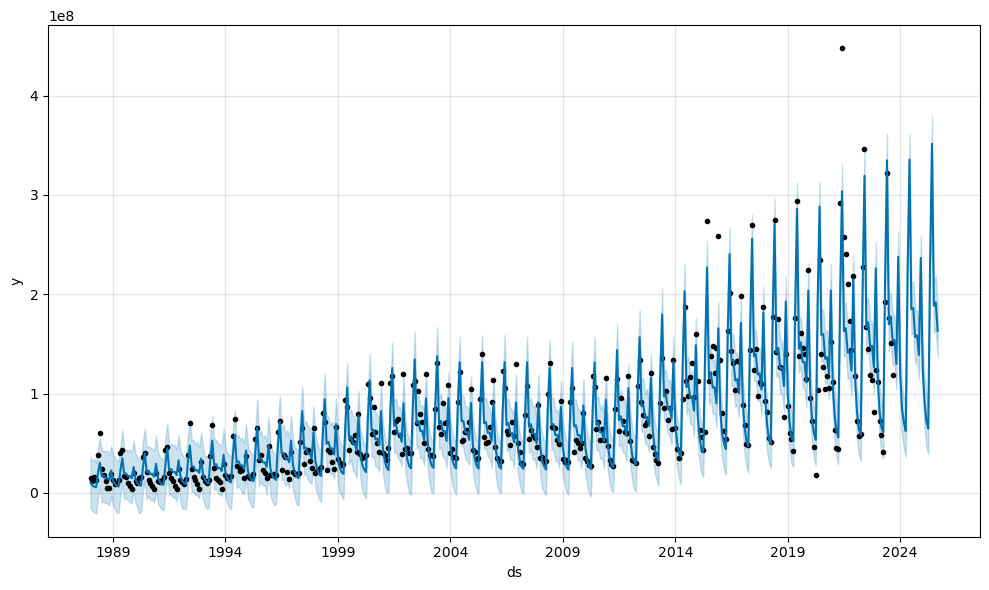

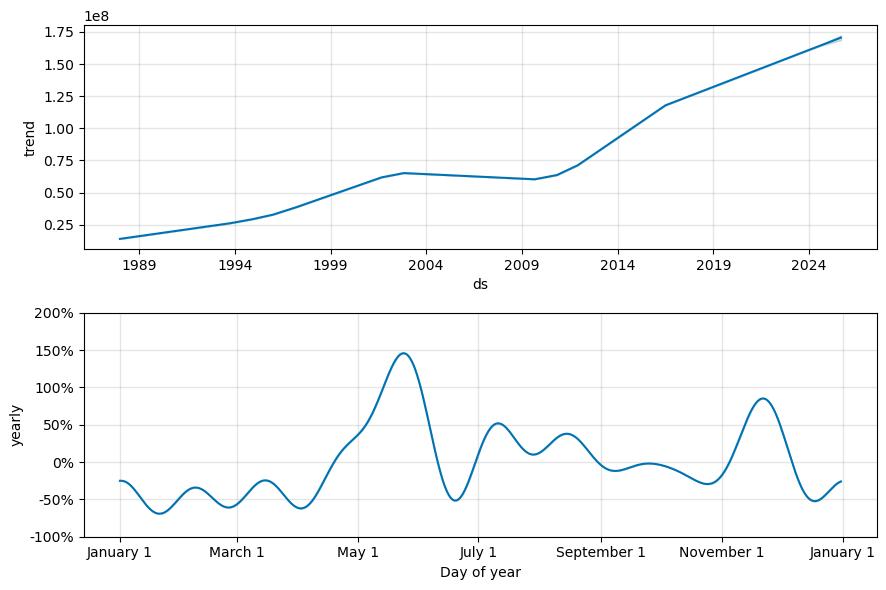

In [29]:
# predict 2018, 2019

prediction_range = 24
prediction_frequency = "MS"
future = m.make_future_dataframe(periods = 24, freq=prediction_frequency)
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation["model_prediction_date:"] =  dt_string
documentation["Prediction range(num periods):"] = prediction_range
documentation["Prediction frequency:"]= prediction_frequency
documentation

In [30]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

,ds,yhat,yhat_lower,yhat_upper
0,1988-01-01,"10,356,626.90","-15,812,771.89","35,788,014.54"
1,1988-02-01,"7,373,835.69","-17,815,272.30","34,088,699.45"
2,1988-03-01,"6,248,409.96","-19,262,443.39","34,417,738.09"
3,1988-04-01,"5,525,417.17","-22,114,938.68","31,157,494.81"
4,1988-05-01,"19,979,874.14","-5,364,661.49","48,707,743.97"
...,...,...,...,...
448,2025-05-01,"229,671,604.40","203,341,286.22","255,761,549.92"
449,2025-06-01,"351,529,731.10","323,412,498.51","377,147,250.51"
450,2025-07-01,"188,421,374.99","161,938,732.83","214,965,964.50"
451,2025-08-01,"191,784,705.50","165,035,297.99","218,421,970.95"


#### Next steps:
* run on non log values
    * calc test / train metrics mannually
* run on noninflation adjusted vals
* Keep agg on months 

In [31]:
mape_idx = mapes.index(min(mapes))
print(mape_idx)
rmse_idx = rmses.index(min(rmses))
print(rmse_idx)

30
30


In [32]:
pd.DataFrame.from_dict(best_params, orient = 'index', columns = ['model_grouped_data'] )

,model_grouped_data
changepoint_prior_scale,0.10
seasonality_prior_scale,1.01
seasonality_mode,multiplicative
yearly_seasonality,True
rmse,"26,305,292.84"
mape,0.18


In [33]:
documentation

{'description': 'Predictions using best params and cv on us data not adjusted for inflation or log',
 'train_data_source': 'us data: unindexed no log',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2024-01-08 10:33',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 10:33',
 'Prediction range(num periods):': 24,
 'Prediction frequency:': 'MS'}

In [34]:
# Model Eval Metrics
# split y actuals and predictions for train range
y_actual_train = df_year_filter(model_data_grouped, 1988, 2017)['y']
y_pred_train = df_year_filter(predictions, 1988, 2017)['yhat']

# RMSE - PROPHET - 1988 to 2017 TRAIN RANGE

mse_train = mean_squared_error(y_actual_train, y_pred_train, squared=True)
rmse_train =  mean_squared_error(y_actual_train, y_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(y_actual_train, y_pred_train)
# print(f'Train Prophet MSE value is {mse_train: ,.2f}, years 1988 to 2017')
# print(f'Train Prophet RMSE value is {rmse_train : ,.2f}, years 1988 to 2017')
# print(f'Train Prophet MAPE value is {mape_train: ,.5f}, years 1988 to 2017')

# RMSE - PROPHET - 2018 to 2019 TEST RANGE
# split y actuals and predictions for TEST range
y_actual_test = df_year_filter(model_data_grouped, 2018, 2019)['y']
y_pred_test = df_year_filter(predictions, 2018, 2019)['yhat']


mse_test = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse_test =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape_test = mean_absolute_percentage_error(y_actual_test, y_pred_test)
# print(f'TEST Prophet MSE value is {mse_test: ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet RMSE value is {rmse_test : ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet MAPE value is {mape_test: ,.5f}, years 2018 to 2019')
best_prophet_vals = [mse_train, mse_test, rmse_train, rmse_test, mape_train, mape_test]

In [35]:
results = pd.DataFrame(data={'Prophet-Best':best_prophet_vals}, index = ['mse_train', 'mse_test', 'rmse_train', 'rmse_test', 'mape_train', 'mape_test'])

In [36]:
results

,Prophet-Best
mse_train,"1,415,017,803,445,176.25"
mse_test,"1,182,226,568,181,031.25"
rmse_train,"37,616,722.39"
rmse_test,"34,383,521.75"
mape_train,0.37
mape_test,0.17


In [37]:
documentation['results'] = results.to_dict()

In [38]:
documentation

{'description': 'Predictions using best params and cv on us data not adjusted for inflation or log',
 'train_data_source': 'us data: unindexed no log',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'us data: unindexed no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 26305292.84164052,
  'mape': 0.17541140467660435},
 'model_fit_date': '2024-01-08 10:33',
 '.fit()': 'us_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 10:33',
 'Prediction range(num periods):': 24,
 'Prediction frequency:': 'MS',
 'results': {'Prophet-Best': {'mse_train': 1415017803445176.2,


# Results

In [39]:
# def mean_absolute_percentage_error(y_true, y_pred):
#     '''take in true(actual) and predicted values to calculate the MAPE score. 
#     MAPE = mean absolute percentage error'''
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     result = np.mean(np.abs((y_true - y_pred) / y_true))
#     return result

# Bin

In [82]:
tuning_attempts['smaller_CPS'] = best_params
tuning_attempts

,attempt1,initial=10yrs,initial=15yrs,smaller_CPS
changepoint_prior_scale,5,5,5,5
seasonality_prior_scale,25,25,25,15.00
seasonality_mode,multiplicative,multiplicative,multiplicative,multiplicative
yearly_seasonality,True,True,True,True
rmse,"84,155,734.63","84,155,734.63","84,155,734.63","83,961,852.17"


In [81]:
# attempt1_results = pd.DataFrame.from_dict(best_params, orient='index', columns = ['attempt1'])
tuning_attempts

,attempt1,initial=10yrs,initial=15yrs
changepoint_prior_scale,5,5,5
seasonality_prior_scale,25,25,25
seasonality_mode,multiplicative,multiplicative,multiplicative
yearly_seasonality,True,True,True
rmse,"84,155,734.63","84,155,734.63","84,155,734.63"
